<a href="https://colab.research.google.com/github/J-Nobull/Migration_Research/blob/main/Migration_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Research Project on Migration Within the USA

In [1]:
!pip install census
!pip install linearmodels

In [65]:
# Setup initial environment
import pandas as pd
import numpy as np
import os
import requests
import time
from io import BytesIO
from census import Census
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu, rankdata, norm
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from linearmodels import PooledOLS
from statsmodels.discrete.discrete_model import Poisson
import statsmodels.formula.api as smf
from libpysal.weights import Queen, KNN, DistanceBand
from esda.moran import Moran
from spreg import OLS, ML_Lag, ML_Error
from linearmodels.iv import IV2SLS
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from graphviz import Digraph
from IPython.display import Image, display
%matplotlib inline
print('\nEnvironment Ready')


Environment Ready


# Define Keys
(KEY SECRETS NOT SET UP YET, USER MUST GET THEIR OWN KEY AND REPLACE Key-Here)

Get API keys:  
https://apps.bea.gov/API/signup/  
https://data.bls.gov/registrationEngine/  
https://api.census.gov/data/key_signup.html

In [60]:
API_KEY_BEA = 'Key-Here'
API_KEY_CENSUS = 'Key-Here'
API_KEY_BLS = 'Key-Here'

# In order for notebook to run properly --
# User must have 3 API Keys as mentioned above
# User must have downloaded:
#   countyinflowYEAR.csv - 11 files for 11 years analyzed (2011-2021)
#   rruc, amenities, typology - 4 files for 11 years (change scope in code)
#   Incentives.csv - (2025 Study file has 4417 records for 2016-2021)

'''
# from getpass import getpass
def get_api_key(name):
    key = os.getenv(name)
    if not key:
        key = getpass(f"Enter {name} (hidden input): ")
    return key

API_KEY_BEA = get_api_key('API_KEY_BEA')
API_KEY_BLS = get_api_key('API_KEY_BLS')
API_KEY_CENSUS = get_api_key('API_KEY_CENSUS')

print('API keys loaded')
'''

'\n# from getpass import getpass\ndef get_api_key(name):\n    key = os.getenv(name)\n    if not key:\n        key = getpass(f"Enter {name} (hidden input): ")\n    return key\n\nAPI_KEY_BEA = get_api_key(\'API_KEY_BEA\')\nAPI_KEY_BLS = get_api_key(\'API_KEY_BLS\')\nAPI_KEY_CENSUS = get_api_key(\'API_KEY_CENSUS\')\n\nprint(\'API keys loaded\')\n'

Define Helper function to create FIPS  
(common key to merge all datasets)

In [9]:
# Function to create 5-digit FIPS codes
def create_fips(state_fips_series, county_fips_series):
    return state_fips_series.astype(str).str.zfill(2) + \
           county_fips_series.astype(str).str.zfill(3)

# Download all datasets


## Download from Bureau of Economic Analysis (1 of 8)  
The following constant variables will be dropped from the respective files:  
PARPP-3: 'CL_UNIT' & 'UNIT_MULT'  
MARPP-3: 'CL_UNIT' & 'UNIT_MULT'  
CAINC1-3: 'CL_UNIT': 'Dollars', 'UNIT_MULT' & 'NoteRef'; as well as  'GeoName'  
CAGDP1-1: 'CL_UNIT': 'Thousands of chained 2017 dollars' & 'UNIT_MULT'; as well as 'GeoName'

In [10]:
BEA_URL = 'https://apps.bea.gov/api/data'
YEARS = list(range(2011, 2022))

# Define Tables with LineCodes and GeoFips
TABLES = [
    {'name': 'PARPP', 'linecode': '3', # Cost of living for Metro/Non-metro
     'geofips': 'PORT', 'desc': 'RPP_portion', 'filename': 'BEA_rpp_p.csv'},
    {'name': 'MARPP', 'linecode': '3', # Cost of living for Urban areas (MSAs)
     'geofips': 'MSA', 'desc': 'RPP_msa', 'filename': 'BEA_rpp_m.csv'},
    {'name': 'CAINC1', 'linecode': '3', # County Per Capita Income (PCI)
     'geofips': 'COUNTY', 'desc': 'BEA_pci', 'filename': 'BEA_PCI.csv'},
    {'name': 'CAGDP1', 'linecode': '1', # County Gross Domestic Product (GDP)
     'geofips': 'COUNTY', 'desc': 'BEA_gdp', 'filename': 'BEA_GDP.csv'}]

# Fetch tables
print('Downloading BEA data (2011-2021)...')

for table in TABLES:

    print(f"\nFetching {table['desc']} ({table['name']})...")

    params = {
        'UserID': API_KEY_BEA,
        'method': 'GetData',
        'datasetname': 'Regional',
        'TableName': table['name'],
        'LineCode': table['linecode'],
        'Year': YEARS,
        'GeoFips': table['geofips'],
        'ResultFormat': 'json'}

    response = requests.get(BEA_URL, params=params, timeout=120)
    data = response.json()

# Show errors
    if 'Error' in data.get('BEAAPI', {}):
        print(f" ❌ Error: {data['BEAAPI']['Error']['Detail']}")
        continue

    df = pd.DataFrame(data['BEAAPI']['Results']['Data'])

# Initialize rename_map dynamically based on available columns
    rename_map = {}

# Rename 'TimePeriod' to 'YEAR'
    if 'TimePeriod' in df.columns: rename_map['TimePeriod'] = 'YEAR'

# Rename 'DataValue' to table['desc']
    if 'DataValue' in df.columns: rename_map['DataValue'] = table['desc']
    else:
# If 'DataValue' not present, manually create column with NaNs
        print(f"  Warning: 'DataValue' column missing for {table['name']}. Creating '{table['desc']}' with NaN.")
        df[table['desc']] = np.nan

# Conditionally rename 'GeoFips'
    if 'GeoFips' in df.columns:
        if table['name'] in ['CAINC1', 'CAGDP1']:
            rename_map['GeoFips'] = 'FIPS'
        else: # For PARPP and MARPP
            rename_map['GeoFips'] = 'GeoFIPS' # lowercase to uppercase

# Apply renaming
    df = df.rename(columns=rename_map)

# After renaming, this handles errors.
    if 'YEAR' not in df.columns:
        df['YEAR'] = np.nan
        print(f"  Warning: 'TimePeriod' or 'YEAR' column not found in {table['name']}. 'YEAR' created with NaN.")
    df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')

# Convert the 'desc' column to numeric
    if table['desc'] in df.columns:
        df[table['desc']] = pd.to_numeric(df[table['desc']], errors='coerce')

# Keep 'GeoName' and other variables based on table type
    if table['name'] in ['PARPP', 'MARPP']:
# Ensure 'GeoName' is present before trying to select it
        cols_to_keep = ['GeoFIPS', 'YEAR', table['desc']]
        if 'GeoName' in df.columns:
            cols_to_keep.insert(1, 'GeoName') # Insert GeoName after GeoFips
        df = df[cols_to_keep]
    else: # For CAINC1 and CAGDP1
        # Ensure 'FIPS' column exists after renaming
        fips_col = 'FIPS'
        if fips_col not in df.columns:
            print(f"  Warning: '{fips_col}' column not found after renaming for {table['name']}. Skipping selection.")
            continue # Skip saving if critical column is missing
        df = df[[fips_col, 'YEAR', table['desc']]]

# Save to CSV
    df.to_csv(table['filename'], index=False)

    print(f"   Saved {len(df):,} rows to {table['filename']}")
# Add check to confirm file existence immediately after saving
    if os.path.exists(table['filename']):
        print(f"    (Confirmed: {table['filename']} exists on disk)")
    else:
        print(f"    (ERROR: {table['filename']} NOT found on disk after saving!)")
    print(df.head())
    time.sleep(2)

print('\n' + '='*30)
print('BEA DOWNLOAD COMPLETE')
print('='*30)
print('Files created:')
for table in TABLES:
    print(f"  - {table['filename']}")


Fetching RPP_portion (PARPP)...
   Saved 1,122 rows to BEA_rpp_p.csv
    (Confirmed: BEA_rpp_p.csv exists on disk)
  GeoFIPS                         GeoName  YEAR  RPP_portion
0   01998  Alabama (Metropolitan Portion)  2011       92.308
1   01998  Alabama (Metropolitan Portion)  2021       89.367
2   01998  Alabama (Metropolitan Portion)  2020       89.246
3   01998  Alabama (Metropolitan Portion)  2019       89.621
4   01998  Alabama (Metropolitan Portion)  2018       88.700

Fetching RPP_msa (MARPP)...
   Saved 4,224 rows to BEA_rpp_m.csv
    (Confirmed: BEA_rpp_m.csv exists on disk)
  GeoFIPS                                      GeoName  YEAR  RPP_msa
0   10180  Abilene, TX (Metropolitan Statistical Area)  2011   92.455
1   10180  Abilene, TX (Metropolitan Statistical Area)  2021   91.698
2   10180  Abilene, TX (Metropolitan Statistical Area)  2020   90.300
3   10180  Abilene, TX (Metropolitan Statistical Area)  2019   92.414
4   10180  Abilene, TX (Metropolitan Statistical Area)  

In [11]:
# Join BEA_PCI and BEA_GDP on FIPS and Year
BEA_PCI = pd.read_csv('BEA_PCI.csv')
BEA_PCI['FIPS'] = BEA_PCI['FIPS'].astype(str).str.zfill(5)
BEA_GDP = pd.read_csv('BEA_GDP.csv')
BEA_GDP['FIPS'] = BEA_GDP['FIPS'].astype(str).str.zfill(5)

BEA_join1 = pd.merge(BEA_PCI, BEA_GDP, on=['FIPS', 'YEAR'], how='inner')

# Create state variable from first 2 digits of FIPS
BEA_join1['STATE'] = BEA_join1[
    'FIPS'].str[:2].fillna(0).astype(int).astype(str).str.zfill(2)

# Display
print(BEA_join1.head())

    FIPS  YEAR  BEA_pci  BEA_gdp STATE
0  01001  2011    34430  1493906    01
1  01001  2012    35151  1726577    01
2  01001  2013    35348  1618151    01
3  01001  2014    36329  1629762    01
4  01001  2015    38107  1765826    01


In [12]:
# Download CBSA delineation file to convert RPP_MSA to FIPS-State 2-digit
url = 'https://www2.census.gov/programs-surveys/metro-micro/geographies/reference-files/2013/delineation-files/list1.xls'

# CBSA file will be used to convert MSA into 5-digit FIPS
print("Downloading Feb 2013 CBSA delineation file...")
response = requests.get(url)
cbsa_file = pd.read_excel(BytesIO(response.content), skiprows=2)

print(f"Loaded {len(cbsa_file):,} records from delineation file")

# Create 5-digit FIPS
cbsa_file['FIPS'] = create_fips(
    cbsa_file['FIPS State Code'].fillna(0).astype(int),
    cbsa_file['FIPS County Code'].fillna(0).astype(int))

cbsa_file.rename(columns={
    'CBSA Code': 'CBSA_code',
    'FIPS State Code': 'STATE'}, inplace=True)
cbsa_file['STATE'] = cbsa_file['STATE'].fillna(0).astype(int).astype(str).str.zfill(2)

BEA_rpp_m = pd.read_csv('BEA_rpp_m.csv')
BEA_rpp_m['GeoFIPS'] = BEA_rpp_m['GeoFIPS'].astype(str).str.zfill(5)

print(f"\nLoaded BEA file with {len(BEA_rpp_m):,} rows")
print(f"BEA GeoFIPS dtype: {BEA_rpp_m['GeoFIPS'].dtype}")
print(f"Crosswalk CBSA_code dtype: {cbsa_file['CBSA_code'].dtype}")

# Merge
df_merged = BEA_rpp_m.merge(cbsa_file, left_on='GeoFIPS', right_on='CBSA_code', how='left')

# Select final columns
BEA_join2 = df_merged[['FIPS', 'YEAR', 'RPP_msa', 'STATE']]

# Display
print(BEA_join2.head())

Loaded 1,885 records from delineation file

Loaded BEA file with 4,224 rows
BEA GeoFIPS dtype: object
Crosswalk CBSA_code dtype: object
    FIPS  YEAR  RPP_msa STATE
0  48059  2011   92.455    48
1  48253  2011   92.455    48
2  48441  2011   92.455    48
3  48059  2021   91.698    48
4  48253  2021   91.698    48


Line 22 clears unneeded columns.  
To visually verify full.merge and .fillna completed cleanly, create docstring: delete # on lines 21 & 23.

In [13]:
BEA_rpp_p = pd.read_csv('BEA_rpp_p.csv', dtype={'GeoFIPS': str})
# Create state variable from first 2 digits of FIPS
BEA_rpp_p['FIPS'] = BEA_rpp_p['GeoFIPS'].astype(str)
BEA_rpp_p['STATE'] = BEA_rpp_p['FIPS'].str[:2]
BEA_rpp_p = BEA_rpp_p[BEA_rpp_p['FIPS'].str.endswith('999')].copy()

# Merge BEA_join1 (PCI + GDP) with BEA_join2 (MSA/metro RPP)
BEA_full = BEA_join1.merge(BEA_join2[['FIPS', 'YEAR', 'RPP_msa']],
                            on=['FIPS', 'YEAR'],
                            how='left')

# Merge state-level RPP for filling NaN values
BEA_import = BEA_full.merge(BEA_rpp_p[['STATE', 'YEAR', 'RPP_portion']],
                          on=['STATE', 'YEAR'],
                          how='left')

# Fill null RPP values with RPP_portion
BEA_import['RPP'] = BEA_import['RPP_msa'].fillna(BEA_import['RPP_portion'])

# Drop the unneeded columns
# '''
BEA_import.drop(columns=['RPP_msa', 'RPP_portion', 'STATE'], inplace=True)
# '''
print(f"BEA_import complete with {len(BEA_import):,} rows")
print(f"RPP values filled: {BEA_import['RPP'].notna().sum():,}")

BEA_import.to_csv('BEA_import.csv', index=False)

# Display
print(BEA_import.head(35))

BEA_import complete with 34,298 rows
RPP values filled: 34,298
     FIPS  YEAR  BEA_pci  BEA_gdp     RPP
0   01001  2011    34430  1493906  91.098
1   01001  2012    35151  1726577  93.269
2   01001  2013    35348  1618151  91.394
3   01001  2014    36329  1629762  90.675
4   01001  2015    38107  1765826  90.622
5   01001  2016    39005  1846256  93.087
6   01001  2017    39906  1762558  92.801
7   01001  2018    41062  1787534  88.423
8   01001  2019    42538  1740015  88.756
9   01001  2020    45068  1746979  87.517
10  01001  2021    49174  1736001  88.497
11  01003  2020    50895  8109210  90.744
12  01003  2021    56285  8706236  92.054
13  01003  2011    38032  5930698  93.374
14  01003  2012    38284  5998672  95.844
15  01003  2013    38401  6314704  94.158
16  01003  2014    39568  6455247  94.076
17  01003  2015    41470  6757534  93.475
18  01003  2016    42983  7113177  94.811
19  01003  2017    44475  7382558  95.652
20  01003  2018    45840  7758980  91.470
21  01003  20

## Download from Census Bureau (2 of 8)  
download selected variables from Census "Detailed Tables"

In [14]:
API_KEY_CENSUS = '5f7c8b0ecd185273567de16a4c09273088d4340b'
CENSUS_URL = 'https://api.census.gov/data'
YEARS = list(range(2011, 2022))

# ACS variable definitions
ACS_VARS = {
# Population
    'B01003_001E': 'total_population',
# Age
    'B01002_001E': 'median_age',
# Housing
    'B25003_001E': 'housing_total',
    'B25003_002E': 'owner_occupied',
    'B25003_003E': 'renter_occupied',
    'B25002_003E': 'vacant',
    'B25077_001E': 'median_home_value',
# Households
    'B11001_002E': 'family_households',
# Marital Status
    'B12001_001E': 'marital_total',
    'B12001_003E': 'never_married_male',
    'B12001_004E': 'now_married_male',
    'B12001_010E': 'divorced_male',
    'B12001_009E': 'widowed_male',
    'B12001_012E': 'never_married_female',
    'B12001_013E': 'now_married_female',
    'B12001_018E': 'widowed_female',
    'B12001_019E': 'divorced_female',
# Children (all under 18)
    'B09001_002E': 'under_18_in_hh',
# Race/Ethnicity (sums to total)
    'B03002_003E': 'white',
    'B03002_004E': 'black',
    'B03002_005E': 'native',
    'B03002_006E': 'asian',
    'B03002_007E': 'pacific_islander',
    'B03002_008E': 'other_race',
    'B03002_009E': 'mixed_non_h',
    'B03002_012E': 'hispanic',
# Education
    'B15002_001E': 'education_total_sex',
    'B15002_011E': 'male_complete_hs',
    'B15002_012E': 'male_some_college<1',
    'B15002_013E': 'male_some_college>1',
    'B15002_014E': 'male_associates',
    'B15002_015E': 'male_bachelors',
    'B15002_016E': 'male_masters',
    'B15002_017E': 'male_professional',
    'B15002_018E': 'male_doctorate',
    'B15002_028E': 'female_complete_hs',
    'B15002_029E': 'female_some_college<1',
    'B15002_030E': 'female_some_college>1',
    'B15002_031E': 'female_associates',
    'B15002_032E': 'female_bachelors',
    'B15002_033E': 'female_masters',
    'B15002_034E': 'female_professional',
    'B15002_035E': 'female_doctorate',
# Income
    'B19013_001E': 'median_hh_income',
# Employment
    'B23025_004E': 'employed',
    'B23025_005E': 'unemployed',
    'B23025_007E': 'not_in_labor_force',
# Commute Time
    'B08303_002E': 'commute_less_5min',
    'B08303_003E': 'commute_5_9min',
    'B08303_004E': 'commute_10_14min',
    'B08303_005E': 'commute_15_19min',
    'B08303_006E': 'commute_20_24min',
    'B08303_007E': 'commute_25_29min',
    'B08303_008E': 'commute_30_34min',
    'B08303_009E': 'commute_35_39min',
    'B08303_010E': 'commute_40_44min',
    'B08303_011E': 'commute_45_59min',
    'B08303_012E': 'commute_60_89min',
    'B08303_013E': 'commute_90_plus_min',
# Worked from home
    'B08137_020E': 'work_in_owned_home',
    'B08137_021E': 'work_in_rental',
# Estate taxes paid
    'B25103_001E': 'median_property_taxes',
# Industry
    'C24060_001E': 'occupation_total',
    'C24060_002E': 'Mgmt_Biz_Sci_Arts',
    'C24060_003E': 'Services',
    'C24060_004E': 'Sales_Admin',
    'C24060_005E': 'Nat-rsrc_Constr_Maint',
    'C24060_006E': 'Prod_Transp_Mvng'}

def fetch_census_batch(year, variables):
    # Fetch one batch of Census variables for all counties.
    var_list = ','.join(variables)
    params = {
        'get': var_list,
        'for': 'county:*',
        'key': API_KEY_CENSUS}

    url = f'{CENSUS_URL}/{year}/acs/acs5'
    response = requests.get(url, params=params, timeout=120)

    # Check for HTTP errors first
    if response.status_code != 200:
        print(f"❌ HTTP Error for {year}: Status Code {response.status_code}")
        print(f"Response content: {response.text}")
        return pd.DataFrame()

    try:
        data = response.json()
    except requests.exceptions.JSONDecodeError:
        print(f"❌JSON Decode Error in {year}: Could not parse response as JSON")
        print(f"Response content: {response.text}")
        return pd.DataFrame()

    # Show errors based on parsed JSON (if any)
    if 'error' in data or len(data) <= 1:
        print(f"❌ Error: No data returned or API error for {year}")
        if 'error' in data:
            print(f"API error details: {data['error']}")
        return pd.DataFrame()

    df = pd.DataFrame(data[1:], columns=data[0])
    return df

# Fetch data
print('Downloading Census data (2011-2021)...\n')

all_years = []
all_vars = list(ACS_VARS.keys())
batch1 = all_vars[:45]  # Census API limit is 50 variables
batch2 = all_vars[45:]

for year in YEARS:
    print(f"Fetching year {year}...")

    # Fetch both batches
    df1 = fetch_census_batch(year, batch1)
    df2 = fetch_census_batch(year, batch2)

    if df1.empty:
        continue

    # Merge batches on state and county
    if not df2.empty:
        year_df = pd.merge(df1, df2, on=['state', 'county'], how='outer')
    else:
        year_df = df1

    # Rename variables
    year_df = year_df.rename(columns=ACS_VARS)

    # Create FIPS
    year_df['FIPS'] = create_fips(year_df['state'], year_df['county'])
    year_df['YEAR'] = year

    # Convert to numeric
    for col in ACS_VARS.values():
        if col in year_df.columns:
            year_df[col] = pd.to_numeric(year_df[col], errors='coerce')

    all_years.append(year_df)
    print(f"Saved {len(year_df):,} rows")
    time.sleep(0.5)

# Combine all years
if all_years:
    CEN_df = pd.concat(all_years, ignore_index=True)

    # Keep only needed columns
    keep_cols = ['FIPS', 'YEAR'] + [col for col in ACS_VARS.values()
                                     if col in CEN_df.columns]
    CEN_df = CEN_df[keep_cols]

    # Save to CSV
    CEN_df.to_csv('Census_import.csv', index=False)


    print("\n" + "=" * 30)
    print('CENSUS DOWNLOAD COMPLETE')
    print("\n" + "=" * 30)
    print(f"\n --Saved {len(CEN_df):,} rows")
    print(f"   Counties: {CEN_df['FIPS'].nunique()}")
    print(f"   Years: {CEN_df['YEAR'].min()}-{CEN_df['YEAR'].max()}")
    print(f"   Variables: {len(ACS_VARS)}")
else:
    print('\n❌ Error: No data was downloaded')


Fetching year 2011...
Saved 3,221 rows
Fetching year 2012...
Saved 3,221 rows
Fetching year 2013...
Saved 3,221 rows
Fetching year 2014...
Saved 3,220 rows
Fetching year 2015...
Saved 3,220 rows
Fetching year 2016...
Saved 3,220 rows
Fetching year 2017...
Saved 3,220 rows
Fetching year 2018...
Saved 3,220 rows
Fetching year 2019...
Saved 3,220 rows
Fetching year 2020...
Saved 3,221 rows
Fetching year 2021...
Saved 3,221 rows

CENSUS IMPORT COMPLETE


 --Saved 35,425 rows
   Counties: 3225
   Years: 2011-2021
   Variables: 68


## Download from Bureau of Labor Statistics (3 of 8)  
only download 'unemployment rate'

In [15]:
BLS_URL = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
YEARS = list(range(2011, 2022))

print('Building BLS series IDs from Census FIPS codes...\n')

# Get FIPS from Census data, ensure FIPS is string and zero-filled
census_df = pd.read_csv('Census_import.csv', dtype={'FIPS': str})
census_df['FIPS'] = census_df['FIPS'].str.zfill(5)
unique_fips = sorted(census_df['FIPS'].unique())

# Build series IDs for matching counties
all_series = [f'LAUCN{fips}0000000003' for fips in unique_fips]

print(f'Found {len(all_series):,} counties from Census data')
print(f'Will require {(len(all_series) + 49) // 50} batches\n')

# Download in batches of 50
batch_size = 50
all_data = []

print('Downloading BLS unemployment rate data (2011-2021)...\n')

for i in range(0, len(all_series), batch_size):
    batch = all_series[i:i+batch_size]
    batch_num = i // batch_size + 1
    total_batches = (len(all_series) + 49) // 50

    payload = {
        'seriesid': batch,
        'startyear': '2011',
        'endyear': '2021',
        'registrationkey': API_KEY_BLS,
        'annualaverage': True}

    response = requests.post(BLS_URL, json=payload, timeout=120)
    data = response.json()

# Check for errors
    if data.get('status') != 'REQUEST_SUCCEEDED':
        print(f'❌ Batch {batch_num}/{total_batches} error: {data.get("message", "Unknown")}')
        continue

# Parse response
    for series in data['Results']['series']:
        series_id = series['seriesID']
        fips = series_id[5:10]  # Extract FIPS

        for item in series['data']:
            if item['period'] == 'M13':  # Average unemployment rate for year
                value = item['value']

                # Handle missing data (represented as '-')
                if value == '-':
                    unemployment_rate = None
                else:
                    unemployment_rate = float(value)

                all_data.append({
                    'FIPS': fips,
                    'YEAR': int(item['year']),
                    'unemploy_rate': unemployment_rate})

    print(f'  Batch {batch_num}/{total_batches}')
    time.sleep(2)

# Save to CSV
if all_data:
    BLS_import = pd.DataFrame(all_data)
    BLS_import.to_csv('BLS_import.csv', index=False)

    print("\n" + "=" * 30)
    print('BLS DOWNLOAD COMPLETE')
    print("=" * 30)
    print(f'\n Saved {len(BLS_import):,} rows')
    print(f'  Counties: {BLS_import["FIPS"].nunique()}')
    print(f'  YEARS: {BLS_import["YEAR"].min()}-{BLS_import["YEAR"].max()}')
    print(f'  Missing values: {BLS_import["unemploy_rate"].isna().sum()}')
else:
    print('\n❌ Error: No data downloaded')

# Display
print(BLS_import.head(25))

Building BLS series IDs from Census FIPS codes...

Found 3,225 counties from Census data
Will require 65 batches


  Batch 1/65
  Batch 2/65
  Batch 3/65
  Batch 4/65
  Batch 5/65
  Batch 6/65
  Batch 7/65
  Batch 8/65
  Batch 9/65
  Batch 10/65
  Batch 11/65
  Batch 12/65
  Batch 13/65
  Batch 14/65
  Batch 15/65
  Batch 16/65
  Batch 17/65
  Batch 18/65
  Batch 19/65
  Batch 20/65
  Batch 21/65
  Batch 22/65
  Batch 23/65
  Batch 24/65
  Batch 25/65
  Batch 26/65
  Batch 27/65
  Batch 28/65
  Batch 29/65
  Batch 30/65
  Batch 31/65
  Batch 32/65
  Batch 33/65
  Batch 34/65
  Batch 35/65
  Batch 36/65
  Batch 37/65
  Batch 38/65
  Batch 39/65
  Batch 40/65
  Batch 41/65
  Batch 42/65
  Batch 43/65
  Batch 44/65
  Batch 45/65
  Batch 46/65
  Batch 47/65
  Batch 48/65
  Batch 49/65
  Batch 50/65
  Batch 51/65
  Batch 52/65
  Batch 53/65
  Batch 54/65
  Batch 55/65
  Batch 56/65
  Batch 57/65
  Batch 58/65
  Batch 59/65
  Batch 60/65
  Batch 61/65
  Batch 62/65
  Batch 63/65
  Batch 64/6

## Read data from IRS (4 of 8)  
download 11 State-to-state inflow files for 2011-2021 at:  
https://www.irs.gov/statistics/soi-tax-stats-migration-data  
IRS n2=number of exemptions, labeling that variable n_movers,  
assumes numbers of people that moved attached to one tax return (n1).

In [16]:
# Define the years and file paths
years = list(range(2011, 2022))
year_mapping = {
    2011: 'countyinflow1112.csv',
    2012: 'countyinflow1213.csv',
    2013: 'countyinflow1314.csv',
    2014: 'countyinflow1415.csv',
    2015: 'countyinflow1516.csv',
    2016: 'countyinflow1617.csv',
    2017: 'countyinflow1718.csv',
    2018: 'countyinflow1819.csv',
    2019: 'countyinflow1920.csv',
    2020: 'countyinflow2021.csv',
    2021: 'countyinflow2122.csv'}

print("Starting IRS Migration Data Import...")

all_data = []

for year, filepath in year_mapping.items():
    print(f"Processing {year}...")

    IRS_df = pd.read_csv(filepath, encoding='latin-1')
    IRS_df['YEAR'] = year

    IRS_df['out_FIPS'] = create_fips(IRS_df['y1_statefips'], IRS_df['y1_countyfips'])
    IRS_df['in_FIPS'] = create_fips(IRS_df['y2_statefips'], IRS_df['y2_countyfips'])
# Rename n2 = Number of Exemptions on that calendar years' returns
    IRS_df = IRS_df.rename(columns={'n2': 'Movers'})
    IRS_df.replace(-1, np.nan, inplace=True)

    print(f"  Rows: {len(IRS_df):,}")

    all_data.append(IRS_df)

IRS_full = pd.concat(all_data, ignore_index=True)

# Order variables
final_cols = ['out_FIPS', 'in_FIPS', 'YEAR', 'Movers', 'agi']

# Create the dataframe
IRS_import = IRS_full[final_cols]
IRS_import.to_csv('IRS_import.csv', index=False)


print('\n' + '='*30)
print("\n Saved to IRS_import.csv")
print('\n' + '='*30)
print(f"\nTotal rows: {len(IRS_import):,}")

# Display
IRS_import.head(10)

Starting IRS Migration Data Import...
Processing 2011...
  Rows: 130,101
Processing 2012...
  Rows: 131,931
Processing 2013...
  Rows: 86,193
Processing 2014...
  Rows: 75,527
Processing 2015...
  Rows: 86,330
Processing 2016...
  Rows: 98,874
Processing 2017...
  Rows: 87,932
Processing 2018...
  Rows: 83,762
Processing 2019...
  Rows: 87,552
Processing 2020...
  Rows: 89,850
Processing 2021...
  Rows: 90,498


 Saved to IRS_import.csv


Total rows: 1,048,550


,out_FIPS,in_FIPS,YEAR,Movers,agi
0,96000,01000,2011,238230.0,4549431.0
1,97000,01000,2011,235901.0,4500247.0
2,97001,01000,2011,135124.0,2381712.0
3,97003,01000,2011,100777.0,2118535.0
4,98000,01000,2011,2329.0,49184.0
5,96000,01001,2011,4618.0,83494.0
6,97000,01001,2011,4511.0,80882.0
7,97001,01001,2011,2961.0,48904.0
8,97003,01001,2011,1550.0,31978.0
9,98000,01001,2011,107.0,2612.0


## Read 4 datafiles from USDA (8 of 8)  
download 4 files (names are top line in each cell) from:  
https://www.ers.usda.gov/data-products

In [17]:
# 5: County Typology Codes, 2015 Edition
# --------------------------------------------------
typology = pd.read_csv('erscountytypology2015edition.csv')

# Ensure FIPS is 5-digit string
typology['FIPStxt'] = typology['FIPStxt'].astype(str).str.zfill(5)

# Rename columns
typology.rename(columns={
    'FIPStxt': 'FIPS',
    'Economic Types Type_2015_Update non-overlapping': 'Industry_type',
    'Farming_2015_Update': 'Farming',
    'Mining_2015-Update': 'Mining',
    'Manufacturing_2015_Update': 'Mfging',
    'Government_2015_Update': 'Govt',
    'Recreation_2015_Update': 'Rec',
    'Nonspecialized_2015_Update': 'Nonspec',
    'Low_Education_2015_Update': 'Low_Ed_cnty',
    'Low_Employment_Cnty_2008_2012_25_64': 'Low_emp_cnty',
    'Retirement_Dest_2015_Update': 'Retire_dest_cnty',
    'Persistent_Poverty_2013': 'Persistent_Pov_cnty',
    'Persistent_Related_Child_Poverty_2013': 'Pers_chld_pov_cnty'}, inplace=True)

# Drop variables to avoid duplication
typology = typology.drop(columns=['State', 'County_name',
    'Metro-nonmetro status, 2013 0=Nonmetro 1=Metro',
    'Economic_Type_Label'])

print(f"Economic Typology 2015: {len(typology):,} counties")
# Display
typology.head(10)

Economic Typology 2015: 3,143 counties


,FIPS,Industry_type,Farming,Mining,Mfging,Govt,Rec,Nonspec,Low_Ed_cnty,Low_emp_cnty,Pop_Loss_2010,Retire_dest_cnty,Persistent_Pov_cnty,Pers_chld_pov_cnty
0,01001,0,0,0,0,0,0,1,0,0,0,1,0,0
1,01003,5,0,0,0,0,1,0,0,0,0,1,0,0
2,01005,3,0,0,1,0,0,0,1,1,0,0,1,1
3,01007,0,0,0,0,0,0,1,1,1,0,0,0,1
4,01009,0,0,0,0,0,0,1,1,1,0,0,0,0
5,01011,3,0,0,1,1,0,0,1,1,0,0,1,1
6,01013,0,0,0,0,0,0,1,0,1,1,0,1,1
7,01015,4,0,0,0,1,0,0,0,1,0,0,0,0
8,01017,0,0,0,0,0,0,1,1,1,1,0,0,1
9,01019,0,0,0,0,0,0,1,0,1,0,0,0,0


In [18]:
# 6: Natural Amenities Scale
# --------------------------------------------------
# Data starts at row 105
amenities = pd.read_excel('natamenf_1_.xls', skiprows=104, engine='xlrd')

# Ensure FIPS is 5-digit string
amenities['FIPS Code'] = amenities['FIPS Code'].astype(str).str.zfill(5)

# Rename variables
amenities.rename(columns={
    'FIPS Code': 'FIPS',
    'Scale': 'Amenity_score',
    ' 1=Low  7=High': 'Amenity_rank'}, inplace=True)

# Select only Amenity variables, drop the component variables
amenities = amenities[['FIPS', 'Amenity_score', 'Amenity_rank']]

print(f"Natural Amenities: {len(amenities):,} counties")
# Display
amenities.head(10)

Natural Amenities: 3,111 counties


,FIPS,Amenity_score,Amenity_rank
0,01001,0.78,4
1,01003,1.82,4
2,01005,0.19,4
3,01007,-0.15,3
4,01009,0.23,4
5,01011,-1.08,3
6,01013,-1.16,3
7,01015,0.22,4
8,01017,-0.34,3
9,01019,0.64,4


In [19]:
# 7: Rural-Urban Continuum Codes (RUCC) 2013
# --------------------------------------------------
rucc2013 = pd.read_excel('ruralurbancodes2013.xls')

# Ensure FIPS is 5-digit string
rucc2013['FIPS'] = rucc2013['FIPS'].astype(str).str.zfill(5)

# Rename Population variable
rucc2013 = rucc2013.rename(columns={'Population_2010': 'POP_2010'})

# Select only RUCC code and population (drop 3 variables)
rucc2013 = rucc2013.drop(columns=['Description', 'State', 'County_Name'])

print(f"RUCC 2013: {len(rucc2013):,} counties")
# Display
rucc2013.head(10)

RUCC 2013: 3,234 counties


,FIPS,POP_2010,RUCC_2013
0,01001,54571,2.0
1,01003,182265,3.0
2,01005,27457,6.0
3,01007,22915,1.0
4,01009,57322,1.0
5,01011,10914,6.0
6,01013,20947,6.0
7,01015,118572,3.0
8,01017,34215,6.0
9,01019,25989,6.0


In [20]:
# 8: Rural-Urban Continuum Codes (RUCC) 2023
# --------------------------------------------------
# Data is long format - 3 rows (Population, RUCC code, Description)
ruccode2023 = pd.read_csv('Ruralurbancontinuumcodes2023.csv', encoding='latin-1')

# Pivot from long to wide
rucc2023 = ruccode2023.pivot(
    index='FIPS',
    columns='Attribute',
    values='Value')

# Reset the index to turn pivoted index into a regular column
rucc2023 = rucc2023.reset_index()

# Clear the columns name attribute after pivoting
rucc2023.columns.name = None

# Ensure FIPS is 5-digit string
rucc2023['FIPS'] = rucc2023['FIPS'].astype(str).str.zfill(5)

# Rename Population variable
rucc2023 = rucc2023.rename(columns={'Population_2020': 'POP_2020'})

# Select only RUCC code and population (drop description)
rucc2023 = rucc2023[['FIPS', 'POP_2020', 'RUCC_2023']]

print(f"RUCC 2023: {len(rucc2023):,} counties")
# Display
rucc2023.head(10)

RUCC 2023: 3,236 counties


,FIPS,POP_2020,RUCC_2023
0,00nan,NaN,NaN
1,1001.0,58805,2
2,1003.0,231767,3
3,1005.0,25223,6
4,1007.0,22293,1
5,1009.0,59134,1
6,1011.0,10357,8
7,1013.0,19051,6
8,1015.0,116441,3
9,1017.0,34772,6


Merge all USDA data together

In [21]:
# Merge All USDA and Create County-Year Panel, with RUCC2013 as base
usda_base = rucc2013[['FIPS', 'POP_2010', 'RUCC_2013']].copy()

# Merge all classification variables
usda_base = usda_base.merge(rucc2023, on='FIPS', how='left')
usda_base = usda_base.merge(amenities, on='FIPS', how='left')
usda_base = usda_base.merge(typology, on='FIPS', how='left')

print(f"\nMerged USDA classifications: {len(usda_base):,} counties")
print(f"Total variables: {len(usda_base.columns)}")

# Expand to county-year panel (2011-2021)
usda_panel = []
for year in range(2011, 2022):
    df_year = usda_base.copy()
    df_year['YEAR'] = year
# Move YEAR to second column
    cols = df_year.columns.tolist()
    cols = [cols[0], 'YEAR'] + [c for c in cols[1:] if c != 'YEAR']
    df_year = df_year[cols]
    usda_panel.append(df_year)

usda_import = pd.concat(usda_panel, ignore_index=True)

# Save single consolidated panel
usda_import.to_csv('USDA_import.csv', index=False)

print('\n' + '='*30)
print("USDA MERGE COMPLETE")
print('\n' + '='*30)
print(f"\nTotal county-year observations: {len(usda_import):,}")
print(f"Unique counties: {usda_import['FIPS'].nunique():,}")
print(f"Total variables: {len(usda_import.columns)}")
# Display
usda_import.head(10)


Merged USDA classifications: 3,234 counties
Total variables: 20

USDA MERGE COMPLETE


Total county-year observations: 35,574
Unique counties: 3,234
Total variables: 21


,FIPS,YEAR,POP_2010,RUCC_2013,POP_2020,RUCC_2023,Amenity_score,Amenity_rank,Industry_type,Farming,...,Mfging,Govt,Rec,Nonspec,Low_Ed_cnty,Low_emp_cnty,Pop_Loss_2010,Retire_dest_cnty,Persistent_Pov_cnty,Pers_chld_pov_cnty
0,01001,2011,54571,2.0,NaN,NaN,0.78,4.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,01003,2011,182265,3.0,NaN,NaN,1.82,4.0,5.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,01005,2011,27457,6.0,NaN,NaN,0.19,4.0,3.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,01007,2011,22915,1.0,NaN,NaN,-0.15,3.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4,01009,2011,57322,1.0,NaN,NaN,0.23,4.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
5,01011,2011,10914,6.0,NaN,NaN,-1.08,3.0,3.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
6,01013,2011,20947,6.0,NaN,NaN,-1.16,3.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
7,01015,2011,118572,3.0,NaN,NaN,0.22,4.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,01017,2011,34215,6.0,NaN,NaN,-0.34,3.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
9,01019,2011,25989,6.0,NaN,NaN,0.64,4.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


# Inspect and Clean datasets  
Look for min, max, nulls  
negative values and other outliers

##Inspect BEA


change (15901) to (15009)

In [22]:
BEA_clean = pd.read_csv('BEA_import.csv')

# Convert 'FIPS' to 5-digit string
BEA_clean['FIPS'] = BEA_clean['FIPS'].astype(str).str.zfill(5)

print('\nBEA first rows')
print(BEA_clean.head())
print('\nBEA variable info')
print(BEA_clean.info())
print('\nBEA descriptive stats')
print(BEA_clean.describe())
print('\n BEA nulls')
print(BEA_clean.isnull().sum())


BEA first rows
    FIPS  YEAR  BEA_pci  BEA_gdp     RPP
0  01001  2011    34430  1493906  91.098
1  01001  2012    35151  1726577  93.269
2  01001  2013    35348  1618151  91.394
3  01001  2014    36329  1629762  90.675
4  01001  2015    38107  1765826  90.622

BEA variable info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34298 entries, 0 to 34297
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   FIPS     34298 non-null  object 
 1   YEAR     34298 non-null  int64  
 2   BEA_pci  34298 non-null  int64  
 3   BEA_gdp  34298 non-null  int64  
 4   RPP      34298 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 1.3+ MB
None

BEA descriptive stats
               YEAR        BEA_pci       BEA_gdp           RPP
count  34298.000000   34298.000000  3.429800e+04  34298.000000
mean    2016.000000   42470.220188  6.115655e+06     90.968153
std        3.162324   12990.093071  2.665519e+07      6.529244
min

In [23]:
# Apply FIPS remapping: change '15901' to '15009' in BEA_clean
BEA_clean['FIPS'] = BEA_clean['FIPS'].replace({'15901': '15009'})

#Save
BEA_clean.to_csv('BEA_import.csv', index=False)

## BLS Inspection  
78 MVs
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
Puerto Rico is missing 2020 values
Drop Puerto Rico (72000 Series)

In [24]:
BLS_clean = pd.read_csv('BLS_import.csv')

# Convert 'FIPS' to 5-digit string
BLS_clean['FIPS'] = BLS_clean['FIPS'].astype(str).str.zfill(5)

print('\nBLS first rows')
print(BLS_clean.head())
print('\nBLS variable info')
print(BLS_clean.info())
print('\nBLS descriptive stats')
print(BLS_clean.describe())
print('\nBLS nulls')
print(BLS_clean.isnull().sum())


BLS first rows
    FIPS  YEAR  unemploy_rate
0  01001  2021            2.7
1  01001  2020            5.3
2  01001  2019            2.9
3  01001  2018            3.6
4  01001  2017            4.0

BLS variable info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35323 entries, 0 to 35322
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FIPS           35323 non-null  object 
 1   YEAR           35323 non-null  int64  
 2   unemploy_rate  35245 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 828.0+ KB
None

BLS descriptive stats
               YEAR  unemploy_rate
count  35323.000000   35245.000000
mean    2016.000255       6.104962
std        3.162416       2.960603
min     2011.000000       1.100000
25%     2013.000000       4.000000
50%     2016.000000       5.400000
75%     2019.000000       7.500000
max     2021.000000      28.900000

BLS nulls
FIPS              0
YEAR              0

In [25]:
# Exclude Puerto Rico (FIPS codes starting with '72')
BLS_clean = BLS_clean[~BLS_clean['FIPS'].astype(str).str.startswith('72')]

print('\nBLS missing values after cleaning:')
print(BLS_clean.isnull().sum())
print(BLS_clean.tail())
print(BLS_clean.info())


BLS missing values after cleaning:
FIPS             0
YEAR             0
unemploy_rate    0
dtype: int64
        FIPS  YEAR  unemploy_rate
34460  56045  2015            3.4
34461  56045  2014            3.5
34462  56045  2013            3.6
34463  56045  2012            4.1
34464  56045  2011            4.8
<class 'pandas.core.frame.DataFrame'>
Index: 34465 entries, 0 to 34464
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FIPS           34465 non-null  object 
 1   YEAR           34465 non-null  int64  
 2   unemploy_rate  34465 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB
None


## Census Inspection  
inspect 23 vars with 1MV  
inspect 1 var with 2 MVs  
inspect 1 var with 11 MVs  
inspect med_home_value -666666666 values  
inspect med_hh_income -666666666 values  
inspect med_prop_taxes -666666666 values  

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Kalawao, HI(15005): DROP ALL  
total_population averages 105 from 2011-2021.  
BEA.gov: "Kalawao County, Hawaii is combined with Maui County.  
Separate estimates for the jurisdictions making up the combination areas are not available"  
(0.002% of Maui population)

Rio Arriba, New Mexico(35039):  
23 MVs in 2018: Fill with average of 2017 and 2019.  

(46017)(46095)(48243)(48261)(48301) NaN's:  
2014 med_hm_value appears to be an error [166700]  
Fill with average 2011-2021.  
or ave of year before and year after.

In [26]:
Census_clean = pd.read_csv('Census_import.csv')

# Convert 'FIPS' to 5-digit string
Census_clean['FIPS'] = Census_clean['FIPS'].astype(str).str.zfill(5)

# Exclude Puerto Rico
Census_clean = Census_clean[
    ~Census_clean['FIPS'].astype(str).str.startswith('72')]

# Drop Kalawao, HI (FIPS code 15005)
Census_clean = Census_clean[
    ~Census_clean['FIPS'].astype(str).str.startswith('15005')]

print('\nCensus first rows:')
print(Census_clean.head())
pd.set_option('display.max_columns', None) # Display ALL variable info/stats
print('\nCensus variable info:')
print(Census_clean.info())
print('\nCensus descriptive stats:')
print(Census_clean.describe())
print('\nCensus nulls:')
print(Census_clean.isnull().sum())
pd.reset_option('display.max_columns') # Reset display to default


Census first rows:
    FIPS  YEAR  total_population  median_age  housing_total  owner_occupied  \
0  01001  2011             53944        36.4          19998           15548   
1  01003  2011            179523        41.4          70757           53939   
2  01005  2011             27546        38.3           9589            6371   
3  01007  2011             22746        39.1           7225            5998   
4  01009  2011             57140        38.8          20954           16747   

   renter_occupied  vacant  median_home_value  family_households  ...  \
0             4450    1861           137500.0              14631  ...   
1            16818   32221           175700.0              50922  ...   
2             3218    2314            91600.0               6634  ...   
3             1227    1708            87500.0               5334  ...   
4             4207    2774           111500.0              15473  ...   

   commute_90_plus_min  work_in_owned_home  work_in_rental  \
0   

## Calculate Percentage Variables

Convert `housing_occupied`,`marital_status`, and `race/ethnicity` to percentage scale.


In [27]:
print(Census_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 34556 entries, 0 to 35346
Data columns (total 70 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FIPS                   34556 non-null  object 
 1   YEAR                   34556 non-null  int64  
 2   total_population       34556 non-null  int64  
 3   median_age             34556 non-null  float64
 4   housing_total          34556 non-null  int64  
 5   owner_occupied         34556 non-null  int64  
 6   renter_occupied        34556 non-null  int64  
 7   vacant                 34556 non-null  int64  
 8   median_home_value      34555 non-null  float64
 9   family_households      34556 non-null  int64  
 10  marital_total          34556 non-null  int64  
 11  never_married_male     34556 non-null  int64  
 12  now_married_male       34556 non-null  int64  
 13  divorced_male          34556 non-null  int64  
 14  widowed_male           34556 non-null  int64  
 15  never_m

In [28]:
Census_clean['%owner_occupied'] = (
    Census_clean['owner_occupied'] / Census_clean['housing_total']) * 100
Census_clean['%renter_occupied'] = (
    Census_clean['renter_occupied'] / Census_clean['housing_total']) * 100
'''
# Fill any NaN values that may have resulted from the percentage calculations with 0
Census_clean['%owner_occupied'] = Census_clean['%owner_occupied'].fillna(0)
Census_clean['%renter_occupied'] = Census_clean['%renter_occupied'].fillna(0)
'''
#print(Census_clean.info())

"\n# Fill any NaN values that may have resulted from the percentage calculations with 0\nCensus_clean['%owner_occupied'] = Census_clean['%owner_occupied'].fillna(0)\nCensus_clean['%renter_occupied'] = Census_clean['%renter_occupied'].fillna(0)\n"

In [29]:
Census1 = Census_clean['marital_total'] # create division variable

Census_clean['%never_married_male'] = (
    Census_clean['never_married_male'] / Census1) * 100
Census_clean['%now_married_male'] = (
    Census_clean['now_married_male'] / Census1) * 100
Census_clean['%divorced_male'] = (
    Census_clean['divorced_male'] / Census1) * 100
Census_clean['%widowed_male'] = (
    Census_clean['widowed_male'] / Census1) * 100
Census_clean['%never_married_female'] = (
    Census_clean['never_married_female'] / Census1) * 100
Census_clean['%now_married_female'] = (
    Census_clean['now_married_female'] / Census1) * 100
Census_clean['%divorced_female'] = (
    Census_clean['divorced_female'] / Census1) * 100
Census_clean['%widowed_female'] = (
    Census_clean['widowed_female'] / Census1) * 100
'''
# Fill any NaN values that may have resulted from the percentage calculations with 0
marital_pct_cols = [
    '%never_married_male', '%now_married_male', '%divorced_male', '%widowed_male',
    '%never_married_female', '%now_married_female', '%divorced_female', '%widowed_female']
for col in marital_pct_cols:
    Census_clean[col] = Census_clean[col].fillna(0)
'''
#print(Census_clean.info())

"\n# Fill any NaN values that may have resulted from the percentage calculations with 0\nmarital_pct_cols = [\n    '%never_married_male', '%now_married_male', '%divorced_male', '%widowed_male',\n    '%never_married_female', '%now_married_female', '%divorced_female', '%widowed_female']\nfor col in marital_pct_cols:\n    Census_clean[col] = Census_clean[col].fillna(0)\n"

In [30]:
Census2 = Census_clean['total_population'] # create division variable

Census_clean['%white'] = (
    Census_clean['white'] / Census2) * 100
Census_clean['%black'] = (
    Census_clean['black'] / Census2) * 100
Census_clean['%native'] = (
    Census_clean['native'] / Census2) * 100
Census_clean['%asian'] = (
    Census_clean['asian'] / Census2) * 100
Census_clean['%pacific_islander'] = (
    Census_clean['pacific_islander'] / Census2) * 100
Census_clean['%other_race'] = (
    Census_clean['other_race'] / Census2) * 100
Census_clean['%mixed_non_h'] = (
    Census_clean['mixed_non_h'] / Census2) * 100
Census_clean['%hispanic'] = (
    Census_clean['hispanic'] / Census2) * 100
'''
# Fill any NaN values that may have resulted from the percentage calculations with 0
race_pct_cols = [
    '%white', '%black', '%native', '%asian', '%pacific_islander',
    '%other_race', '%mixed_non_h', '%hispanic']
for col in race_pct_cols:
    Census_clean[col] = Census_clean[col].fillna(0)
'''
#print(Census_clean.info())

"\n# Fill any NaN values that may have resulted from the percentage calculations with 0\nrace_pct_cols = [\n    '%white', '%black', '%native', '%asian', '%pacific_islander',\n    '%other_race', '%mixed_non_h', '%hispanic']\nfor col in race_pct_cols:\n    Census_clean[col] = Census_clean[col].fillna(0)\n"

## Transform Education Variables
Combine sex-separated `education` categories

In [31]:
Census_clean['complete_hs'] = Census_clean[
    'male_complete_hs'] + Census_clean['female_complete_hs']
Census_clean['some_college'] = Census_clean[
    'male_some_college<1'] + Census_clean[
    'female_some_college<1'] + Census_clean[
    'male_some_college>1'] + Census_clean[
    'female_some_college>1']
Census_clean['associates'] = Census_clean[
    'male_associates'] + Census_clean['female_associates']
Census_clean['bachelors'] = Census_clean[
    'male_bachelors'] + Census_clean['female_bachelors']
Census_clean['masters'] = Census_clean[
    'male_masters'] + Census_clean['female_masters']
Census_clean['professional'] = Census_clean[
    'male_professional'] + Census_clean['female_professional']
Census_clean['doctorate'] = Census_clean[
    'male_doctorate'] + Census_clean['female_doctorate']
'''
# Fill any NaN values that may have resulted from the percentage calculations with 0
education_pct_cols = [
    '%complete_hs', '%some_college_lt1', '%some_college_gt1', '%associates',
    '%bachelors', '%masters', '%professional', '%doctorate']
for col in education_pct_cols:
    Census_clean[col] = Census_clean[col].fillna(0)
'''
#print(Census_clean.info())

"\n# Fill any NaN values that may have resulted from the percentage calculations with 0\neducation_pct_cols = [\n    '%complete_hs', '%some_college_lt1', '%some_college_gt1', '%associates',\n    '%bachelors', '%masters', '%professional', '%doctorate']\nfor col in education_pct_cols:\n    Census_clean[col] = Census_clean[col].fillna(0)\n"

In [32]:
# remove converted variables
housing_cols_to_drop = [
    'owner_occupied', 'renter_occupied']
marital_cols_to_drop = [
    'never_married_male', 'now_married_male',
    'divorced_male', 'widowed_male',
    'never_married_female', 'now_married_female',
    'widowed_female', 'divorced_female']
race_ethnicity_cols_to_drop = [
    'white', 'black', 'native', 'asian',
    'pacific_islander', 'other_race', 'mixed_non_h', 'hispanic']
education_cols_to_drop = [
    'male_complete_hs', 'male_some_college<1', 'male_some_college>1',
    'male_associates', 'male_bachelors', 'male_masters',
    'male_professional', 'male_doctorate',
    'female_complete_hs', 'female_some_college<1', 'female_some_college>1',
    'female_associates', 'female_bachelors', 'female_masters',
    'female_professional', 'female_doctorate']

Census_clean.drop(
    columns=housing_cols_to_drop + marital_cols_to_drop + \
            race_ethnicity_cols_to_drop + education_cols_to_drop,
    inplace=True, errors='ignore')

print(Census_clean.describe())

               YEAR  total_population    median_age  housing_total  \
count  34556.000000      3.455600e+04  34556.000000   3.455600e+04   
mean    2015.999913      1.013242e+05     40.953256   3.768169e+04   
std        3.162511      3.241876e+05      5.306183   1.142320e+05   
min     2011.000000      6.200000e+01     21.400000   2.700000e+01   
25%     2013.000000      1.099950e+04     37.800000   4.229750e+03   
50%     2016.000000      2.577200e+04     40.900000   9.839000e+03   
75%     2019.000000      6.739475e+04     44.000000   2.586500e+04   
max     2021.000000      1.010572e+07     68.100000   3.342811e+06   

              vacant  median_home_value  family_households  marital_total  \
count   34556.000000       3.455500e+04       3.455600e+04   3.455600e+04   
mean     5210.086295      -6.944683e+04       2.484054e+04   8.189434e+04   
std     12939.369194       1.189575e+07       7.473446e+04   2.613386e+05   
min        17.000000      -6.666667e+08       1.500000e+01   

In [33]:
#print(Census_clean.info())

Handle NaNs:  
As described at Inspection

In [34]:
        ## some code attributed to Colab Gemini

# For FIPS '35039' (Rio Arriba, NM)
fips_35039_mask = (Census_clean['FIPS'] == '35039')

# Identify columns with NaNs in 2018 for this FIPS
rows_2018_35039 = Census_clean[fips_35039_mask & (Census_clean['YEAR'] == 2018)]

if not rows_2018_35039.empty:
  for col in rows_2018_35039.columns:
    if rows_2018_35039[col].isnull().any():
    # Check if there is an NaN in this column for 2018
      # Get values for 2017 and 2019
      val_2017 = Census_clean[fips_35039_mask & (Census_clean['YEAR'] == 2017)][col].iloc[0] if not Census_clean[fips_35039_mask & (Census_clean['YEAR'] == 2017)].empty else np.nan
      val_2019 = Census_clean[fips_35039_mask & (Census_clean['YEAR'] == 2019)][col].iloc[0] if not Census_clean[fips_35039_mask & (Census_clean['YEAR'] == 2019)].empty else np.nan

# Calculate average and fill if both values are available
if pd.notna(val_2017) and pd.notna(val_2019):
                imputed_value = (val_2017 + val_2019) / 2
                Census_clean.loc[fips_35039_mask & (Census_clean['YEAR'] == 2018), col] = imputed_value

# For FIPS '46017' (Buffalo, SD)
fips_46017_mask = (Census_clean['FIPS'] == '46017')

# Calculate average for median_home_value (2011-2021)
avg_mhv_46017 = Census_clean[fips_46017_mask & (Census_clean['YEAR'].between(2011, 2021))]['median_home_value'].replace(-666666666, np.nan).mean()
Census_clean.loc[fips_46017_mask & (Census_clean['YEAR'] == 2020), 'median_home_value'] = avg_mhv_46017

# Calculate average for median_property_taxes (2011-2021)
avg_mpt_46017 = Census_clean[fips_46017_mask & (Census_clean['YEAR'].between(2011, 2021))]['median_property_taxes'].replace(-666666666, np.nan).mean()
Census_clean.loc[fips_46017_mask & (Census_clean['YEAR'] == 2020), 'median_property_taxes'] = avg_mpt_46017

# For FIPS '46095' (Mellette, SD)
fips_46095_mask = (Census_clean['FIPS'] == '46095')

# median_home_value in 2020: average of 2019 and 2021
val_mhv_2019_46095 = Census_clean[fips_46095_mask & (Census_clean['YEAR'] == 2019)]['median_home_value'].iloc[0]
val_mhv_2021_46095 = Census_clean[fips_46095_mask & (Census_clean['YEAR'] == 2021)]['median_home_value'].iloc[0]
imputed_mhv_2020_46095 = (val_mhv_2019_46095 + val_mhv_2021_46095) / 2
Census_clean.loc[fips_46095_mask & (Census_clean['YEAR'] == 2020), 'median_home_value'] = imputed_mhv_2020_46095

# median_property_taxes in 2019 and 2020: average of 2018 and 2021
val_mpt_2018_46095 = Census_clean[fips_46095_mask & (Census_clean['YEAR'] == 2018)]['median_property_taxes'].iloc[0]
val_mpt_2021_46095 = Census_clean[fips_46095_mask & (Census_clean['YEAR'] == 2021)]['median_property_taxes'].iloc[0]
imputed_mpt_46095 = (val_mpt_2018_46095 + val_mpt_2021_46095) / 2
Census_clean.loc[fips_46095_mask & (Census_clean['YEAR'].isin([2019, 2020])), 'median_property_taxes'] = imputed_mpt_46095

# For FIPS '48243' (Jeff Davis, TX)
fips_48243_mask = (Census_clean['FIPS'] == '48243')

# median_hh_income (2011-2019 average) for 2020
avg_mhi_48243 = Census_clean[fips_48243_mask & (Census_clean['YEAR'].between(2011, 2019))]['median_hh_income'].mean()
Census_clean.loc[fips_48243_mask & (Census_clean['YEAR'] == 2020), 'median_hh_income'] = avg_mhi_48243

# median_property_taxes (2011-2019 average) for 2020
avg_mpt_48243 = Census_clean[fips_48243_mask & (Census_clean['YEAR'].between(2011, 2019))]['median_property_taxes'].replace(-666666666, np.nan).mean()
Census_clean.loc[fips_48243_mask & (Census_clean['YEAR'] == 2020), 'median_property_taxes'] = avg_mpt_48243

# For FIPS '48261' (Kenedy, TX)
fips_48261_mask = (Census_clean['FIPS'] == '48261')

# Calculate average for median_home_value (2011-2019)
avg_mhv_48261 = Census_clean[fips_48261_mask & (Census_clean['YEAR'].between(2011, 2019))]['median_home_value'].replace(-666666666, np.nan).mean()

# Replace 2014 median_home_value if 166700.0
if not Census_clean[fips_48261_mask & (Census_clean['YEAR'] == 2014) & (Census_clean['median_home_value'] == 166700.0)].empty:
    Census_clean.loc[fips_48261_mask & (Census_clean['YEAR'] == 2014), 'median_home_value'] = avg_mhv_48261

# Fill 2015-2021 missing median_home_value with the same average
Census_clean.loc[fips_48261_mask & (Census_clean['YEAR'].between(2015, 2021)), 'median_home_value'] = Census_clean.loc[fips_48261_mask & (Census_clean['YEAR'].between(2015, 2021)), 'median_home_value'].fillna(avg_mhv_48261)

# For FIPS '48301' (Loving, TX)
fips_48301_mask = (Census_clean['FIPS'] == '48301')

# median_hh_income
# Fill 2015 with average of 2014 and 2016
val_mhi_2014_48301 = Census_clean[fips_48301_mask & (Census_clean['YEAR'] == 2014)]['median_hh_income'].iloc[0]
val_mhi_2016_48301 = Census_clean[fips_48301_mask & (Census_clean['YEAR'] == 2016)]['median_hh_income'].iloc[0]
imputed_mhi_2015_48301 = (val_mhi_2014_48301 + val_mhi_2016_48301) / 2
Census_clean.loc[fips_48301_mask & (Census_clean['YEAR'] == 2015), 'median_hh_income'] = imputed_mhi_2015_48301

# Fill 2021 with average of 2011-2020
avg_mhi_2011_2020_48301 = Census_clean[fips_48301_mask & (Census_clean['YEAR'].between(2011, 2020))]['median_hh_income'].mean()
Census_clean.loc[fips_48301_mask & (Census_clean['YEAR'] == 2021), 'median_hh_income'] = avg_mhi_2011_2020_48301

# median_home_value (impute specific values)
imputed_mhv_values_48301 = {2016: 101750, 2017: 119100, 2018: 131700, 2019: 128300, 2020: 169400, 2021: 178700}
for year, value in imputed_mhv_values_48301.items():
    Census_clean.loc[fips_48301_mask & (Census_clean['YEAR'] == year), 'median_home_value'] = value

# median_property_taxes (impute specific values)
imputed_mpt_values_48301 = {2015: 1350, 2016: 1480, 2017: 1568, 2018: 1960, 2019: 2156, 2020: 2105, 2021: 2200}
for year, value in imputed_mpt_values_48301.items():
    Census_clean.loc[fips_48301_mask & (Census_clean['YEAR'] == year), 'median_property_taxes'] = value

# For FIPS '22091', '22107', and '35011', fill missing median_property_taxes in 2015 with the average of 2014 and 2016.
fips_to_impute_2015 = ['22091', '22107', '35011']
for fips_code in fips_to_impute_2015:
    mask_fips = (Census_clean['FIPS'] == fips_code)
    val_mpt_2014 = Census_clean[mask_fips & (Census_clean['YEAR'] == 2014)]['median_property_taxes'].replace(-666666666, np.nan).iloc[0] if not Census_clean[mask_fips & (Census_clean['YEAR'] == 2014)].empty else np.nan
    val_mpt_2016 = Census_clean[mask_fips & (Census_clean['YEAR'] == 2016)]['median_property_taxes'].replace(-666666666, np.nan).iloc[0] if not Census_clean[mask_fips & (Census_clean['YEAR'] == 2016)].empty else np.nan
    if pd.notna(val_mpt_2014) and pd.notna(val_mpt_2016):
      imputed_val_2015 = (val_mpt_2014 + val_mpt_2016) / 2
      Census_clean.loc[mask_fips & (Census_clean['YEAR'] == 2015), 'median_property_taxes'] = imputed_val_2015

# For FIPS '48263', fill missing median_property_taxes in 2019 with the average of 2018 and 2020.
fips_48263_mask = (Census_clean['FIPS'] == '48263')
val_mpt_2018 = Census_clean[fips_48263_mask & (Census_clean['YEAR'] == 2018)]['median_property_taxes'].replace(-666666666, np.nan).iloc[0] if not Census_clean[fips_48263_mask & (Census_clean['YEAR'] == 2018)].empty else np.nan
val_mpt_2020 = Census_clean[fips_48263_mask & (Census_clean['YEAR'] == 2020)]['median_property_taxes'].replace(-666666666, np.nan).iloc[0] if not Census_clean[fips_48263_mask & (Census_clean['YEAR'] == 2020)].empty else np.nan
if pd.notna(val_mpt_2018) and pd.notna(val_mpt_2020):
    imputed_val_2019 = (val_mpt_2018 + val_mpt_2020) / 2
    Census_clean.loc[fips_48263_mask & (Census_clean['YEAR'] == 2019), 'median_property_taxes'] = imputed_val_2019

# Display null counts after imputation
print('\nCensus nulls after imputation:')
print(Census_clean.isnull().sum())

# Display info after imputation to check data types and non-null counts
print('\nCensus info after imputation:')
print(Census_clean[['median_home_value', 'median_hh_income', 'median_property_taxes']].describe())


Census nulls after imputation:
FIPS                0
YEAR                0
total_population    0
median_age          0
housing_total       0
                   ..
associates          0
bachelors           0
masters             0
professional        0
doctorate           0
Length: 61, dtype: int64

Census info after imputation:
       median_home_value  median_hh_income  median_property_taxes
count       3.455600e+04      34555.000000           3.454900e+04
mean        8.491942e+04      49658.691719          -5.967213e+05
std         6.213440e+06      13775.104857           1.996109e+07
min        -6.666667e+08      17109.000000          -6.666667e+08
25%         8.910000e+04      40559.500000           7.490000e+02
50%         1.186000e+05      47574.000000           1.180000e+03
75%         1.650000e+05      55901.500000           1.762000e+03
max         1.225900e+06     156821.000000           1.000100e+04


/tmp/ipython-input-2711774778.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1063.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Census_clean.loc[fips_35039_mask & (Census_clean['YEAR'] == 2018), col] = imputed_value


## USDA Inspection  
Amenity_score & Amenity_rank  MV=396  
POP_2020 & RUCC_2023          MV=132  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
* Alaska and Hawaii are not part of USDA Amenities Scale  
[fill score=0 (average) and rank=0 (outside 1-7 ranking)]  

* 09xxx CT 8 counties became 9 planning regions.  
* 46113 renamed 46102 in 2015  
* 51515 (Bedford city) folded into 51019 (Bedford County) in 2014  
[Use POP_2010 and RUCC_2013 values]



In [35]:
USDA_clean = pd.read_csv('USDA_import.csv')

# Convert 'FIPS' to 5-digit string
USDA_clean['FIPS'] = USDA_clean['FIPS'].astype(str).str.zfill(5)

# Exclude Puerto Rico and territories; FIPS codes greater than '56999'
USDA_clean = USDA_clean[USDA_clean['FIPS'].astype(int) <= 56999]

print('\nUSDA descriptive stats:')
print(USDA_clean.describe())
print('\nUSDA nulls:')
print(USDA_clean.isnull().sum())


USDA descriptive stats:
               YEAR      POP_2010     RUCC_2013  POP_2020  RUCC_2023  \
count  34573.000000  3.457300e+04  34573.000000       0.0        0.0   
mean    2016.000000  9.823275e+04      5.007636       NaN        NaN   
std        3.162323  3.128559e+05      2.708120       NaN        NaN   
min     2011.000000  8.200000e+01      1.000000       NaN        NaN   
25%     2013.000000  1.109600e+04      2.000000       NaN        NaN   
50%     2016.000000  2.585700e+04      6.000000       NaN        NaN   
75%     2019.000000  6.686100e+04      7.000000       NaN        NaN   
max     2021.000000  9.818605e+06      9.000000       NaN        NaN   

       Amenity_score  Amenity_rank  Industry_type       Farming        Mining  \
count   34177.000000  34177.000000   34573.000000  34573.000000  34573.000000   
mean        0.052359      3.491149       1.807827      0.161311      0.081451   
std         2.277218      1.041867       1.819244      0.367823      0.273530   
mi

In [36]:
# Fill Alaska and Hawaii Amenity variables
USDA_clean['Amenity_score'] = USDA_clean['Amenity_score'].fillna(0)
USDA_clean['Amenity_rank'] = USDA_clean['Amenity_rank'].fillna(0)

# Impute missing 2020s data with 2010s data
USDA_clean['POP_2020'] = USDA_clean[
    'POP_2020'].fillna(USDA_clean['POP_2010'])
USDA_clean['RUCC_2023'] = USDA_clean[
    'RUCC_2023'].fillna(USDA_clean['RUCC_2013'])

# Drop Kalawao, HI (15005)
USDA_clean = USDA_clean[USDA_clean['FIPS'] != '15005'].copy()

# Convert float64 columns to int64, excluding 'Amenity_score'
float_cols_to_convert = USDA_clean.select_dtypes(
    include='float64').columns.tolist()
if 'Amenity_score' in float_cols_to_convert:
    float_cols_to_convert.remove('Amenity_score')
for col in float_cols_to_convert:
    USDA_clean[col] = USDA_clean[col].astype('int64')

print(USDA_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 34562 entries, 0 to 35482
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 34562 non-null  object 
 1   YEAR                 34562 non-null  int64  
 2   POP_2010             34562 non-null  int64  
 3   RUCC_2013            34562 non-null  int64  
 4   POP_2020             34562 non-null  int64  
 5   RUCC_2023            34562 non-null  int64  
 6   Amenity_score        34562 non-null  float64
 7   Amenity_rank         34562 non-null  int64  
 8   Industry_type        34562 non-null  int64  
 9   Farming              34562 non-null  int64  
 10  Mining               34562 non-null  int64  
 11  Mfging               34562 non-null  int64  
 12  Govt                 34562 non-null  int64  
 13  Rec                  34562 non-null  int64  
 14  Nonspec              34562 non-null  int64  
 15  Low_Ed_cnty          34562 non-null  int6

## IRS Inspection  
in_FIPS that are an issue:  
* xx000 = state totals, drop  
* 15005, drop  

out_fips:  
* 57000-98000, drop

In [37]:
IRS_trim = pd.read_csv('IRS_import.csv')

# Convert to integer for filtering
IRS_trim['FIPS_int'] = pd.to_numeric(
    IRS_trim['in_FIPS'], errors='coerce')
IRS_trim['out_FIPS_int'] = pd.to_numeric(
    IRS_trim['out_FIPS'], errors='coerce')

# Keep Alaska (out_FIPS=97000, in_FIPS=02000) records ---
# 1. Identify rows where out_FIPS is 97000 and in_FIPS is 02000
mask_specific_records = (
    IRS_trim['out_FIPS_int'] == 97000) & (IRS_trim['FIPS_int'] == 2000)
print(f"\nNumber of records matching 97000->02000 before remapping: {mask_specific_records.sum()}")

# For these specific records, change in_FIPS to 02001
IRS_trim.loc[mask_specific_records, 'FIPS_int'] = 2001
print(f"Number of records with in_FIPS=02001 after remapping: {(IRS_trim['FIPS_int'] == 2001).sum()}")

# Will use state values, drop all Alaska FIPS_int between 2011 and 2299
alaska_range_drop = (IRS_trim['FIPS_int'] >= 2011) & (IRS_trim['FIPS_int'] < 2299)

# Drop territories/foreign origins (57000-98000), but EXCLUDE the specific 97000->02001 flow
foreign_origin = (IRS_trim['out_FIPS_int'] >= 57000) & ~((IRS_trim['out_FIPS_int'] == 97000) & (IRS_trim['FIPS_int'] == 2001))

# Drop state totals (xx000), but keep 02000 and exclude the specific 97000->02001 flow
state_totals_dest = (IRS_trim['FIPS_int'] % 1000 == 0) & (IRS_trim['FIPS_int'] != 2000)
state_totals_origin = ((IRS_trim['out_FIPS_int'] % 1000 == 0) & (IRS_trim['out_FIPS_int'] != 2000)) & \
                      ~((IRS_trim['out_FIPS_int'] == 97000) & (IRS_trim['FIPS_int'] == 2001))

# Drop non-movers (same origin and destination)
non_movers = (IRS_trim['out_FIPS_int'] == IRS_trim['FIPS_int'])
# Drop Kalawao, HI (15005)
kalawao = (IRS_trim['FIPS_int'] == 15005)
# Combined drop mask
drop_mask = (state_totals_dest | state_totals_origin | alaska_range_drop |
             kalawao | foreign_origin | non_movers)

print(f"Number of records dropped by combined mask: {drop_mask.sum()}")

IRS_inspect = IRS_trim[~drop_mask].copy()
print(f"Number of records with in_FIPS=02001 in IRS_inspect: {(IRS_inspect['FIPS_int'] == 2001).sum()}")

IRS_inspect['in_FIPS'] = IRS_inspect[
    'FIPS_int'].astype(int).astype(str).str.zfill(5)
IRS_inspect['out_FIPS'] = IRS_inspect[
    'out_FIPS_int'].astype(int).astype(str).str.zfill(5)
IRS_inspect = IRS_inspect.drop(columns=['FIPS_int', 'out_FIPS_int'])

IRS_inspect.to_csv('IRS_inspect.csv', index=False)

print('\nIRS variable info:')
print(IRS_inspect.info())
print('\nIRS descriptive stats:')
print(IRS_inspect.describe())


Number of records matching 97000->02000 before remapping: 7
Number of records with in_FIPS=02001 after remapping: 7
Number of records dropped by combined mask: 423364
Number of records with in_FIPS=02001 in IRS_inspect: 7

IRS variable info:
<class 'pandas.core.frame.DataFrame'>
Index: 625186 entries, 11 to 1048532
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   out_FIPS  625186 non-null  object 
 1   in_FIPS   625186 non-null  object 
 2   YEAR      625186 non-null  int64  
 3   Movers    625186 non-null  float64
 4   agi       625184 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 28.6+ MB
None

IRS descriptive stats:
                YEAR         Movers           agi
count  625186.000000  625186.000000  6.251840e+05
mean     2015.548355     195.571468  7.059314e+03
std         3.366152     812.746995  3.490482e+04
min      2011.000000      10.000000 -1.283400e+06
25%      2012.000000      41

create 2 IRS datafiles:  
* Create 'net_movers' to add to panel   
* Keep one county-to-county for deeper flow analysis.

In [38]:
# Calculate net migration per county-year
inflows = IRS_inspect.groupby(['in_FIPS', 'YEAR']).agg({
    'Movers': 'sum',
    'agi': 'sum'}).rename(columns={'Movers': 'move_in', 'agi': 'agi_in'})
outflows = IRS_inspect.groupby(['out_FIPS', 'YEAR']).agg({
    'Movers': 'sum',
    'agi': 'sum'}).rename(columns={'Movers': 'move_out', 'agi': 'agi_out'})
inflows.index.names = ['FIPS', 'YEAR']
outflows.index.names = ['FIPS', 'YEAR']

# Merge and calculate net
IRS_clean = inflows.join(outflows, how='outer').fillna(0).reset_index()
IRS_clean['net_movers'] = IRS_clean['move_in'] - IRS_clean['move_out']
IRS_clean['net_agi'] = IRS_clean['agi_in'] - IRS_clean['agi_out']

# Reorder
cols = ['FIPS', 'YEAR', 'move_in', 'move_out', 'net_movers', 'agi_in', 'agi_out', 'net_agi']
IRS_clean = IRS_clean[cols]

# Display
print(f"  Panel rows: {len(IRS_clean):,}")
print(f"  Unique counties: {IRS_clean['FIPS'].nunique():,}")
print(IRS_clean.head())

IRS_clean = IRS_clean.drop(columns=[
    'move_in', 'move_out',
    'agi_in', 'agi_out'])
# Save
IRS_clean.to_csv('IRS_clean.csv', index=False)

# Display change
print(f"  Saved IRS_clean.csv ({len(IRS_clean):,} rows)")
print(IRS_clean.info())

  Panel rows: 31,759
  Unique counties: 3,081
    FIPS  YEAR  move_in  move_out  net_movers   agi_in  agi_out  net_agi
0  01001  2011   2799.0    2990.0      -191.0  47439.0  52984.0  -5545.0
1  01001  2012   2795.0    2447.0       348.0  47844.0  42578.0   5266.0
2  01001  2013   2148.0    2304.0      -156.0  38359.0  41002.0  -2643.0
3  01001  2014   1794.0    1542.0       252.0  29566.0  28110.0   1456.0
4  01001  2015   2109.0    1965.0       144.0  39484.0  42049.0  -2565.0
  Saved IRS_clean.csv (31,759 rows)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31759 entries, 0 to 31758
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FIPS        31759 non-null  object 
 1   YEAR        31759 non-null  int64  
 2   net_movers  31759 non-null  float64
 3   net_agi     31759 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 992.6+ KB
None


In [39]:
IRS_inspect = pd.read_csv('IRS_inspect.csv')
IRS_dyadic = IRS_inspect[[
    'out_FIPS', 'in_FIPS', 'YEAR', 'Movers', 'agi']].copy()
IRS_dyadic = IRS_dyadic.rename(columns={
    'Movers': 'N_movers',
    'agi': 'AGI_movers'})

# Save
IRS_dyadic.to_csv('IRS_dyadic.csv', index=False)

# Display
print(f"  Saved IRS_dyadic.csv ({len(IRS_dyadic):,} rows)")
print(IRS_dyadic.info())

  Saved IRS_dyadic.csv (625,186 rows)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625186 entries, 0 to 625185
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   out_FIPS    625186 non-null  int64  
 1   in_FIPS     625186 non-null  int64  
 2   YEAR        625186 non-null  int64  
 3   N_movers    625186 non-null  float64
 4   AGI_movers  625184 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 23.8 MB
None


## Incentives Inspection  
Remove variables that will not be utilized in regression analysis

In [41]:
Incentive_import = pd.read_csv('Incentives.csv')

Incentive_import['FIPS'] = Incentive_import['FIPS'].astype(str).str.zfill(5)
 # Inspect
print(Incentive_import.info())

# Clean for Merge
Incentive_clean = Incentive_import[
    (Incentive_import['YEAR'] >= 2011) & (Incentive_import['YEAR'] <= 2021)]
Incentive_clean = Incentive_clean[['FIPS', 'YEAR', 'Incentive_CAT']]

print(Incentive_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   FIPS                              5160 non-null   object
 1   YEAR                              5160 non-null   int64 
 2   State                             5160 non-null   object
 3   County                            5153 non-null   object
 4   Program                           5160 non-null   object
 5   Category                          5157 non-null   object
 6   Benefit Type                      5157 non-null   object
 7   Funding Level / Amount (Approx.)  5160 non-null   object
 8   Incentive_CAT                     5160 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 362.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4417 entries, 0 to 5158
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------

# Comprehensive Cleaning
Apply above notes to all datasets, to ensure clean datafile on merge

In [42]:
# Setup Final Cleaning, some code attributed to Colab Gemini
# Virginia city to county mappings
VA_CITY_COUNTY_POP = {
    '51515': '51019',  # Bedford City -> Bedford County
    '51510': '51007',  # Bedford City -> Bedford County (alt)
    '51595': '51059',  # Franklin City -> Franklin County
    '51600': '51059',  # Fredericksburg City -> Spotsylvania County
    '51540': '51081',  # Chesapeake City -> Isle of Wight County
    '51760': '51173',  # Richmond City -> Henrico County
    '51790': '51199',  # Staunton City -> Augusta County
    '51840': '51175',  # Suffolk City -> Southampton County
    '51650': '51083',  # Hopewell City -> Prince George County
    '51680': '51149',  # Manassas Park City -> Prince William County
    '51683': '51153',  # Martinsville City -> Henry County
    '51690': '51089',  # Newport News City -> York County
    '51700': '51095',  # Norfolk City -> Accomack County
    '51730': '51131',  # Petersburg City -> Dinwiddie County
    '51740': '51137',  # Poquoson City -> York County
    '51750': '51145',  # Portsmouth City -> Isle of Wight County
    '51770': '51181',  # Roanoke City -> Roanoke County
    '51800': '51015',  # Suffolk City -> Isle of Wight County
    '51820': '51017',  # Waynesboro City -> Augusta County
    '51830': '51025',  # Williamsburg City -> James City County
    '51880': '51199',  # Winchester City -> Frederick County
    '51050': '51059'}  # Emporia City -> Greensville County

# FIPS remapping (sequential order)
FIPS_REMAPS = [
    ('15901', '15009'),  # Hawaii
    ('46102', '46113')]  # Oglala Lakota

# Drop list
FIPS_DROP = ['15005', '97000']  # Kalawao, Alaska placeholder

# Placeholder value for imputation
PLACEHOLDER = -666666666

In [43]:
def weighted_average(df_subset, columns, weight_col='total_population'):
    """Calculate weighted average for rate/percentage columns"""
    valid_cols = [col for col in columns if col in df_subset.columns]
    if df_subset[weight_col].sum() == 0 or df_subset[weight_col].isnull().all():
        return pd.Series([np.nan] * len(valid_cols), index=valid_cols)
    df_valid = df_subset.dropna(subset=[weight_col]).copy()
    df_valid = df_valid[df_valid[weight_col] > 0]
    if df_valid.empty:
        return pd.Series([np.nan] * len(valid_cols), index=valid_cols)
    weighted_sum = (df_valid[valid_cols].fillna(0).multiply(
        df_valid[weight_col], axis=0)).sum()
    return weighted_sum / df_valid[weight_col].sum()

In [44]:
def clean_dataset(df, name):
    """Apply FIPS standardization, remapping, and filtering"""
    print(f"\nCleaning {name}...")
    initial = len(df)

    # Ensure FIPS is 5-digit string
    df['FIPS'] = df['FIPS'].astype(str).str.zfill(5)

    # Drop state totals (xx000)
    state_totals = df['FIPS'].str.endswith('000')
    df = df[~state_totals].copy()
    if state_totals.sum() > 0:
        print(f"  Dropped {state_totals.sum()} state totals")

    # Apply FIPS remaps
    for old, new in FIPS_REMAPS:
        if (df['FIPS'] == old).any():
            df['FIPS'] = df['FIPS'].replace({old: new})
            print(f"  Remapped {old} -> {new}")

    # Drop specific FIPS
    df = df[~df['FIPS'].isin(FIPS_DROP)].copy()

    print(f"  Final: {len(df):,} rows ({initial - len(df):,} dropped)")
    return df

BEA = clean_dataset(BEA_clean, 'BEA')
BLS = clean_dataset(BLS_clean, 'BLS')
Census = clean_dataset(Census_clean, 'Census')
USDA = clean_dataset(USDA_clean, 'USDA')


Cleaning BEA...
  Remapped 46102 -> 46113
  Final: 34,298 rows (0 dropped)

Cleaning BLS...
  Remapped 46102 -> 46113
  Final: 34,465 rows (0 dropped)

Cleaning Census...
  Remapped 46102 -> 46113
  Final: 34,556 rows (0 dropped)

Cleaning USDA...
  Final: 34,562 rows (0 dropped)


In [45]:
def aggregate_va_cities_pop(df, city_county_map):
    """Aggregate VA city population data to counties"""
    pop_cols = ['total_population', 'POP_2010', 'POP_2020']
    aggregated = 0

    for city_fips, county_fips in city_county_map.items():
        city_data = df[df['FIPS'] == city_fips]
        if city_data.empty:
            continue

        for year in city_data['YEAR'].unique():
            city_row = df[(df['FIPS'] == city_fips) & (df['YEAR'] == year)]
            county_idx = df[(df['FIPS'] == county_fips) & (df['YEAR'] == year)].index

            if city_row.empty or len(county_idx) == 0:
                continue

            for col in pop_cols:
                if col in df.columns:
                    city_val = city_row[col].iloc[0] if pd.notna(
                        city_row[col].iloc[0]) else 0
                    county_val = df.loc[county_idx[0], col] if pd.notna(
                        df.loc[county_idx[0], col]) else 0
                    df.loc[county_idx[0], col] = city_val + county_val
            aggregated += 1

    # Drop city FIPS after aggregation
    df = df[~df['FIPS'].isin(city_county_map.keys())].copy()
    print(f"  Aggregated {len(city_county_map)} cities, {aggregated} city-year pairs")
    return df

Census = aggregate_va_cities_pop(Census, VA_CITY_COUNTY_POP)
USDA = aggregate_va_cities_pop(USDA, VA_CITY_COUNTY_POP)

  Aggregated 22 cities, 212 city-year pairs
  Aggregated 22 cities, 220 city-year pairs


In [46]:
def aggregate_bedford(df):
    """Aggregate Bedford city into county for 2011-2012"""
    for year in [2011, 2012]:
        city = df[(df['FIPS'] == '51515') & (df['YEAR'] == year)]
        county_idx = df[(df['FIPS'] == '51019') & (df['YEAR'] == year)].index

        if city.empty or len(county_idx) == 0:
            continue

        for col in ['net_movers', 'net_agi']:
            if col in df.columns:
                city_val = city[col].iloc[0] if pd.notna(city[col].iloc[0]) else 0
                county_val = df.loc[county_idx[0], col] if pd.notna(
                    df.loc[county_idx[0], col]) else 0
                df.loc[county_idx[0], col] = city_val + county_val
        print(f"  Aggregated 51515 -> 51019 for {year}")

    df = df[df['FIPS'] != '51515'].copy()
    return df

IRS = aggregate_bedford(IRS_clean)


  Aggregated 51515 -> 51019 for 2011
  Aggregated 51515 -> 51019 for 2012


In [47]:
def aggregate_alaska_simple(df):
    """Consolidate Alaska - sum numeric columns, mean for rates"""
    # Ensure FIPS is string
    df['FIPS'] = df['FIPS'].astype(str).str.zfill(5)

    alaska_fips = [f for f in df['FIPS'].unique() if f.startswith('02')]
    if len(alaska_fips) == 0:
        return df

    alaska_data = []
    for year in sorted(df['YEAR'].unique()):
        year_data = df[(df['FIPS'].isin(alaska_fips)) & (df['YEAR'] == year)].copy()
        if year_data.empty:
            continue

        # Create aggregated row
        row = {'FIPS': '02001', 'YEAR': year}

        # Sum or mean all numeric columns
        for col in df.columns:
            if col in ['FIPS', 'YEAR']:
                continue
            if col in year_data.columns and pd.api.types.is_numeric_dtype(df[col]):
                # Sum for count-type columns
                if any(x in col.lower() for x in ['population', 'total', 'count', 'gdp',
                                                   'employed', 'commute', 'occupied',
                                                   'households', 'movers', 'agi']):
                    row[col] = year_data[col].sum()
                else:
                    # Mean for rates, percentages, scores
                    row[col] = year_data[col].mean()

        alaska_data.append(row)

    df = df[~df['FIPS'].isin(alaska_fips)].copy()
    alaska_df = pd.DataFrame(alaska_data)
    df = pd.concat([df, alaska_df], ignore_index=True)

    print(f"  Consolidated {len(alaska_fips)} Alaska FIPS -> 02001")
    return df

BEA = aggregate_alaska_simple(BEA)
BLS = aggregate_alaska_simple(BLS)
Census = aggregate_alaska_simple(Census)
USDA = aggregate_alaska_simple(USDA)
IRS = aggregate_alaska_simple(IRS)

  Consolidated 34 Alaska FIPS -> 02001
  Consolidated 31 Alaska FIPS -> 02001
  Consolidated 32 Alaska FIPS -> 02001
  Consolidated 29 Alaska FIPS -> 02001
  Consolidated 11 Alaska FIPS -> 02001


# Merge datafiles into Migration panel  

Combine all cleaned dataframes (`BEA`, `BLS`, `Census`, `IRS`, `USDA`, `Incentive_clean`) into a single DataFrame by performing a series of merges on 'FIPS' and 'YEAR'.

In [48]:
print("\nMerging datasets...")

merged = BEA.merge(BLS, on=['FIPS', 'YEAR'], how='outer')
merged = merged.merge(Census, on=['FIPS', 'YEAR'], how='outer')
merged = merged.merge(IRS, on=['FIPS', 'YEAR'], how='outer')
merged = merged.merge(USDA, on=['FIPS', 'YEAR'], how='outer')
merged = merged.merge(Incentive_clean, on=['FIPS', 'YEAR'], how='outer')

print(f"After merge: {len(merged):,} rows, {merged['FIPS'].nunique()} FIPS")

# Remove duplicates
initial = len(merged)
merged = merged.drop_duplicates(subset=['FIPS', 'YEAR'], keep='first')
if len(merged) < initial:
    print(f"Removed {initial - len(merged):,} duplicate FIPS-YEAR pairs")


Merging datasets...
After merge: 35,086 rows, 3149 FIPS
Removed 559 duplicate FIPS-YEAR pairs


In [80]:
print("\nFilling missing values...")

MEDIAN_COLS = ['median_home_value', 'median_hh_income', 'median_property_taxes']

binary_COLS = [
    'Low_Ed_cnty', 'Low_emp_cnty', 'Pop_Loss_2010', 'Retire_dest_cnty',
    'Persistent_Pov_cnty', 'Pers_chld_pov_cnty', 'Farming', 'Mining',
    'Mfging', 'Govt', 'Rec', 'Nonspec']

# 1. Replace placeholder, fill with FIPS-specific 2011-2021 average
for col in MEDIAN_COLS:
    if col in merged.columns:
        merged[col] = merged[col].replace(PLACEHOLDER, np.nan)
        fips_means = merged.groupby('FIPS')[col].mean()
        for fips in fips_means.index:
            mask = (merged['FIPS'] == fips) & merged[col].isnull()
            if mask.any():
                merged.loc[mask, col] = fips_means[fips]
print(f"  Filled {MEDIAN_COLS} with FIPS averages")

for col in binary_COLS:
    if col in merged.columns:
        merged[col] = merged[col].fillna(0)
print(f"  Filled {len([c for c in binary_COLS if c in merged.columns])} binary cols with 0")

# 2. FIPS 35039 - fill 2018 with avg of 2017/2019
mask_35039 = (merged['FIPS'] == '35039') & (merged['YEAR'] == 2018)
if mask_35039.any():
    v17 = merged[(merged['FIPS'] == '35039') & (merged['YEAR'] == 2017)]
    v19 = merged[(merged['FIPS'] == '35039') & (merged['YEAR'] == 2019)]
    if not v17.empty and not v19.empty:
        for col in merged.columns:
            if merged.loc[mask_35039, col].isnull().any():
                val17 = v17[col].iloc[0]
                val19 = v19[col].iloc[0]
                if pd.notna(val17) and pd.notna(val19):
                    merged.loc[mask_35039, col] = (val17 + val19) / 2
        print(f"  Filled FIPS 35039 (2018)")

# 3. FIPS 48261 - fill median_home_value 2011-2015
mask_48261 = (merged['FIPS'] == '48261') & merged['YEAR'].between(2011, 2015)
if mask_48261.any() and 'median_home_value' in merged.columns:
    avg_mhv = merged[mask_48261]['median_home_value'].mean()
    merged.loc[mask_48261, 'median_home_value'] = merged.loc[
        mask_48261, 'median_home_value'].fillna(avg_mhv)
    print(f"  Filled FIPS 48261 (2011-2015)")

# 4. Fill specific columns with 0
zero_cols = ['Incentive_CAT', 'net_movers', 'net_agi']
for col in zero_cols:
    if col in merged.columns:
        merged[col] = merged[col].fillna(0)
print(f"  Filled {zero_cols} with 0")

# 5. RPP: 0 -> 91
if 'RPP' in merged.columns:
    merged.loc[merged['RPP'] == 0, 'RPP'] = 91
    print(f"  Replaced RPP=0 with 91")



Filling missing values...
  Filled ['median_home_value', 'median_hh_income', 'median_property_taxes'] with FIPS averages
  Filled 12 binary cols with 0
  Filled FIPS 35039 (2018)
  Filled FIPS 48261 (2011-2015)
  Filled ['Incentive_CAT', 'net_movers', 'net_agi'] with 0
  Replaced RPP=0 with 91


In [81]:
print("\n" + "="*30)
print("Check Merge")
print("="*30)
print(f"Total rows: {len(merged):,}")
print(f"Unique FIPS: {merged['FIPS'].nunique()}")
print(f"Years: {sorted(merged['YEAR'].unique())}")
print(f"Expected: 3,117 FIPS × 11 years = 34,287 rows")

print(f"\nTop 15 columns with nulls:")
nulls = merged.isnull().sum().sort_values(ascending=False).head(15)
for col, count in nulls.items():
    pct = count / len(merged) * 100
    print(f"  {col}: {count} ({pct:.1f}%)")

# Save
merged.to_csv('migration_panel.csv', index=False)
print(f"\n✓ Saved to migration_panel.csv")

# Show sample
print(f"\nSample data:")
print(merged[['FIPS', 'YEAR', 'BEA_pci', 'total_population', 'net_movers']].head(10))


Check Merge
Total rows: 33,825
Unique FIPS: 3075
Years: [np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021)]
Expected: 3,117 FIPS × 11 years = 34,287 rows

Top 15 columns with nulls:
  FIPS: 0 (0.0%)
  YEAR: 0 (0.0%)
  BEA_pci: 0 (0.0%)
  BEA_gdp: 0 (0.0%)
  RPP: 0 (0.0%)
  unemploy_rate: 0 (0.0%)
  total_population: 0 (0.0%)
  median_age: 0 (0.0%)
  housing_total: 0 (0.0%)
  vacant: 0 (0.0%)
  median_home_value: 0 (0.0%)
  family_households: 0 (0.0%)
  marital_total: 0 (0.0%)
  under_18_in_hh: 0 (0.0%)
  education_total_sex: 0 (0.0%)

✓ Saved to migration_panel.csv

Sample data:
     FIPS  YEAR  BEA_pci  total_population  net_movers
3   01001  2011  34430.0           53944.0      -191.0
4   01001  2012  35151.0           54590.0       348.0
5   01001  2013  35348.0           54907.0      -156.0
6   01001  2014  36329.0           55136.0       252.0
7   01001  20

## Merged Inspection  
Combine 02xxx (Make All Alaska one record)  
Change '15901' to '15009'  
remove '15005'  
Change '46102' to '46113'


In [83]:
print("\nPost-merge cleaning...")

initial_rows = len(merged)
initial_fips = merged['FIPS'].nunique()

# 1. Drop state totals (xx000)
state_totals = merged['FIPS'].str.endswith('000')
merged = merged[~state_totals].copy()
print(f"  Dropped {state_totals.sum()} state total rows")

# 2. Drop CT planning regions (09110-09190)
ct_regions = (merged['FIPS'].str.startswith('09')) & (merged['FIPS'].astype(int) > 9015)
merged = merged[~ct_regions].copy()
if ct_regions.sum() > 0:
    print(f"  Dropped {ct_regions.sum()} CT planning region rows")

# 3. Drop VA cities (51510-51958)
va_cities = (merged['FIPS'].str.startswith('51')) & (merged['FIPS'].astype(int) >= 51510)
merged = merged[~va_cities].copy()
if va_cities.sum() > 0:
    print(f"  Dropped {va_cities.sum()} VA city rows")

# 4. Drop 97000 if present
merged = merged[merged['FIPS'] != '97000'].copy()

# 5. Consolidate 46102 into 46113
fips_46102 = merged[merged['FIPS'] == '46102']
if not fips_46102.empty:
    print(f"  Consolidating FIPS 46102 -> 46113...")
    for year in fips_46102['YEAR'].unique():
        row_102 = merged[(merged['FIPS'] == '46102') & (merged['YEAR'] == year)]
        idx_113 = merged[(merged['FIPS'] == '46113') & (merged['YEAR'] == year)].index

        if not row_102.empty and len(idx_113) > 0:
            # Add net_movers and net_agi from 46102 to 46113
            for col in ['net_movers', 'net_agi']:
                if col in merged.columns:
                    val_102 = row_102[col].iloc[0] if pd.notna(row_102[col].iloc[0]) else 0
                    val_113 = merged.loc[idx_113[0], col] if pd.notna(
                        merged.loc[idx_113[0], col]) else 0
                    merged.loc[idx_113[0], col] = val_102 + val_113

    # Drop 46102 rows
    merged = merged[merged['FIPS'] != '46102'].copy()
    print(f"    Dropped FIPS 46102 after consolidation")

# 6. Remove duplicates (again, after all filtering)
merged = merged.drop_duplicates(subset=['FIPS', 'YEAR'], keep='first')

print(f"\nPost-merge results:")
print(f"  Before: {initial_rows:,} rows, {initial_fips} FIPS")
print(f"  After: {len(merged):,} rows, {merged['FIPS'].nunique()} FIPS")
print(f"  Dropped: {initial_rows - len(merged):,} rows, {initial_fips - merged['FIPS'].nunique()} FIPS")


Post-merge cleaning...
  Dropped 0 state total rows

Post-merge results:
  Before: 33,825 rows, 3075 FIPS
  After: 33,825 rows, 3075 FIPS
  Dropped: 0 rows, 0 FIPS


In [86]:
pd.set_option('display.max_rows', None) # Display ALL variable info/stats
print(merged.isnull().sum())

FIPS                     0
YEAR                     0
BEA_pci                  0
BEA_gdp                  0
RPP                      0
unemploy_rate            0
total_population         0
median_age               0
housing_total            0
vacant                   0
median_home_value        0
family_households        0
marital_total            0
under_18_in_hh           0
education_total_sex      0
median_hh_income         0
employed                 0
unemployed               0
not_in_labor_force       0
commute_less_5min        0
commute_5_9min           0
commute_10_14min         0
commute_15_19min         0
commute_20_24min         0
commute_25_29min         0
commute_30_34min         0
commute_35_39min         0
commute_40_44min         0
commute_45_59min         0
commute_60_89min         0
commute_90_plus_min      0
work_in_owned_home       0
work_in_rental           0
median_property_taxes    0
occupation_total         0
Mgmt_Biz_Sci_Arts        0
Services                 0
S

In [87]:
'''
print("\nFilling remaining nulls with averages...")

# State averages (Virginia) for remaining nulls
national_fills = {
    'BEA_pci': 44241,
    'BEA_gdp': 15019670,
    'RPP': 92.578,
    'unemploy_rate': 5.0} # State Average 2011-2019

for col, fill_val in national_fills.items():
    if col in merged.columns:
        null_count = merged[col].isnull().sum()
        if null_count > 0:
            merged[col] = merged[col].fillna(fill_val)
            print(f"  Filled {null_count} nulls in {col} with {fill_val}")


Filling remaining nulls with averages...


# Exploratory Data Analysis (with migration_panel)

## Feature analysis

In [10]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load cleaned panel
df = pd.read_csv('migration_panel.csv', dtype={'FIPS': str})

print("DATASET OVERVIEW")
print("="*30)
print(f"Shape: {df.shape}")
print(f"Counties: {df['FIPS'].nunique()}")
print(f"Years: {df['YEAR'].min()} - {df['YEAR'].max()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n")
print("VARIABLE TYPES")
print("="*30)
print(df.dtypes.value_counts())

print("\n")
print("MISSING DATA SUMMARY")
print("="*30)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing': missing[missing > 0],
    'Percent': missing_pct[missing > 0]}).sort_values('Missing', ascending=False)
print(missing_df.head(20))

print("\n")
print("KEY VARIABLES - DESCRIPTIVE STATISTICS")
print("="*30)
key_vars = ['total_population', 'POP_2010', 'POP_2020', 'BEA_pci',
            'unemploy_rate', 'median_hh_income', 'RUCC_2013', 'housing_total', 'median_home_value', 'median_hh_income', 'employed', 'unemployed', 'net_movers', 'net_agi']
print(df[key_vars].describe())

DATASET OVERVIEW
Shape: (33825, 87)
Counties: 3075
Years: 2011 - 2021
Memory usage: 23.94 MB


VARIABLE TYPES
float64    85
object      1
int64       1
Name: count, dtype: int64


MISSING DATA SUMMARY
Empty DataFrame
Columns: [Missing, Percent]
Index: []


KEY VARIABLES - DESCRIPTIVE STATISTICS
       total_population      POP_2010      POP_2020        BEA_pci  \
count      3.382500e+04  3.382500e+04  3.382500e+04   33825.000000   
mean       1.031211e+05  9.979831e+04  9.979831e+04   42374.862616   
std        3.275928e+05  3.160221e+05  3.160221e+05   12682.791121   
min        6.200000e+01  8.200000e+01  8.200000e+01   14197.000000   
25%        1.120000e+04  1.130800e+04  1.130800e+04   34392.000000   
50%        2.622900e+04  2.616800e+04  2.616800e+04   40155.000000   
75%        6.861700e+04  6.797200e+04  6.797200e+04   47291.000000   
max        1.010572e+07  9.818605e+06  9.818605e+06  353263.000000   

       unemploy_rate  median_hh_income     RUCC_2013  housing_total  \
co

## Variance check

In [17]:
MOVE_df = pd.read_csv('migration_panel.csv', dtype={'FIPS': str})
# Select numerical columns (exclude identifiers)
movers_num = MOVE_df.select_dtypes(include=np.number)

# Calculate variances
variances = movers_num.var()

# Sort variances in ascending order
var_sorted = variances.sort_values(ascending=True)

# Set display format
pd.set_option('display.float_format', '{:.2f}'.format)

# Show low variance features (consider dropping if < 0.05)
print('FEATURE VARIANCES (Lowest 20)')
print('='*60)
print(var_sorted.head(20))

print('\n')
print('FEATURE VARIANCES (Highest 20)')
print('='*60)
print(var_sorted.tail(20))

# Identify very low variance features
low_var = var_sorted[var_sorted < 0.05]
print(f"\n\nFeatures with variance < 0.05: {len(low_var)}")
if len(low_var) > 0:
    print(low_var)

FEATURE VARIANCES (Lowest 20)
%other_race           0.05
Mining                0.07
Persistent_Pov_cnty   0.10
Rec                   0.12
Retire_dest_cnty      0.12
Govt                  0.12
Low_Ed_cnty           0.13
Farming               0.14
Mfging                0.14
Pop_Loss_2010         0.14
%pacific_islander     0.15
Pers_chld_pov_cnty    0.18
Low_emp_cnty          0.21
Nonspec               0.24
%widowed_male         0.36
Incentive_CAT         0.43
Amenity_rank          1.12
%divorced_female      1.97
%widowed_female       2.08
%divorced_male        2.23
dtype: float64


FEATURE VARIANCES (Highest 20)
Sales_Admin                  1369409681.64
some_college                 1909490415.45
bachelors                    2235856077.42
complete_hs                  2527521797.48
Mgmt_Biz_Sci_Arts            3804189406.54
family_households            5700044977.04
under_18_in_hh               5923865256.52
median_home_value            7611828001.06
not_in_labor_force           809455068

## Compute VIF for VOTE_DF

In [39]:
# VIF (VARIANCE INFLATION FACTOR) ANALYSIS
# ============================================================================
# Prepare features (drop dependent variable and identifiers)
exclude_for_vif = ['FIPS', 'YEAR', 'net_movers', 'net_agi'] + [
    col for col in MOVE_df.columns if col not in movers_num.columns]

movers_features = movers_num.drop(
    columns=[col for col in exclude_for_vif if col in movers_num.columns])

# Add constant for VIF calculation
movers_features_const = sm.add_constant(movers_features)

print('COMPUTING VIF (This may take a few minutes...)')
print('='*60)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = movers_features_const.columns
vif_data['VIF'] = [
    variance_inflation_factor(movers_features_const.values, i)
    for i in range(movers_features_const.shape[1])]

# Sort by VIF descending
vif_data = vif_data.sort_values(by='VIF', ascending=False)

print('\nVIF Results (VIF > 10 indicates multicollinearity):')
print(vif_data.head(30))

# Flag high VIF
high_vif = vif_data[vif_data['VIF'] > 10]
print(f"\n\nFeatures with VIF > 10: {len(high_vif)}")
if len(high_vif) > 0:
    print(high_vif)

COMPUTING VIF (This may take a few minutes...)


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF Results (VIF > 10 indicates multicollinearity):
                  Feature       VIF
15               employed       inf
65              RUCC_2013       inf
66               POP_2020       inf
67              RUCC_2023       inf
52                 %asian       inf
53      %pacific_islander       inf
54            %other_race       inf
55           %mixed_non_h       inf
42      %now_married_male       inf
43         %divorced_male       inf
41    %never_married_male       inf
44          %widowed_male       inf
50                 %black       inf
49                 %white       inf
51                %native       inf
48        %widowed_female       inf
47       %divorced_female       inf
46    %now_married_female       inf
45  %never_married_female       inf
33       occupation_total       inf
64               POP_2010       inf
56              %hispanic       inf
34      Mgmt_Biz_Sci_Arts 183478.14
11          marital_total 104762.38
36            Sales_Admin  65964.23
35         

## Visualizations

NET MIGRATION PATTERNS

Annual Net Migration Summary:
          sum       mean  median          std
YEAR                                         
2011  56867.0  18.493333    -7.0  1758.957675
2012  59661.0  19.401951    -5.0  2173.962303
2013  57743.0  18.778211     0.0  2807.846649
2014  36509.0  11.872846     0.0  1576.582835
2015  58147.0  18.909593     0.0  2736.974623
2016  76411.0  24.849106    15.0  4213.505706
2017  51193.0  16.648130     0.0  3004.831555
2018  11639.0   3.785041     0.0  2806.259616
2019  17535.0   5.702439    24.0  4249.715376
2020  17282.0   5.620163    36.0  4626.491882
2021  13790.0   4.484553    21.0  3714.181852


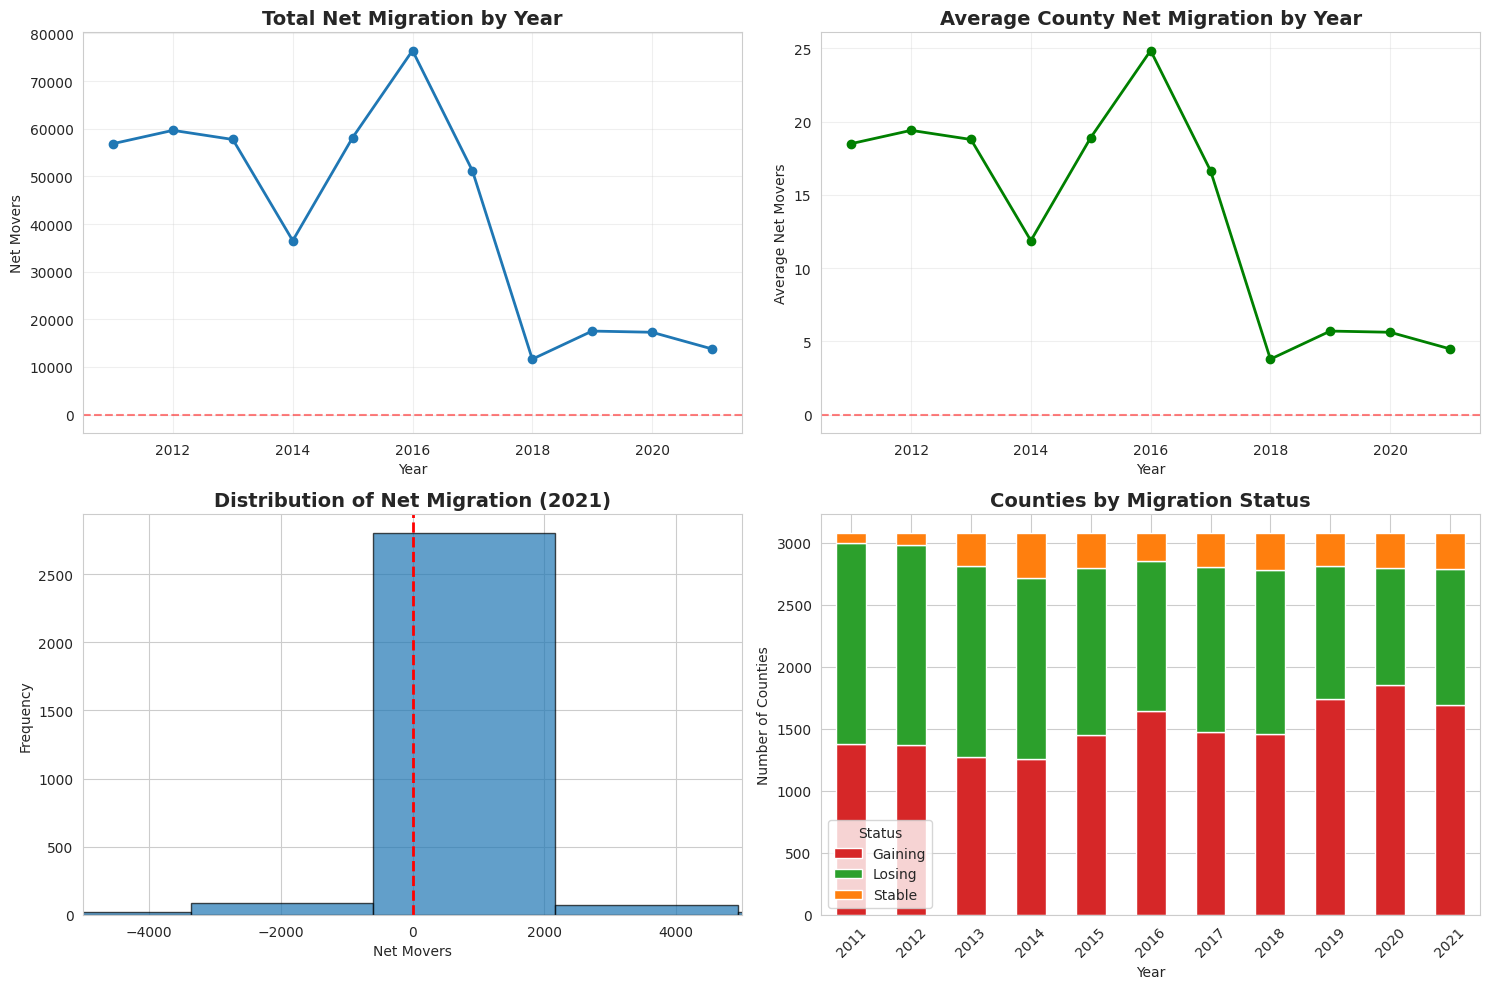


Counties gaining population: 16,587
Counties losing population: 14,561


In [11]:
# Net migration trends
print("="*30)
print("NET MIGRATION PATTERNS")
print("="*30)

# Annual net migration
annual_net = df.groupby('YEAR')['net_movers'].agg(['sum', 'mean', 'median', 'std'])
print("\nAnnual Net Migration Summary:")
print(annual_net)

# Plot 1: National net migration over time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total net migration by year
axes[0, 0].plot(annual_net.index, annual_net['sum'], marker='o', linewidth=2)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Total Net Migration by Year', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Net Movers')
axes[0, 0].grid(True, alpha=0.3)

# Average net migration by year
axes[0, 1].plot(annual_net.index, annual_net['mean'], marker='o', linewidth=2, color='green')
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Average County Net Migration by Year', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Average Net Movers')
axes[0, 1].grid(True, alpha=0.3)

# Distribution of net migration (2021)
df_2021 = df[df['YEAR'] == 2021]['net_movers'].dropna()
axes[1, 0].hist(df_2021, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title('Distribution of Net Migration (2021)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Net Movers')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(-5000, 5000)

# Winners vs Losers over time
df['migration_status'] = df['net_movers'].apply(
    lambda x: 'Gaining' if x > 0 else ('Losing' if x < 0 else 'Stable'))
status_counts = df.groupby(['YEAR', 'migration_status']).size().unstack(fill_value=0)
status_counts.plot(kind='bar', stacked=True, ax=axes[1, 1],
                   color=['#d62728', '#2ca02c', '#ff7f0e'])
axes[1, 1].set_title('Counties by Migration Status', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Counties')
axes[1, 1].legend(title='Status')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('migration_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nCounties gaining population: {(df['net_movers'] > 0).sum():,}")
print(f"Counties losing population: {(df['net_movers'] < 0).sum():,}")

RURAL-URBAN PATTERNS

Migration by RUCC Category:
           net_movers_mean  net_movers_median  net_movers_sum  \
RUCC_2013                                                       
1.000000           -390.16              316.0      -1772491.0   
2.000000            351.08               85.0       1436623.0   
3.000000             93.21               18.0        356822.0   
4.000000             76.86               14.0        179239.0   
5.000000            -52.65              -76.0        -52700.0   
6.000000             25.98               -1.0        168041.0   
7.000000            -12.75              -12.0        -59310.0   
7.586207          15085.36            26670.0        165939.0   
8.000000             15.89                0.0         38282.0   
9.000000             -0.82                0.0         -3668.0   

           total_population_mean  FIPS_nunique  
RUCC_2013                                       
1.000000               421329.50           413  
2.000000              

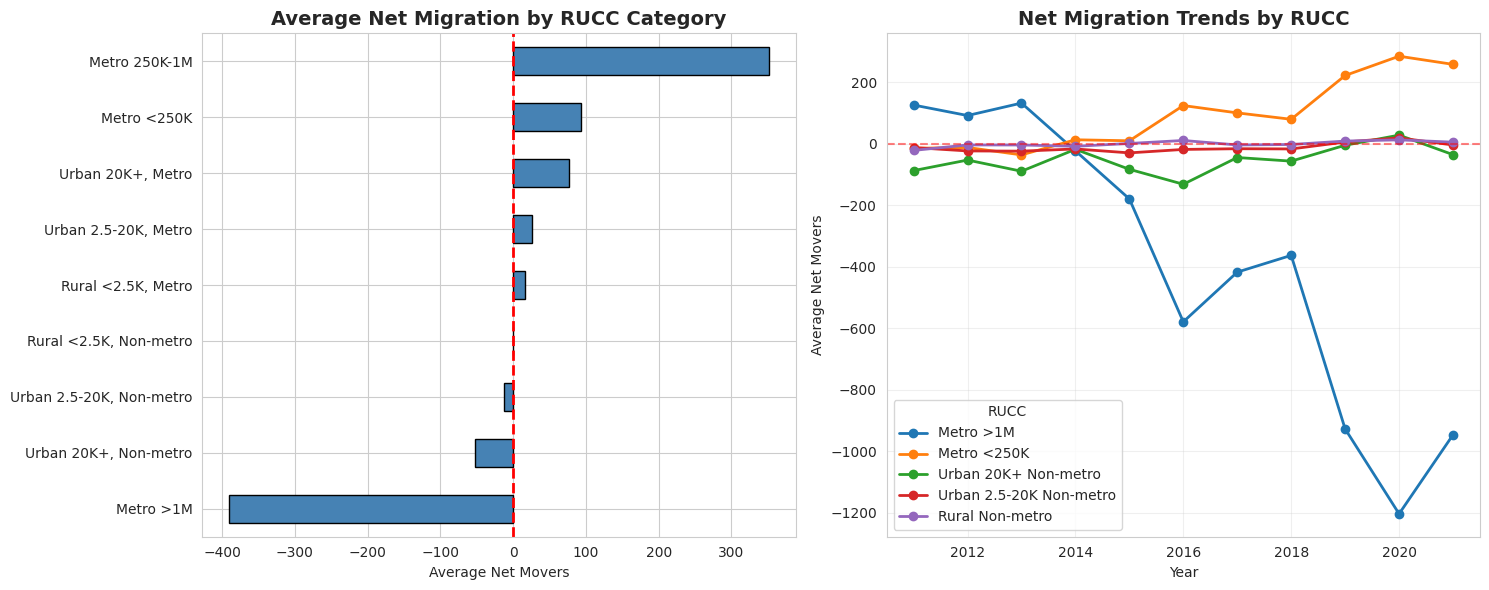

In [12]:
print("RURAL-URBAN PATTERNS")
print("="*30)

# RUCC categories
rucc_labels = {
    1: 'Metro >1M',
    2: 'Metro 250K-1M',
    3: 'Metro <250K',
    4: 'Urban 20K+, Metro',
    5: 'Urban 20K+, Non-metro',
    6: 'Urban 2.5-20K, Metro',
    7: 'Urban 2.5-20K, Non-metro',
    8: 'Rural <2.5K, Metro',
    9: 'Rural <2.5K, Non-metro'}

df['RUCC_label'] = df['RUCC_2013'].map(rucc_labels)

# Migration by RUCC
rucc_migration = df.groupby('RUCC_2013').agg({
    'net_movers': ['mean', 'median', 'sum'],
    'total_population': 'mean',
    'FIPS': 'nunique'}).round(2)
rucc_migration.columns = ['_'.join(col) for col in rucc_migration.columns]
print("\nMigration by RUCC Category:")
print(rucc_migration)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Average net migration by RUCC
rucc_avg = df.groupby('RUCC_label')['net_movers'].mean().sort_values()
rucc_avg.plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_title('Average Net Migration by RUCC Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Average Net Movers')
axes[0].set_ylabel('')

# RUCC over time
rucc_time = df.groupby(['YEAR', 'RUCC_2013'])['net_movers'].mean().unstack()
rucc_time[[1, 3, 5, 7, 9]].plot(ax=axes[1], marker='o', linewidth=2)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].set_title('Net Migration Trends by RUCC', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Net Movers')
axes[1].legend(title='RUCC', labels=['Metro >1M', 'Metro <250K', 'Urban 20K+ Non-metro',
                                      'Urban 2.5-20K Non-metro', 'Rural Non-metro'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rucc_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

ECONOMIC FACTORS

Correlation with Net Migration:
median_hh_income         0.007930
median_property_taxes    0.005660
unemploy_rate           -0.026579
BEA_pci                 -0.077488
RPP                     -0.085504
median_home_value       -0.159829
BEA_gdp                 -0.542229
Name: net_movers, dtype: float64


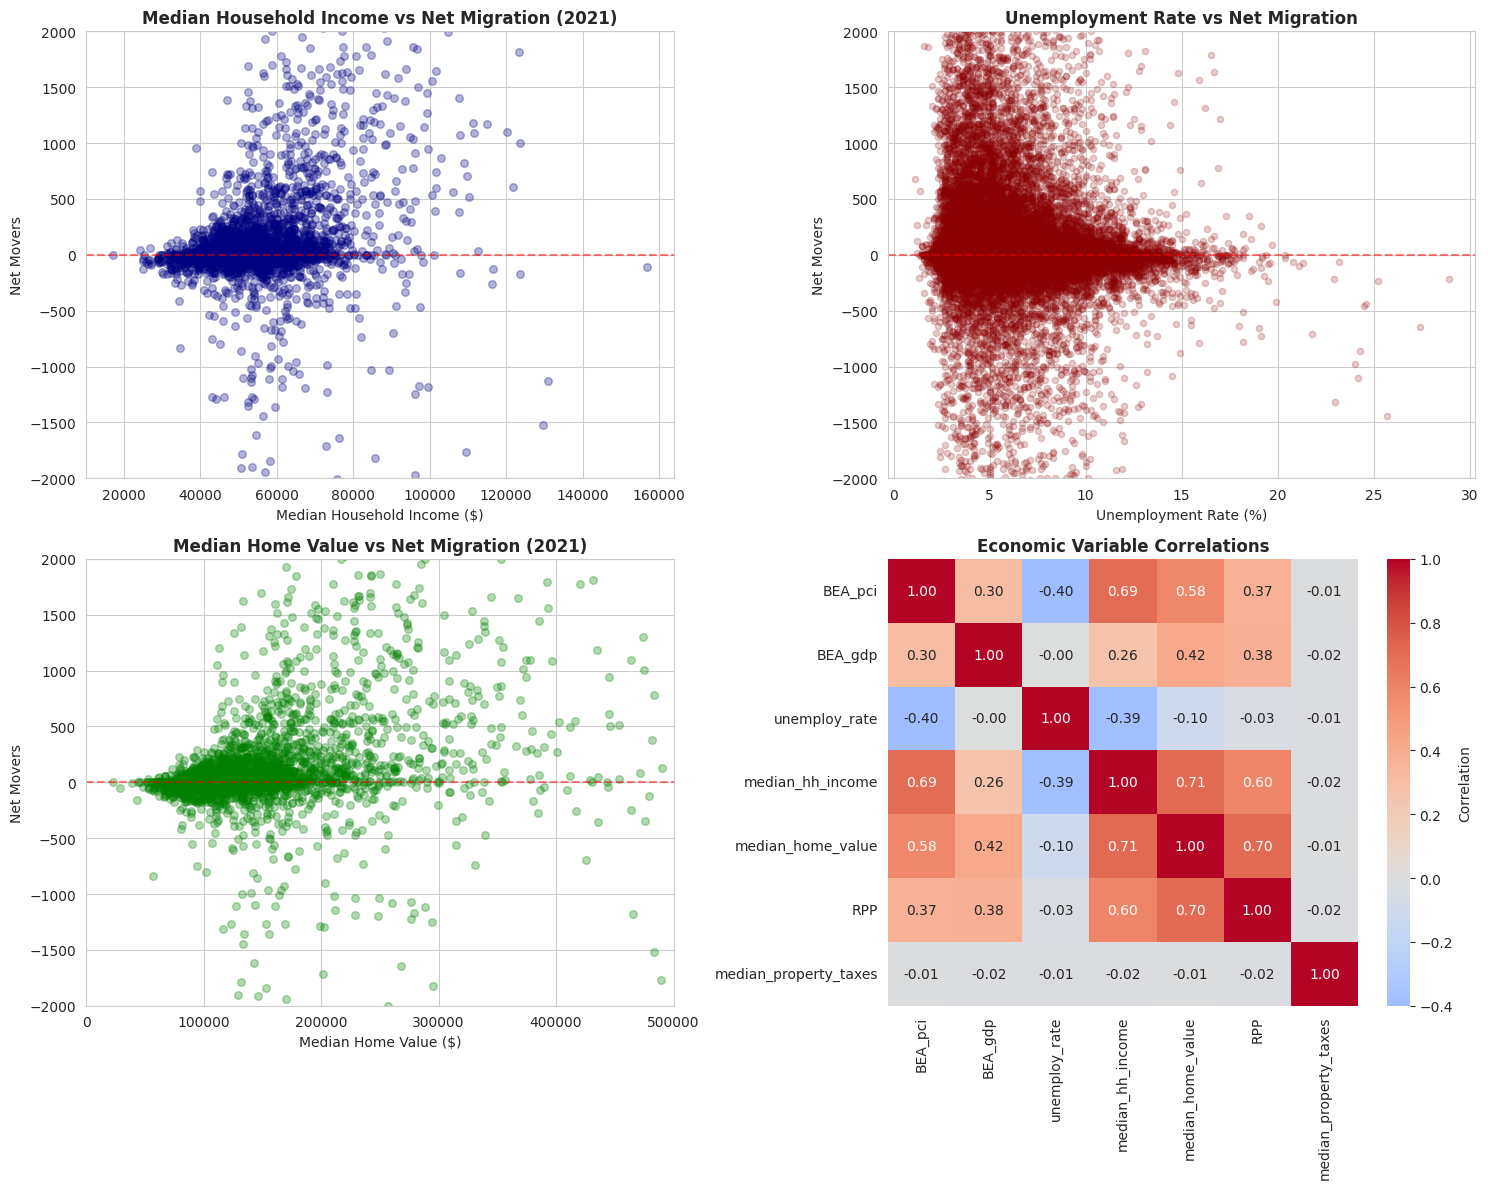

In [13]:
print("ECONOMIC FACTORS")
print("="*30)

# Correlations with net migration
econ_vars = ['BEA_pci', 'BEA_gdp', 'unemploy_rate', 'median_hh_income',
             'median_home_value', 'RPP', 'median_property_taxes']
migration_corr = df[econ_vars + ['net_movers']].corr()['net_movers'].drop('net_movers').sort_values(ascending=False)
print("\nCorrelation with Net Migration:")
print(migration_corr)

# Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Income vs migration (2021)
df_2021 = df[df['YEAR'] == 2021].dropna(subset=['median_hh_income', 'net_movers'])
axes[0, 0].scatter(df_2021['median_hh_income'], df_2021['net_movers'],
                   alpha=0.3, s=30, color='navy')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Median Household Income vs Net Migration (2021)',
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Median Household Income ($)')
axes[0, 0].set_ylabel('Net Movers')
axes[0, 0].set_ylim(-2000, 2000)

# Unemployment vs migration
df_unemp = df.dropna(subset=['unemploy_rate', 'net_movers'])
axes[0, 1].scatter(df_unemp['unemploy_rate'], df_unemp['net_movers'],
                   alpha=0.2, s=20, color='darkred')
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Unemployment Rate vs Net Migration',
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Unemployment Rate (%)')
axes[0, 1].set_ylabel('Net Movers')
axes[0, 1].set_ylim(-2000, 2000)

# Housing costs vs migration
df_housing = df[df['YEAR'] == 2021].dropna(subset=['median_home_value', 'net_movers'])
axes[1, 0].scatter(df_housing['median_home_value'], df_housing['net_movers'],
                   alpha=0.3, s=30, color='green')
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Median Home Value vs Net Migration (2021)',
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Median Home Value ($)')
axes[1, 0].set_ylabel('Net Movers')
axes[1, 0].set_xlim(0, 500000)
axes[1, 0].set_ylim(-2000, 2000)

# Correlation heatmap
corr_matrix = df[econ_vars].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=axes[1, 1], cbar_kws={'label': 'Correlation'})
axes[1, 1].set_title('Economic Variable Correlations', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('economic_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

GEOGRAPHIC PATTERNS

Top 10 States by Total Net Migration:
       net_movers  total_population  FIPS  net_per_capita
STATE                                                    
12      1225604.0     298428.789688    67         4106.86
48      1151191.0     106039.092699   254        10856.29
04       502360.0     449819.836364    15         1116.80
37       308855.0      99433.858182   100         3106.14
32       279869.0     167804.989305    17         1667.82
45       268487.0     105268.509881    46         2550.50
53       252875.0     182207.715618    39         1387.84
08       234411.0      83735.987216    64         2799.41
13       199769.0      63570.341338   159         3142.49
02       165939.0     728888.909091     1          227.66

Bottom 10 States by Total Net Migration:
       net_movers  total_population  FIPS  net_per_capita
STATE                                                    
11       -75582.0     654001.272727     1         -115.57
39       -96172.0     131905.

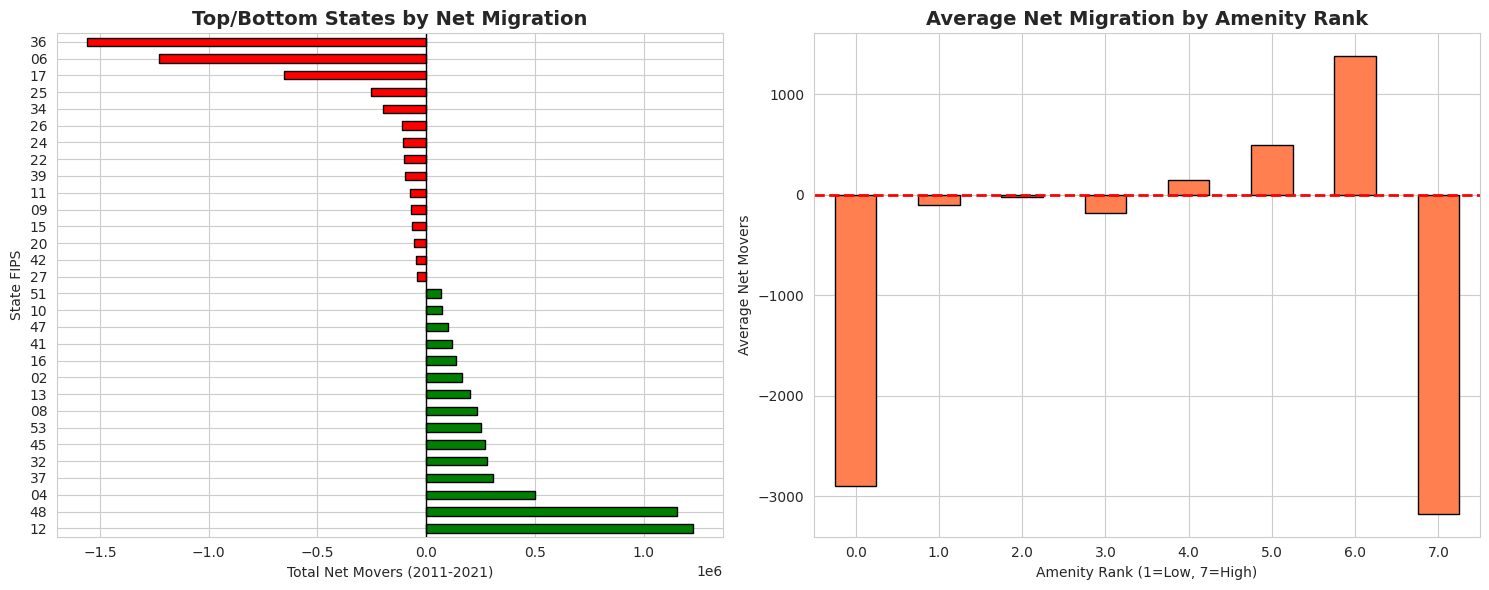

In [14]:
# ============================================================================
# EDA CELL 5: Geographic Patterns
# ============================================================================

print("="*30)
print("GEOGRAPHIC PATTERNS")
print("="*30)

# State-level aggregation
df['STATE'] = df['FIPS'].str[:2]

state_migration = df.groupby('STATE').agg({
    'net_movers': 'sum',
    'total_population': 'mean',
    'FIPS': 'nunique'}).sort_values('net_movers', ascending=False)
state_migration['net_per_capita'] = (
    state_migration['net_movers'] / state_migration['total_population'] * 1000).round(2)

print("\nTop 10 States by Total Net Migration:")
print(state_migration.head(10))

print("\nBottom 10 States by Total Net Migration:")
print(state_migration.tail(10))

# Amenity score analysis
amenity_migration = df.groupby('Amenity_rank').agg({
    'net_movers': ['mean', 'sum', 'count'],
    'total_population': 'mean'}).round(2)
amenity_migration.columns = ['_'.join(col) for col in amenity_migration.columns]
print("\nMigration by Amenity Rank:")
print(amenity_migration)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top/bottom states
top_bottom = pd.concat([state_migration.head(15), state_migration.tail(15)])
colors = ['green' if x > 0 else 'red' for x in top_bottom['net_movers']]
top_bottom['net_movers'].plot(kind='barh', ax=axes[0], color=colors, edgecolor='black')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[0].set_title('Top/Bottom States by Net Migration', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Net Movers (2011-2021)')
axes[0].set_ylabel('State FIPS')

# Amenity rank
amenity_avg = df.groupby('Amenity_rank')['net_movers'].mean().dropna()
amenity_avg.plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_title('Average Net Migration by Amenity Rank', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Amenity Rank (1=Low, 7=High)')
axes[1].set_ylabel('Average Net Movers')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('geographic_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

RELOCATION INCENTIVE PROGRAMS

Migration by Incentive Category:
               net_movers_mean  net_movers_median  net_movers_sum  \
Incentive_CAT                                                       
0.0                      -3.40                0.0       -101954.0   
1.0                     311.19                0.0        637619.0   
2.0                   -2503.81               33.0      -1084149.0   
3.0                     734.30               76.0       1005261.0   

               FIPS_nunique  total_population_mean  
Incentive_CAT                                       
0.0                    3075              100042.87  
1.0                     342               86597.61  
2.0                      79              281506.97  
3.0                     234              138827.78  


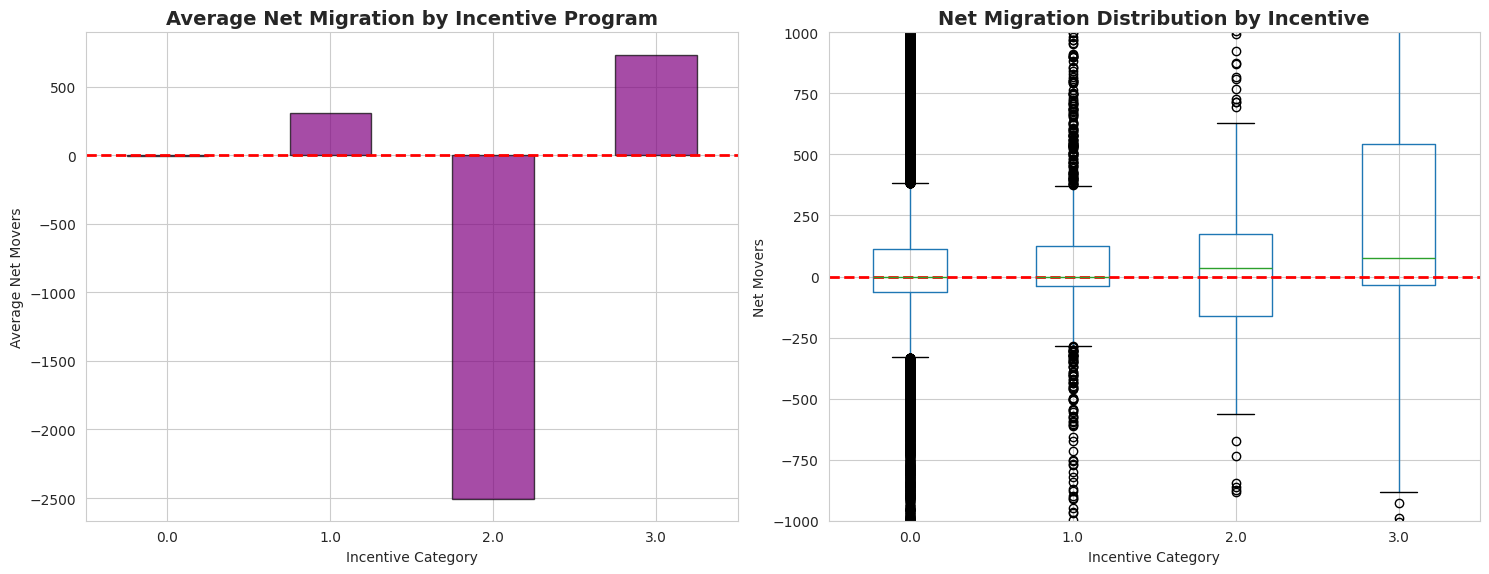

In [15]:
# ============================================================================
# EDA CELL 6: Incentive Program Analysis
# ============================================================================

print("="*30)
print("RELOCATION INCENTIVE PROGRAMS")
print("="*30)

incentive_summary = df.groupby('Incentive_CAT').agg({
    'net_movers': ['mean', 'median', 'sum'],
    'FIPS': 'nunique',
    'total_population': 'mean'}).round(2)
incentive_summary.columns = ['_'.join(col) for col in incentive_summary.columns]
print("\nMigration by Incentive Category:")
print(incentive_summary)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Average net migration by incentive
df.groupby('Incentive_CAT')['net_movers'].mean().plot(
    kind='bar', ax=axes[0], color='purple', edgecolor='black', alpha=0.7)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_title('Average Net Migration by Incentive Program',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Incentive Category')
axes[0].set_ylabel('Average Net Movers')
axes[0].tick_params(axis='x', rotation=0)

# Distribution comparison
df.boxplot(column='net_movers', by='Incentive_CAT', ax=axes[1])
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_title('Net Migration Distribution by Incentive', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Incentive Category')
axes[1].set_ylabel('Net Movers')
axes[1].set_ylim(-1000, 1000)
plt.suptitle('')

plt.tight_layout()
plt.savefig('incentive_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlations

CORRELATION ANALYSIS SETUP

Original numeric columns: 86
After dropping: 57

Variables for correlation analysis:
   1. %asian
   2. %black
   3. %divorced_female
   4. %divorced_male
   5. %hispanic
   6. %mixed_non_h
   7. %native
   8. %never_married_female
   9. %never_married_male
  10. %now_married_female
  11. %now_married_male
  12. %other_race
  13. %owner_occupied
  14. %pacific_islander
  15. %renter_occupied
  16. %white
  17. %widowed_female
  18. %widowed_male
  19. Amenity_rank
  20. Amenity_score
  21. BEA_gdp
  22. BEA_pci
  23. Farming
  24. Govt
  25. Mfging
  26. Mgmt_Biz_Sci_Arts
  27. Mining
  28. Nat-rsrc_Constr_Maint
  29. Nonspec
  30. Prod_Transp_Mvng
  31. RPP
  32. Rec
  33. Sales_Admin
  34. Services
  35. associates
  36. bachelors
  37. complete_hs
  38. doctorate
  39. employed
  40. family_households
  41. housing_total
  42. masters
  43. median_age
  44. median_hh_income
  45. median_home_value
  46. median_property_taxes
  47. net_agi
  48. net_movers

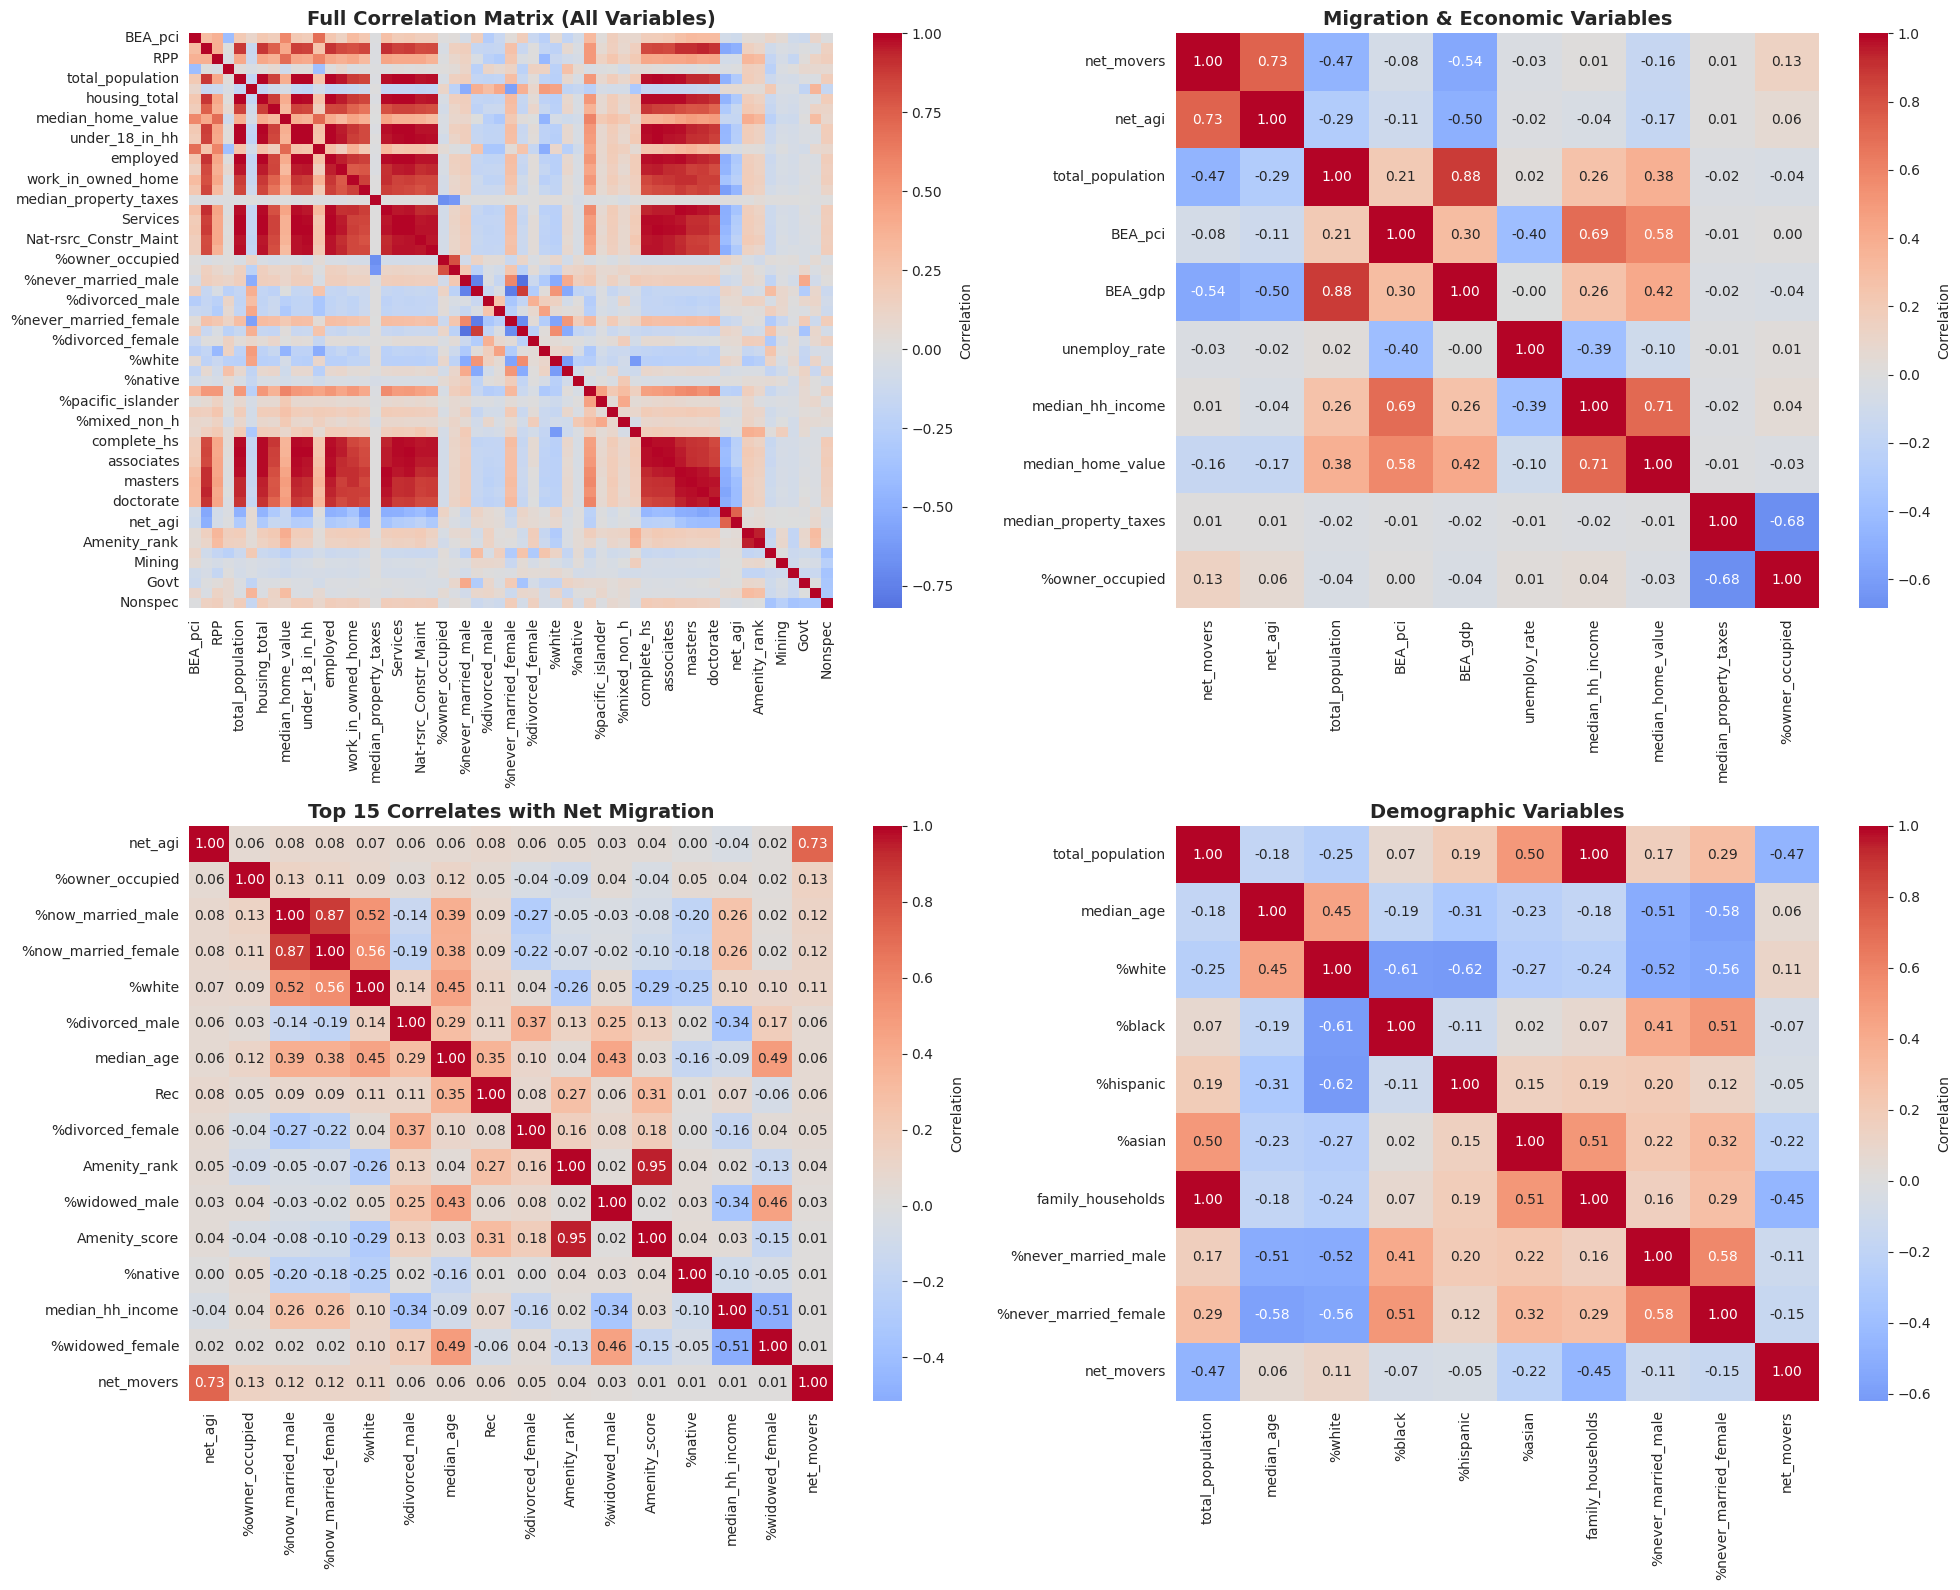

✓ Saved correlation_analysis.png
✓ Saved correlation_matrix.csv

SUMMARY: MIGRATION CORRELATIONS
           Variable  Correlation
            net_agi         0.73
    %owner_occupied         0.13
  %now_married_male         0.12
%now_married_female         0.12
             %white         0.11
     %divorced_male         0.06
         median_age         0.06
                Rec         0.06
   %divorced_female         0.05
       Amenity_rank         0.04
      %widowed_male         0.03
      Amenity_score         0.01
            %native         0.01
   median_hh_income         0.01
    %widowed_female         0.01


In [40]:
# Load panel data
panel_df = pd.read_csv('migration_panel.csv', dtype={'FIPS': str})

print("="*30)
print("CORRELATION ANALYSIS SETUP")
print("="*30)

# Drop variables before correlation
drop_vars = [
    # Population duplicates
    'POP_2010', 'POP_2020',

    # Industry type (redundant with categorical dummies)
    'Industry_type',

    # Commute variables (too granular)
    'commute_less_5min', 'commute_5_9min', 'commute_10_14min',
    'commute_15_19min', 'commute_20_24min', 'commute_25_29min',
    'commute_30_34min', 'commute_35_39min', 'commute_40_44min',
    'commute_45_59min', 'commute_60_89min', 'commute_90_plus_min',

    # Binary county type indicators (for regression, not correlation)
    'Low_Ed_cnty', 'Low_emp_cnty', 'Pop_Loss_2010', 'Retire_dest_cnty',
    'Persistent_Pov_cnty', 'Pers_chld_pov_cnty',

    # Categorical variables
    'Incentive_CAT', 'RUCC_2013', 'RUCC_2023',

    # Totals (redundant with components)
    'occupation_total', 'not_in_labor_force', 'education_total_sex',
    'marital_total',

    # Identifiers
    'FIPS', 'YEAR']

# Get numeric columns only
numeric_cols = panel_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove drop variables
corr_vars = [col for col in numeric_cols if col not in drop_vars]

print(f"\nOriginal numeric columns: {len(numeric_cols)}")
print(f"After dropping: {len(corr_vars)}")
print(f"\nVariables for correlation analysis:")
for i, var in enumerate(sorted(corr_vars), 1):
    print(f"  {i:2d}. {var}")

# Calculate correlation matrix
print("\n" + "="*30)
print("CALCULATING CORRELATIONS")
print("="*30)

corr_matrix = panel_df[corr_vars].corr()
print(f"Correlation matrix shape: {corr_matrix.shape}")

# High correlations with migration
print("\nTop 20 Correlations with net_movers:")
net_movers_corr = corr_matrix['net_movers'].sort_values(ascending=False)
print(net_movers_corr.drop('net_movers').head(20))

print("\nBottom 20 (Negative) Correlations with net_movers:")
print(net_movers_corr.tail(20))

# Find highly correlated pairs (potential multicollinearity)
print("\n" + "="*30)
print("HIGH CORRELATION PAIRS (|r| > 0.8)")
print("="*30)

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]})

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values(
        'correlation', ascending=False, key=abs)
    print(high_corr_df.to_string(index=False))
else:
    print("No variable pairs with |r| > 0.8")

# Visualize correlation matrix
print("\n" + "="*30)
print("CREATING VISUALIZATIONS")
print("="*30)

# Full correlation heatmap (condensed)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Full heatmap (small annotations)
sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
            annot=False, fmt='.2f', ax=axes[0, 0],
            cbar_kws={'label': 'Correlation'})
axes[0, 0].set_title('Full Correlation Matrix (All Variables)',
                     fontsize=14, fontweight='bold')

# 2. Migration-related variables only
migration_vars = ['net_movers', 'net_agi', 'total_population',
                  'BEA_pci', 'BEA_gdp', 'unemploy_rate',
                  'median_hh_income', 'median_home_value',
                  'median_property_taxes', '%owner_occupied']
migration_vars = [v for v in migration_vars if v in corr_matrix.columns]

migration_corr = corr_matrix.loc[migration_vars, migration_vars]
sns.heatmap(migration_corr, cmap='coolwarm', center=0,
            annot=True, fmt='.2f', ax=axes[0, 1],
            cbar_kws={'label': 'Correlation'})
axes[0, 1].set_title('Migration & Economic Variables',
                     fontsize=14, fontweight='bold')

# 3. Top correlates with net_movers
top_vars = net_movers_corr.drop('net_movers').head(15).index.tolist() + ['net_movers']
top_corr = corr_matrix.loc[top_vars, top_vars]
sns.heatmap(top_corr, cmap='coolwarm', center=0,
            annot=True, fmt='.2f', ax=axes[1, 0],
            cbar_kws={'label': 'Correlation'})
axes[1, 0].set_title('Top 15 Correlates with Net Migration',
                     fontsize=14, fontweight='bold')

# 4. Demographic variables
demo_vars = ['total_population', 'median_age', '%white', '%black',
             '%hispanic', '%asian', 'family_households',
             '%never_married_male', '%never_married_female',
             'net_movers']
demo_vars = [v for v in demo_vars if v in corr_matrix.columns]

demo_corr = corr_matrix.loc[demo_vars, demo_vars]
sns.heatmap(demo_corr, cmap='coolwarm', center=0,
            annot=True, fmt='.2f', ax=axes[1, 1],
            cbar_kws={'label': 'Correlation'})
axes[1, 1].set_title('Demographic Variables',
                     fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved correlation_analysis.png")

# Export correlation matrix
corr_matrix.to_csv('correlation_matrix.csv')
print("✓ Saved correlation_matrix.csv")

# Summary table for key relationships
print("\n" + "="*30)
print("SUMMARY: MIGRATION CORRELATIONS")
print("="*30)

summary = pd.DataFrame({
    'Variable': net_movers_corr.drop('net_movers').head(15).index,
    'Correlation': net_movers_corr.drop('net_movers').head(15).values})
print(summary.to_string(index=False))

In [41]:
# CREATE COMPOSITE VARIABLES & REDUCE MULTICOLLINEARITY
comp_df = pd.read_csv('migration_panel.csv', dtype={'FIPS': str})
# Education Composites
comp_df['college_degree'] = (comp_df['bachelors'].fillna(0) +
                      comp_df['masters'].fillna(0) +
                      comp_df['professional'].fillna(0) +
                      comp_df['doctorate'].fillna(0))

# HS through Associate's
comp_df['hs_some_college'] = (comp_df['complete_hs'].fillna(0) +
                         comp_df['some_college'].fillna(0) +
                         comp_df['associates'].fillna(0))

# Occupation Percentages
comp_df['%white_collar'] = (comp_df['Mgmt_Biz_Sci_Arts'] /
                          comp_df['occupation_total'] * 100).round(2)
comp_df['%blue_collar'] = ((comp_df['Nat-rsrc_Constr_Maint'].fillna(0) +
                          comp_df['Prod_Transp_Mvng'].fillna(0)) /
                         comp_df['occupation_total'] * 100).round(2)

# MULTICOLLINEARITY DROP LIST
multicollinear_drops = [
# Size proxies (keep total_population)
    'family_households', 'employed', 'housing_total',
    'unemployed', 'under_18_in_hh',
# Individual education levels (replaced by composites)
    'complete_hs', 'some_college', 'associates',
    'bachelors', 'masters', 'professional', 'doctorate',
# All occupation categories (replaced by % composites)
    'Mgmt_Biz_Sci_Arts', 'Services', 'Sales_Admin',
    'Nat-rsrc_Constr_Maint', 'Prod_Transp_Mvng', 'occupation_total',
# Work location
    'work_in_owned_home', 'work_in_rental',
    # Amenity rank (keep score)
    'Amenity_rank',
# Renter occupied (keep owner)
    '%renter_occupied',
# Female marriage vars (keep male)
    '%never_married_female', '%now_married_female',
    '%divorced_female', '%widowed_female']

print(f"\nTotal variables to drop: {len(multicollinear_drops)}")
for var in sorted(multicollinear_drops):
    print(f"  - {var}")


# RE-RUN CORRELATION ANALYSIS WITH REDUCED VARIABLES
# ======================================================================
print("CORRELATION ANALYSIS (REDUCED VARIABLES)")
print("="*30)

# All drop variables combined
all_drops = [
# Population duplicates
    'POP_2010', 'POP_2020',
# Industry type (redundant with categorical dummies)
    'Industry_type',
# Commute variables
    'commute_less_5min', 'commute_5_9min', 'commute_10_14min',
    'commute_15_19min', 'commute_20_24min', 'commute_25_29min',
    'commute_30_34min', 'commute_35_39min', 'commute_40_44min',
    'commute_45_59min', 'commute_60_89min', 'commute_90_plus_min',
# Binary indicators
    'Low_Ed_cnty', 'Low_emp_cnty', 'Pop_Loss_2010', 'Retire_dest_cnty',
    'Persistent_Pov_cnty', 'Pers_chld_pov_cnty',
# Categorical
    'Incentive_CAT', 'RUCC_2013', 'RUCC_2023',
# Totals
    'not_in_labor_force', 'education_total_sex', 'marital_total',
# Identifiers
    'FIPS', 'YEAR'] + multicollinear_drops
# Get numeric columns
numeric_cols = comp_df.select_dtypes(include=[np.number]).columns.tolist()
corr_vars = [col for col in numeric_cols if col not in all_drops]

print(f"\nVariables for correlation: {len(corr_vars)}")
for i, var in enumerate(sorted(corr_vars), 1):
    print(f"  {i:2d}. {var}")

# Calculate correlations
CORR_matrix = comp_df[corr_vars].corr()

print(f"\nCorrelation matrix: {CORR_matrix.shape}")
# Check for remaining high correlations
print("\n")
print("REMAINING HIGH CORRELATIONS (|r| > 0.8)")
print("="*30)

high_corr = []
for i in range(len(CORR_matrix.columns)):
    for j in range(i+1, len(CORR_matrix.columns)):
        if abs(CORR_matrix.iloc[i, j]) > 0.8:
            high_corr.append({
                'var1': CORR_matrix.columns[i],
                'var2': CORR_matrix.columns[j],
                'correlation': CORR_matrix.iloc[i, j]})

if high_corr:
    high_corr_df = pd.DataFrame(high_corr).sort_values(
        'correlation', ascending=False, key=abs)
    print(high_corr_df.to_string(index=False))
    print(f"\nTotal pairs: {len(high_corr)}")
else:
    print("✓ No remaining variable pairs with |r| > 0.8")

# Top correlates with migration
print("TOP CORRELATIONS WITH NET_MOVERS")
print("="*30)

if 'net_movers' in CORR_matrix.columns:
    net_corr = CORR_matrix['net_movers'].sort_values(ascending=False)
    print("\nTop 15 Positive:")
    print(net_corr.drop('net_movers').head(15))

    print("\nTop 15 Negative:")
    print(net_corr.tail(15))

# Save
comp_df.to_csv('comp_df.csv', index=False)
CORR_matrix.to_csv('CORR_matrix_reduced.csv')
print(f"\n Saved CORR_matrix_reduced.csv")
print(CORR_matrix.info())


Total variables to drop: 26
  - %divorced_female
  - %never_married_female
  - %now_married_female
  - %renter_occupied
  - %widowed_female
  - Amenity_rank
  - Mgmt_Biz_Sci_Arts
  - Nat-rsrc_Constr_Maint
  - Prod_Transp_Mvng
  - Sales_Admin
  - Services
  - associates
  - bachelors
  - complete_hs
  - doctorate
  - employed
  - family_households
  - housing_total
  - masters
  - occupation_total
  - professional
  - some_college
  - under_18_in_hh
  - unemployed
  - work_in_owned_home
  - work_in_rental
CORRELATION ANALYSIS (REDUCED VARIABLES)

Variables for correlation: 36
   1. %asian
   2. %black
   3. %blue_collar
   4. %divorced_male
   5. %hispanic
   6. %mixed_non_h
   7. %native
   8. %never_married_male
   9. %now_married_male
  10. %other_race
  11. %owner_occupied
  12. %pacific_islander
  13. %white
  14. %white_collar
  15. %widowed_male
  16. Amenity_score
  17. BEA_gdp
  18. BEA_pci
  19. Farming
  20. Govt
  21. Mfging
  22. Mining
  23. Nonspec
  24. RPP
  25. Rec
  

## Pearson Correlation Matrix

In [42]:
# Compute Pearson correlation matrix
pearson_corr_matrix = movers_num.corr(method='pearson')

# Get correlations with net_movers
if 'net_movers' in pearson_corr_matrix.columns:
    pearson_net_movers = pearson_corr_matrix['net_movers'].sort_values(
        ascending=False).drop('net_movers')

    print('\nTop 20 Positive Correlations:')
    print(pearson_net_movers.head(20))

    print('\nTop 20 Negative Correlations:')
    print(pearson_net_movers.tail(20))


Top 20 Positive Correlations:
net_agi               0.73
Retire_dest_cnty      0.15
%owner_occupied       0.13
%now_married_male     0.12
%now_married_female   0.12
%white                0.11
%divorced_male        0.06
median_age            0.06
Rec                   0.06
%divorced_female      0.05
Industry_type         0.04
Amenity_rank          0.04
%widowed_male         0.03
Incentive_CAT         0.02
Amenity_score         0.01
%native               0.01
RUCC_2023             0.01
RUCC_2013             0.01
median_hh_income      0.01
%widowed_female       0.01
Name: net_movers, dtype: float64

Top 20 Negative Correlations:
education_total_sex   -0.48
POP_2020              -0.49
POP_2010              -0.49
employed              -0.49
occupation_total      -0.49
commute_35_39min      -0.49
Services              -0.50
Prod_Transp_Mvng      -0.50
Mgmt_Biz_Sci_Arts     -0.50
bachelors             -0.51
doctorate             -0.51
masters               -0.51
commute_30_34min      -0.51
c

## Spearman Correlation Matrix

In [43]:
# Compute Spearman correlation matrix
spearman_corr_matrix = movers_num.corr(method='spearman')

# Get correlations with net_movers
if 'net_movers' in spearman_corr_matrix.columns:
    spearman_net_movers = spearman_corr_matrix['net_movers'].sort_values(
        ascending=False).drop('net_movers')

    print('\nTop 20 Positive Correlations:')
    print(spearman_net_movers.head(20))

    print('\nTop 20 Negative Correlations:')
    print(spearman_net_movers.tail(20))


Top 20 Positive Correlations:
net_agi                 0.79
Retire_dest_cnty        0.31
median_hh_income        0.30
median_home_value       0.29
%owner_occupied         0.26
%now_married_female     0.24
RPP                     0.23
%now_married_male       0.22
commute_45_59min        0.21
commute_40_44min        0.21
work_in_owned_home      0.21
commute_35_39min        0.21
commute_60_89min        0.20
median_property_taxes   0.19
commute_90_plus_min     0.18
commute_30_34min        0.17
BEA_pci                 0.17
median_age              0.17
commute_25_29min        0.17
bachelors               0.16
Name: net_movers, dtype: float64

Top 20 Negative Correlations:
%native                  0.01
Industry_type           -0.02
%widowed_male           -0.02
Mfging                  -0.03
Farming                 -0.05
%black                  -0.05
Mining                  -0.07
Low_emp_cnty            -0.08
unemploy_rate           -0.10
Govt                    -0.11
%widowed_female         -

## Chatterjee's Correlation  
In 2020, a paper titled 'A New Coefficient of Correlation' introduced a new coefficient measure ξ (“Xi”) which measures how much the dependent variable is a function of the independent. The result equals 0 if the two variables are independent and will be closer to 1 as the relationship strengthens. Also includes some theoretical properties that allow for hypothesis testing prior to making assumptions about the data.  

Along with the article, the R package 'XICOR' was released which contains the function xicor() which calculates ξ when X and Y vectors or matrices are provided (provides p-values for hypothesis testing).

S. Chatterjee, *A New Coefficient of Correlation* (2020), Journal of the American Statistical Association.
https://doi.org/10.48550/arXiv.1909.10140

The below code is a python xicor function based on one written by Tim Sumner https://medium.com/data-science/a-new-coefficient-of-correlation-64ae4f260310

In [44]:
# =======================================================================
# CHATTERJEE'S XI CORRELATION WITH NET_MOVERS
# =======================================================================

def xicor(X, Y, ties='auto', return_p=True):
    """Calculate Chatterjee's correlation coefficient"""
    np.random.seed(1)
    X = np.asarray(X)
    Y = np.asarray(Y)

    # Remove NaN pairs
    mask = ~(np.isnan(X) | np.isnan(Y))
    X = X[mask]
    Y = Y[mask]

    if len(X) < 10:  # Need minimum observations
        return (np.nan, np.nan) if return_p else np.nan

    Y_sorted = Y[np.argsort(X)]
    n = len(X)

    if ties == 'auto':
        ties = len(np.unique(Y)) < n

    if ties:
        r = rankdata(Y_sorted, method='ordinal')
        l = rankdata(Y_sorted, method='max')
        xi = 1 - n * np.sum(np.abs(np.diff(r))) / (2 * np.sum(l * (n - l)))
    else:
        r = rankdata(Y_sorted, method='ordinal')
        xi = 1 - 3 * np.sum(np.abs(np.diff(r))) / (n**2 - 1)

    # p-value approximation
    p_value = norm.sf(xi, scale=2/5/np.sqrt(n))

    if return_p:
        return xi, p_value
    else:
        return xi

# Define features (exclude identifiers and target)
exclude_cols = ['FIPS', 'YEAR', 'net_movers', 'net_agi'] + all_drops
features = [col for col in comp_df.columns if col not in exclude_cols
            and comp_df[col].dtype in [np.float64, np.int64]]

print("="*30)
print("CHATTERJEE'S XI CORRELATION WITH NET_MOVERS")
print("="*30)
print(f"\nAnalyzing {len(features)} features")

# Calculate xi for each feature
xi_results = {}
target = comp_df['net_movers'].dropna()

for feature in features:
    # Get overlapping non-null observations
    data = comp_df[[feature, 'net_movers']].dropna()

    if len(data) < 10:
        continue

    xi_stat, xi_p = xicor(data[feature], data['net_movers'])
    xi_results[feature] = {
        'xi_statistic': xi_stat,
        'p_value': xi_p,
        'n_obs': len(data),
        'significant': 'Yes' if xi_p < 0.05 else 'No'}

# Create results dataframe
xi_df = pd.DataFrame.from_dict(xi_results, orient='index')
xi_df = xi_df.sort_values('xi_statistic', ascending=False)

print("\n" + "="*30)
print("TOP 20 FEATURES BY XI CORRELATION")
print("="*30)
print(xi_df.head(20).to_string())

print("\n" + "="*30)
print("BOTTOM 20 FEATURES BY XI CORRELATION")
print("="*30)
print(xi_df.tail(20).to_string())

# Significant relationships only
sig_results = xi_df[xi_df['p_value'] < 0.05]
print(f"\n" + "="*30)
print(f"SIGNIFICANT RELATIONSHIPS (p < 0.05): {len(sig_results)}/{len(xi_df)}")
print("="*30)
print(sig_results.to_string())

# Save results
xi_df.to_csv('chatterjee_correlation_results.csv')
print(f"\n✓ Saved chatterjee_correlation_results.csv")

# Compare with Pearson correlation
print("\n" + "="*30)
print("COMPARISON: XI vs PEARSON CORRELATION")
print("="*30)

pearson_corr = comp_df[features + ['net_movers']].corr()['net_movers'].drop('net_movers')
comparison = pd.DataFrame({
    'Xi_Correlation': xi_df['xi_statistic'],
    'Pearson_Correlation': pearson_corr})
comparison = comparison.sort_values('Xi_Correlation', ascending=False)

print("\nTop 10 by Xi (may differ from Pearson):")
print(comparison.head(10))

# Find non-linear relationships (high Xi, low Pearson)
comparison['difference'] = abs(comparison['Xi_Correlation']) - abs(comparison['Pearson_Correlation'])
nonlinear = comparison.nlargest(10, 'difference')

print("\n" + "="*30)
print("POTENTIAL NON-LINEAR RELATIONSHIPS")
print("(High Xi, Low Pearson suggests non-linearity)")
print("="*30)
print(nonlinear)

CHATTERJEE'S XI CORRELATION WITH NET_MOVERS

Analyzing 34 features

TOP 20 FEATURES BY XI CORRELATION
                   xi_statistic  p_value  n_obs significant
Mining                     0.43     0.00  33825         Yes
Mfging                     0.43     0.00  33825         Yes
Farming                    0.42     0.00  33825         Yes
Govt                       0.42     0.00  33825         Yes
Rec                        0.42     0.00  33825         Yes
Nonspec                    0.42     0.00  33825         Yes
Amenity_score              0.33     0.00  33825         Yes
total_population           0.14     0.00  33825         Yes
college_degree             0.14     0.00  33825         Yes
hs_some_college            0.14     0.00  33825         Yes
RPP                        0.14     0.00  33825         Yes
BEA_gdp                    0.12     0.00  33825         Yes
median_home_value          0.11     0.00  33825         Yes
%pacific_islander          0.11     0.00  33825         Ye

## Compare Correlation Coefficients

In [45]:
# Combine all correlation results into a single DataFrame
correlation_comparison = pd.DataFrame({
    'Xi_Correlation': xi_df['xi_statistic'],
    'Xi_pvalue': xi_df['p_value'],
    'Pearson': pearson_net_movers,
    'Spearman': spearman_net_movers})

# Sort by Xi correlation
correlation_comparison = correlation_comparison.sort_values(
    'Xi_Correlation', ascending=False)

print('='*60)
print('CORRELATION COMPARISON: Xi vs Pearson vs Spearman')
print('='*60)
print(correlation_comparison.round(4))

# Identify non-linear relationships (high Xi, low Pearson)
correlation_comparison['nonlinear_signal'] = (
    abs(correlation_comparison['Xi_Correlation']) -
    abs(correlation_comparison['Pearson']))

print('\n' + '='*60)
print('POTENTIAL NON-LINEAR RELATIONSHIPS')
print('(High Xi, Low Pearson difference)')
print('='*60)
nonlinear_vars = correlation_comparison.nlargest(10, 'nonlinear_signal')
print(nonlinear_vars)

# Save results
correlation_comparison.to_csv('correlation_comparison_net_movers.csv')
print('\n Saved correlation_comparison_net_movers.csv')

CORRELATION COMPARISON: Xi vs Pearson vs Spearman
                    Xi_Correlation  Xi_pvalue  Pearson  Spearman
Mining                        0.43       0.00    -0.01     -0.07
Mfging                        0.43       0.00     0.00     -0.03
Farming                       0.42       0.00    -0.00     -0.05
Govt                          0.42       0.00    -0.02     -0.11
Rec                           0.42       0.00     0.06      0.14
...                            ...        ...      ...       ...
some_college                   NaN        NaN    -0.40      0.15
under_18_in_hh                 NaN        NaN    -0.44      0.12
unemployed                     NaN        NaN    -0.46      0.08
work_in_owned_home             NaN        NaN    -0.36      0.21
work_in_rental                 NaN        NaN    -0.60      0.14

[89 rows x 4 columns]

POTENTIAL NON-LINEAR RELATIONSHIPS
(High Xi, Low Pearson difference)
                   Xi_Correlation  Xi_pvalue  Pearson  Spearman  \
Farming   

# Statistical tests

## The Mann-Whitney U Test  
Ideal for migration data--it does not assume normality and is robust to outliers (NYC, LA, etc).  
Results show which features significantly differ between gaining and losing counties.  
Effect Sizes: How large those differences are (practical significance)

In [47]:
print('='*60)
print('MANN-WHITNEY U TEST')
print('Non-parametric test for difference in distributions')
print('H0: No difference between Gaining and Losing counties')
print('='*60)

mannwhitney_results = {}

for feature in features_for_norm:
    data_gaining = group_gaining[feature].dropna()
    data_losing = group_losing[feature].dropna()

    if len(data_gaining) > 0 and len(data_losing) > 0:
        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(
            data_gaining, data_losing,
            alternative='two-sided')

        # Calculate medians for interpretation
        median_gaining = data_gaining.median()
        median_losing = data_losing.median()
        median_diff = median_gaining - median_losing

        # Effect size (rank-biserial correlation)
        n1 = len(data_gaining)
        n2 = len(data_losing)
        effect_size = 1 - (2*stat) / (n1 * n2)

        mannwhitney_results[feature] = {
            'U_statistic': stat,
            'p_value': p_value,
            'Median_Gaining': median_gaining,
            'Median_Losing': median_losing,
            'Median_Diff': median_diff,
            'Effect_Size': effect_size,
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'Direction': 'Gaining > Losing' if median_diff > 0 else 'Losing > Gaining'}
    else:
        mannwhitney_results[feature] = {
            'U_statistic': None,
            'p_value': None,
            'Median_Gaining': None,
            'Median_Losing': None,
            'Median_Diff': None,
            'Effect_Size': None,
            'Significant': 'N/A',
            'Direction': 'N/A'}

# Convert to DataFrame
mannwhitney_df = pd.DataFrame(mannwhitney_results).T

# Sort by p-value (most significant first)
mannwhitney_df = mannwhitney_df.sort_values('p_value')

print('\nMann-Whitney U Test Results:')
print(mannwhitney_df.round(4))

# Significant differences
significant = mannwhitney_df[mannwhitney_df['Significant'] == 'Yes']
print(f'\n' + '='*60)
print(f'SIGNIFICANT DIFFERENCES (p < 0.05)')
print('='*60)
print(f"Found {len(significant)}/{len(mannwhitney_df)} features with significant differences")
print('\nTop 20 Most Significant:')
print(significant.head(20).round(4))

# Interpret effect sizes
print('\n' + '='*60)
print('EFFECT SIZE INTERPRETATION')
print('='*60)
print('Small: |r| < 0.3')
print('Medium: 0.3 ≤ |r| < 0.5')
print('Large: |r| ≥ 0.5')

large_effects = significant[abs(significant['Effect_Size']) >= 0.5]
print(f'\nFeatures with LARGE effect sizes: {len(large_effects)}')
if len(large_effects) > 0:
    print(large_effects[['Median_Gaining', 'Median_Losing', 'Effect_Size', 'Direction']])

# Save results
mannwhitney_df.to_csv('mannwhitney_test_results.csv')
print('\n✓ Saved mannwhitney_test_results.csv')

MANN-WHITNEY U TEST
Non-parametric test for difference in distributions
H0: No difference between Gaining and Losing counties

Mann-Whitney U Test Results:
                     U_statistic p_value Median_Gaining Median_Losing  \
median_hh_income    156631300.00    0.00       50734.00      44643.00   
%owner_occupied     152334569.50    0.00          74.45         71.32   
%renter_occupied     89224312.50    0.00          25.55         28.68   
Retire_dest_cnty    140970716.00    0.00           0.00          0.00   
%now_married_female 151388427.50    0.00          27.57         26.21   
...                          ...     ...            ...           ...   
%hispanic           123362895.00    0.00           3.93          3.69   
commute_less_5min   122907621.50    0.01         766.00        713.00   
%native             121865596.00    0.16           0.26          0.25   
%widowed_male       119855576.00    0.25           1.51          1.52   
Industry_type       120328024.50    0.57 

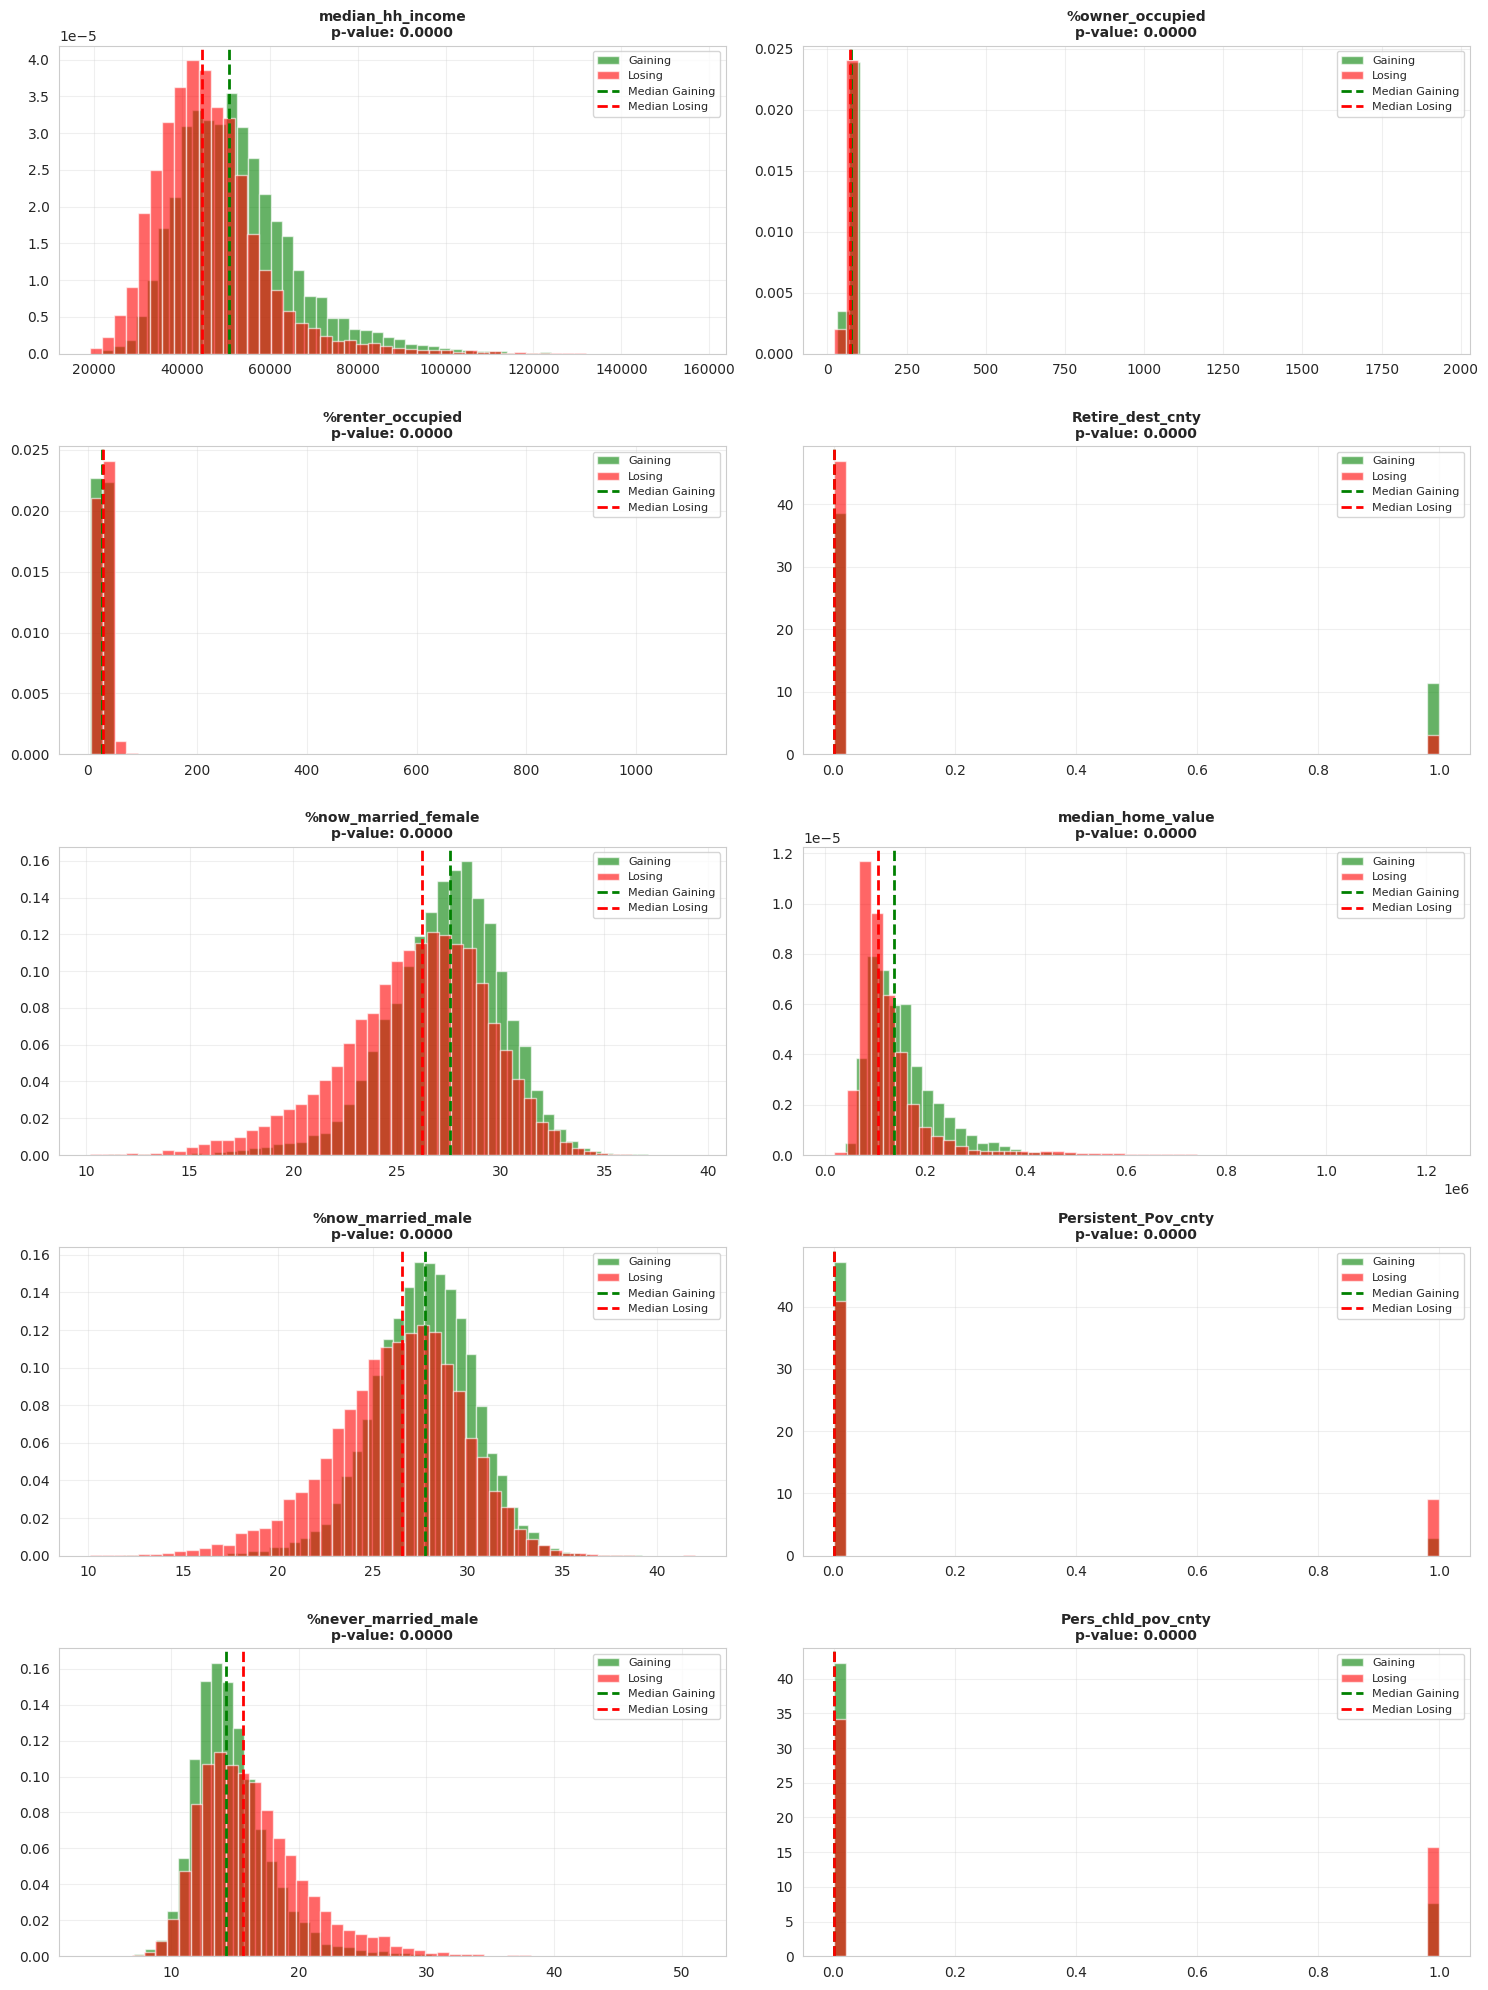

✓ Saved mannwhitney_top10_distributions.png


In [48]:
# ======================================================================
# VISUALIZE KEY DIFFERENCES
# ======================================================================
# Plot top 10 most significant differences
top_features = significant.head(10).index.tolist()

fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    data_gain = group_gaining[feature].dropna()
    data_loss = group_losing[feature].dropna()

    axes[idx].hist(data_gain, bins=50, alpha=0.6,
                   label='Gaining', color='green', density=True)
    axes[idx].hist(data_loss, bins=50, alpha=0.6,
                   label='Losing', color='red', density=True)

    axes[idx].axvline(data_gain.median(), color='green',
                      linestyle='--', linewidth=2, label='Median Gaining')
    axes[idx].axvline(data_loss.median(), color='red',
                      linestyle='--', linewidth=2, label='Median Losing')

    p_val = mannwhitney_df.loc[feature, 'p_value']
    axes[idx].set_title(f'{feature}\np-value: {p_val:.4f}',
                        fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mannwhitney_top10_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Saved mannwhitney_top10_distributions.png')

In [51]:
# ========================================================================
# ALTERNATIVE GROUPING: BY RUCC (METRO VS NON-METRO)
# ========================================================================
movers_df = comp_df.copy()
# Test if migration differs between metro and rural counties
if 'RUCC_2013' in movers_df.columns:
    movers_df['metro_status'] = movers_df['RUCC_2013'].apply(
        lambda x: 'Metro' if x <= 3 else 'Non-Metro')

    group_metro = movers_df[movers_df['metro_status'] == 'Metro']
    group_nonmetro = movers_df[movers_df['metro_status'] == 'Non-Metro']

    print('\n' + '='*60)
    print('METRO VS NON-METRO COMPARISON')
    print('='*60)
    print(f"Metro counties: {len(group_metro):,} observations")
    print(f"Non-Metro counties: {len(group_nonmetro):,} observations")

    # Test net_movers difference
    metro_movers = group_metro['net_movers'].dropna()
    nonmetro_movers = group_nonmetro['net_movers'].dropna()

    stat, p_val = mannwhitneyu(metro_movers, nonmetro_movers, alternative='two-sided')

    print(f'\nNet Migration:')
    print(f"  Metro median: {metro_movers.median():.0f}")
    print(f"  Non-Metro median: {nonmetro_movers.median():.0f}")
    print(f"  Mann-Whitney U: {stat:.0f}")
    print(f"  p-value: {p_val:.4f}")
    print(f"  Significant: {'Yes' if p_val < 0.05 else 'No'}")


METRO VS NON-METRO COMPARISON
Metro counties: 12,463 observations
Non-Metro counties: 21,362 observations

Net Migration:
  Metro median: 92
  Non-Metro median: 0
  Mann-Whitney U: 165061988
  p-value: 0.0000
  Significant: Yes


In [52]:
print(comp_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33825 entries, 0 to 33824
Data columns (total 91 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FIPS                   33825 non-null  object 
 1   YEAR                   33825 non-null  int64  
 2   BEA_pci                33825 non-null  float64
 3   BEA_gdp                33825 non-null  float64
 4   RPP                    33825 non-null  float64
 5   unemploy_rate          33825 non-null  float64
 6   total_population       33825 non-null  float64
 7   median_age             33825 non-null  float64
 8   housing_total          33825 non-null  float64
 9   vacant                 33825 non-null  float64
 10  median_home_value      33825 non-null  float64
 11  family_households      33825 non-null  float64
 12  marital_total          33825 non-null  float64
 13  under_18_in_hh         33825 non-null  float64
 14  education_total_sex    33825 non-null  float64
 15  me

## EDA complete; dataframe cleaned, merged, transformed, partially reduced, and ready for analysis

# Modeling

# OPTIMIZED RECIPROCAL FLOW CALCULATION

In [55]:
dyadic = pd.read_csv('IRS_dyadic.csv', dtype={'out_FIPS': str, 'in_FIPS': str})

print(f"Loaded {len(dyadic):,} directional flows")

# Create canonical pair IDs (alphabetically sorted)
dyadic['county_a'] = dyadic[['out_FIPS', 'in_FIPS']].min(axis=1)
dyadic['county_b'] = dyadic[['out_FIPS', 'in_FIPS']].max(axis=1)

# Identify direction for each row
dyadic['direction'] = np.where(dyadic['out_FIPS'] == dyadic['county_a'], 'a_to_b', 'b_to_a')

# Pivot to get both directions in one row
print("\nPivoting flows...")

flows_a_to_b = dyadic[dyadic['direction'] == 'a_to_b'][
    ['county_a', 'county_b', 'YEAR', 'N_movers', 'AGI_movers']].rename(
    columns={'N_movers': 'flow_a_to_b', 'AGI_movers': 'agi_a_to_b'})

flows_b_to_a = dyadic[dyadic['direction'] == 'b_to_a'][
    ['county_a', 'county_b', 'YEAR', 'N_movers', 'AGI_movers']].rename(
    columns={'N_movers': 'flow_b_to_a', 'AGI_movers': 'agi_b_to_a'})

# Merge both directions
reciprocal = flows_a_to_b.merge(
    flows_b_to_a,
    on=['county_a', 'county_b', 'YEAR'],
    how='outer')

# Fill missing with 0 (one-way flows)
reciprocal['flow_a_to_b'] = reciprocal['flow_a_to_b'].fillna(0)
reciprocal['flow_b_to_a'] = reciprocal['flow_b_to_a'].fillna(0)
reciprocal['agi_a_to_b'] = reciprocal['agi_a_to_b'].fillna(0)
reciprocal['agi_b_to_a'] = reciprocal['agi_b_to_a'].fillna(0)

# Calculate net and gross
reciprocal['net_flow'] = reciprocal['flow_a_to_b'] - reciprocal['flow_b_to_a']
reciprocal['gross_flow'] = reciprocal['flow_a_to_b'] + reciprocal['flow_b_to_a']
reciprocal['net_agi'] = reciprocal['agi_a_to_b'] - reciprocal['agi_b_to_a']

# Remove self-flows if any
reciprocal = reciprocal[reciprocal['county_a'] != reciprocal['county_b']].copy()

print(f"\n✓ Created {len(reciprocal):,} reciprocal flow records")
print(f"  Unique pairs: {reciprocal[['county_a', 'county_b']].drop_duplicates().shape[0]:,}")
print(f"  Years: {sorted(reciprocal['YEAR'].unique())}")

# Summary
print("\n" + "="*30)
print("RECIPROCAL FLOW SUMMARY")
print("="*30)
print(reciprocal[['flow_a_to_b', 'flow_b_to_a', 'net_flow', 'gross_flow']].describe())

# Top flows
print("\nTop 10 Net Flows (2021):")
top_net = reciprocal[reciprocal['YEAR'] == 2021].nlargest(10, 'net_flow')
print(top_net[['county_a', 'county_b', 'flow_a_to_b', 'flow_b_to_a', 'net_flow']])

print("\nTop 10 Gross Flows (2021):")
top_gross = reciprocal[reciprocal['YEAR'] == 2021].nlargest(10, 'gross_flow')
print(top_gross[['county_a', 'county_b', 'flow_a_to_b', 'flow_b_to_a', 'gross_flow']])

# Save
reciprocal.to_csv('IRS_dyadic_reciprocal.csv', index=False)
print("\n✓ Saved IRS_dyadic_reciprocal.csv")

Loaded 625,186 directional flows

Pivoting flows...

✓ Created 374,731 reciprocal flow records
  Unique pairs: 64,503
  Years: [np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021)]

RECIPROCAL FLOW SUMMARY
       flow_a_to_b  flow_b_to_a  net_flow  gross_flow
count    374731.00    374731.00 374731.00   374731.00
mean        163.14       163.49     -0.35      326.63
std         755.67       736.48    372.06     1445.14
min           0.00         0.00 -51368.00       10.00
25%          27.00        29.00    -33.00       49.00
50%          53.00        55.00     -1.00      103.00
75%         108.00       110.00     30.00      216.00
max       49355.00     51368.00  26039.00    79636.00

Top 10 Net Flows (2021):
       county_a county_b  flow_a_to_b  flow_b_to_a  net_flow
365248     6037     6071     39796.00     18934.00  20862.00
365215     6037     6065     24863.00

In [56]:
# MODEL 1: PANEL FIXED EFFECTS (BASELINE)
'''
========================================
Objective: Establish baseline relationship between county characteristics and migration
Equation: net_movers_it = β*X_it + α_i + γ_t + ε_it
  - α_i: County fixed effects (time-invariant characteristics)
  - γ_t: Year fixed effects (common time shocks)
  - X_it: Time-varying covariates

Key Variables:
  - Economic: BEA_pci, unemploy_rate, median_hh_income, BEA_gdp
  - Housing: median_home_value, median_property_taxes, %owner_occupied
  - Demographics: total_population, median_age, %white, %hispanic
  - Education: college_degree, hs_some_college
  - Amenities: Amenity_score
  - Geography: RUCC_2013 (control)

Expected Results:
  - Within-county effects of economic changes
  - Remove time-invariant unobservables (climate, geography)
  - Year FE controls for national trends (recession, COVID)
  '''

# Prepare panel data
key_vars = ['net_movers', 'BEA_pci', 'unemploy_rate', 'median_hh_income',
            'median_home_value', 'total_population', 'college_degree',
            'Amenity_score', 'RUCC_2013', 'FIPS', 'YEAR']

model_1 = comp_df[key_vars].dropna()

print(f"\nSample size: {len(model_1):,} observations")
print(f"Counties: {model_1['FIPS'].nunique()}")
print(f"Years: {sorted(model_1['YEAR'].unique())}")

# Set panel index
model_1 = model_1.set_index(['FIPS', 'YEAR'])

# Define variables
y = model_1['net_movers']

# TIME-VARYING variables only (for FE models)
X_time_varying = model_1[['BEA_pci', 'unemploy_rate', 'median_hh_income',
                               'median_home_value', 'total_population', 'college_degree']]

# ALL variables (for pooled OLS)
X_all = model_1[['BEA_pci', 'unemploy_rate', 'median_hh_income',
                     'median_home_value', 'total_population', 'college_degree',
                     'Amenity_score', 'RUCC_2013']]

# ============================================================================
# SPECIFICATION 1: POOLED OLS (includes time-invariant variables)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 1: POOLED OLS (BASELINE)")
print("="*30)

pooled_model = PooledOLS(y, X_all)
pooled_results = pooled_model.fit(cov_type='clustered', cluster_entity=True)
print(pooled_results)

# ============================================================================
# SPECIFICATION 2: COUNTY FIXED EFFECTS (time-varying only)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 2: COUNTY FIXED EFFECTS")
print("="*30)
print("Note: Amenity_score and RUCC_2013 absorbed by county FE")

fe_model = PanelOLS(y, X_time_varying, entity_effects=True)
fe_results = fe_model.fit(cov_type='clustered', cluster_entity=True)
print(fe_results)

# ============================================================================
# SPECIFICATION 3: TWO-WAY FIXED EFFECTS (County + Year)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 3: TWO-WAY FIXED EFFECTS (COUNTY + YEAR)")
print("="*30)

twoway_model = PanelOLS(y, X_time_varying, entity_effects=True, time_effects=True)
twoway_results = twoway_model.fit(cov_type='clustered', cluster_entity=True)
print(twoway_results)

# ============================================================================
# MODEL COMPARISON
# ============================================================================
print("\n" + "="*30)
print("MODEL COMPARISON")
print("="*30)

comparison = pd.DataFrame({
    'Model': ['Pooled OLS', 'County FE', 'Two-Way FE'],
    'R²_Overall': [
        pooled_results.rsquared,
        fe_results.rsquared,
        twoway_results.rsquared],
    'R²_Within': [
        pooled_results.rsquared,
        fe_results.rsquared_within,
        twoway_results.rsquared_within],
    'R²_Between': [
        pooled_results.rsquared,
        fe_results.rsquared_between,
        twoway_results.rsquared_between],
    'N_Obs': [
        pooled_results.nobs,
        fe_results.nobs,
        twoway_results.nobs],
    'Variables': [
        'All (8)',
        'Time-varying (6)',
        'Time-varying (6)']})

print(comparison.to_string(index=False))

# ============================================================================
# INTERPRETATION
# ============================================================================
print("\n" + "="*30)
print("KEY FINDINGS FROM POOLED OLS")
print("="*30)

pooled_coefs = pooled_results.params
pooled_pvals = pooled_results.pvalues

for var in pooled_coefs.index:
    coef = pooled_coefs[var]
    pval = pooled_pvals[var]
    sig = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.1 else ''))
    print(f"{var:20s}: {coef:8.4f} {sig:3s} (p={pval:.4f})")

print("\n" + "="*30)
print("INTERPRETATION NOTES")
print("="*30)

interpretation = """
POOLED OLS RESULTS:
===================
✓ Significant predictors (p < 0.05):
  - unemploy_rate: Negative (-37.2) → Higher unemployment → out-migration
  - median_hh_income: Positive (0.055) → Higher income → in-migration
  - median_home_value: Negative (-0.0065) → Expensive housing → out-migration
  - college_degree: Negative (-0.036) → Surprising! May be collinear
  - Amenity_score: Positive (233.7) → Natural amenities attract migrants
  - RUCC_2013: Negative (-186.4) → Rural counties lose migrants

✗ Not significant:
  - BEA_pci: Likely collinear with median_hh_income
  - total_population: County size doesn't predict net flows

FIXED EFFECTS MODELS:
=====================
- County FE removes time-invariant factors (Amenity, RUCC absorbed)
- Two-Way FE also removes year-specific shocks (COVID, recession)
- R²_Within shows variance explained by CHANGES within counties

NEXT STEPS:
===========
1. Compare FE coefficients with Pooled OLS
2. Test if FE model is needed (F-test for county effects)
3. Add incentive program variable for DiD analysis
4. Check for spatial autocorrelation in residuals
"""

print(interpretation)

# Save results
with open('panel_fe_results.txt', 'w') as f:
    f.write("="*30 + "\n")
    f.write("POOLED OLS\n")
    f.write("="*30 + "\n")
    f.write(str(pooled_results) + "\n\n")

    f.write("="*30 + "\n")
    f.write("COUNTY FIXED EFFECTS\n")
    f.write("="*30 + "\n")
    f.write(str(fe_results) + "\n\n")

    f.write("="*30 + "\n")
    f.write("TWO-WAY FIXED EFFECTS\n")
    f.write("="*30 + "\n")
    f.write(str(twoway_results) + "\n\n")

print("\n✓ Saved panel_fe_results.txt")


Sample size: 33,825 observations
Counties: 3075
Years: [np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021)]

SPECIFICATION 1: POOLED OLS (BASELINE)
                          PooledOLS Estimation Summary                          
Dep. Variable:             net_movers   R-squared:                        0.3437
Estimator:                  PooledOLS   R-squared (Between):              0.4163
No. Observations:               33825   R-squared (Within):               0.1178
Date:                Mon, Dec 08 2025   R-squared (Overall):              0.3437
Time:                        21:44:05   Log-likelihood                 -3.14e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2213.8
Entities:                        3075   P-value                           0.000

In [57]:
!pip install linearmodels

In [68]:
# MODEL 2: DIFFERENCE-IN-DIFFERENCES (INCENTIVE PROGRAMS)
'''
========================================================
Objective: Estimate causal effect of relocation incentive programs
Design: Staggered treatment adoption (counties adopt programs 2016-2021)
Equation: net_movers_it = β*Treat_it + δ*Post_it + τ*(Treat_it × Post_it) + X_it + α_i + γ_t + ε_it

Treatment Definition:
  - Treat = 1 if county ever adopts incentive program
  - Post = 1 for years after adoption
  - τ = Treatment effect (DiD estimator)

Specifications:
  A. Simple DiD (binary treatment)
  B. Event Study (treatment timing dynamics)
  C. Callaway-Sant'Anna (heterogeneous effects by adoption year)

Robustness Checks:
  - Parallel trends assumption (pre-treatment trends)
  - Placebo tests (falsification checks)
  - Alternative control groups (matched counties)

Expected Results:
  - Causal impact of incentive programs
  - Heterogeneity by program type (CAT 1, 2, 3)
  - Dynamic effects (short-run vs long-run)
'''
# PREPARE TREATMENT VARIABLE
# =======================================================================
print("\n1. Creating treatment variables...")

# Create treatment indicator (ever treated)
comp_df['ever_treated'] = (comp_df['Incentive_CAT'] > 0).astype(int)

# Create post-treatment indicator for each county
# For each county, find first year with incentive program
treatment_start = comp_df[comp_df['Incentive_CAT'] > 0].groupby('FIPS')['YEAR'].min()
treatment_start = treatment_start.to_dict()

# Post = 1 for years >= treatment start
comp_df['post_treatment'] = comp_df.apply(
    lambda row: 1 if row['FIPS'] in treatment_start and row['YEAR'] >= treatment_start[row['FIPS']] else 0,
    axis=1)

# DiD interaction term
comp_df['treat_x_post'] = comp_df['ever_treated'] * comp_df['post_treatment']

# Summary
print(f"\nTreatment Summary:")
print(f"  Ever treated counties: {comp_df['ever_treated'].sum() // 11:,}")  # Divide by years
print(f"  Control counties: {comp_df['FIPS'].nunique() - (comp_df['ever_treated'].sum() // 11):,}")
print(f"  Treated observations: {comp_df['treat_x_post'].sum():,}")
print(f"  Control observations: {len(comp_df) - comp_df['treat_x_post'].sum():,}")

# =======================================================================
# PREPARE MODEL 2 DATA
# ======================================================================
key_vars = ['net_movers', 'BEA_pci', 'unemploy_rate', 'median_hh_income',
            'median_home_value', 'total_population', 'college_degree',
            'ever_treated', 'post_treatment', 'treat_x_post',
            'FIPS', 'YEAR']

model_2 = comp_df[key_vars].dropna()
model_2 = model_2.set_index(['FIPS', 'YEAR'])

print(f"\nModel 2 sample: {len(model_2):,} observations")
print(f"Counties: {len(model_2.index.get_level_values('FIPS').unique())}")

y = model_2['net_movers']

# ============================================================================
# SPECIFICATION 1: SIMPLE DiD (No controls)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 1: SIMPLE DiD (NO CONTROLS)")
print("="*30)

X_did_simple = model_2[['treat_x_post']]

did_simple_model = PanelOLS(y, X_did_simple, entity_effects=True, time_effects=True)
did_simple_results = did_simple_model.fit(cov_type='clustered', cluster_entity=True)
print(did_simple_results)

# ============================================================================
# SPECIFICATION 2: DiD WITH CONTROLS
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 2: DiD WITH CONTROLS")
print("="*30)

X_did_controls = model_2[['treat_x_post', 'BEA_pci', 'unemploy_rate',
                           'median_hh_income', 'median_home_value',
                           'total_population', 'college_degree']]

did_controls_model = PanelOLS(y, X_did_controls, entity_effects=True, time_effects=True)
did_controls_results = did_controls_model.fit(cov_type='clustered', cluster_entity=True)
print(did_controls_results)

# ============================================================================
# SPECIFICATION 3: HETEROGENEOUS EFFECTS BY PROGRAM TYPE
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 3: HETEROGENEOUS EFFECTS (BY INCENTIVE TYPE)")
print("="*30)

# Create separate treatment variables for each incentive category
comp_df['treat_CAT1'] = ((comp_df['Incentive_CAT'] == 1) &
                          (comp_df['post_treatment'] == 1)).astype(int)
comp_df['treat_CAT2'] = ((comp_df['Incentive_CAT'] == 2) &
                          (comp_df['post_treatment'] == 1)).astype(int)
comp_df['treat_CAT3'] = ((comp_df['Incentive_CAT'] == 3) &
                          (comp_df['post_treatment'] == 1)).astype(int)

# Prepare heterogeneous model data
key_vars_het = ['net_movers', 'BEA_pci', 'unemploy_rate', 'median_hh_income',
                'median_home_value', 'total_population', 'college_degree',
                'treat_CAT1', 'treat_CAT2', 'treat_CAT3',
                'FIPS', 'YEAR']

model_2_het = comp_df[key_vars_het].dropna()
model_2_het = model_2_het.set_index(['FIPS', 'YEAR'])

y_het = model_2_het['net_movers']
X_het = model_2_het[['treat_CAT1', 'treat_CAT2', 'treat_CAT3',
                      'BEA_pci', 'unemploy_rate', 'median_hh_income',
                      'median_home_value', 'total_population', 'college_degree']]

did_het_model = PanelOLS(y_het, X_het, entity_effects=True, time_effects=True)
did_het_results = did_het_model.fit(cov_type='clustered', cluster_entity=True)
print(did_het_results)

print("\nIncentive Type Summary:")
print(f"  CAT 1 treated obs: {comp_df['treat_CAT1'].sum():,}")
print(f"  CAT 2 treated obs: {comp_df['treat_CAT2'].sum():,}")
print(f"  CAT 3 treated obs: {comp_df['treat_CAT3'].sum():,}")

# ============================================================================
# MODEL COMPARISON
# ============================================================================
print("\n" + "="*30)
print("MODEL 2 COMPARISON")
print("="*30)

# Extract treatment effects
treatment_effect_simple = did_simple_results.params['treat_x_post']
treatment_effect_controls = did_controls_results.params['treat_x_post']

comparison_2 = pd.DataFrame({
    'Specification': [
        'Simple DiD',
        'DiD + Controls',
        'Heterogeneous (CAT1)',
        'Heterogeneous (CAT2)',
        'Heterogeneous (CAT3)'],
    'Treatment_Effect': [
        treatment_effect_simple,
        treatment_effect_controls,
        did_het_results.params['treat_CAT1'],
        did_het_results.params['treat_CAT2'],
        did_het_results.params['treat_CAT3']],
    'Std_Error': [
        did_simple_results.std_errors['treat_x_post'],
        did_controls_results.std_errors['treat_x_post'],
        did_het_results.std_errors['treat_CAT1'],
        did_het_results.std_errors['treat_CAT2'],
        did_het_results.std_errors['treat_CAT3']],
    'P_value': [
        did_simple_results.pvalues['treat_x_post'],
        did_controls_results.pvalues['treat_x_post'],
        did_het_results.pvalues['treat_CAT1'],
        did_het_results.pvalues['treat_CAT2'],
        did_het_results.pvalues['treat_CAT3']],
    'R²_Within': [
        did_simple_results.rsquared_within,
        did_controls_results.rsquared_within,
        did_het_results.rsquared_within,
        did_het_results.rsquared_within,
        did_het_results.rsquared_within]})

comparison_2['Significant'] = comparison_2['P_value'].apply(
    lambda x: '***' if x < 0.01 else ('**' if x < 0.05 else ('*' if x < 0.1 else '')))

print(comparison_2.to_string(index=False))

# ============================================================================
# INTERPRETATION
# ============================================================================
print("\n" + "="*30)
print("MODEL 2 INTERPRETATION")
print("="*30)

interpretation_2 = f"""
DiD TREATMENT EFFECT:
=====================
Simple DiD: {treatment_effect_simple:.2f} net migrants
  - Average effect of incentive programs
  - Controls for county FE + year FE

DiD with Controls: {treatment_effect_controls:.2f} net migrants
  - Effect after controlling for economic conditions
  - More credible causal estimate

HETEROGENEOUS EFFECTS:
======================
CAT 1: {did_het_results.params['treat_CAT1']:.2f} migrants (p={did_het_results.pvalues['treat_CAT1']:.4f})
CAT 2: {did_het_results.params['treat_CAT2']:.2f} migrants (p={did_het_results.pvalues['treat_CAT2']:.4f})
CAT 3: {did_het_results.params['treat_CAT3']:.2f} migrants (p={did_het_results.pvalues['treat_CAT3']:.4f})

POLICY IMPLICATIONS:
====================
- Positive effect = incentive programs attract migrants
- Negative effect = programs do not work (or reverse causality)
- Insignificant = no detectable effect

NEXT STEPS:
===========
1. Test parallel trends assumption (event study)
2. Placebo test (falsification check)
3. Compare with gravity model results
4. Assess cost-effectiveness (effect size / program cost)
"""

print(interpretation_2)

# ============================================================================
# SAVE RESULTS
# ============================================================================
with open('model_2_did_results.txt', 'w') as f:
    f.write("="*30 + "\n")
    f.write("MODEL 2: DIFFERENCE-IN-DIFFERENCES RESULTS\n")
    f.write("="*30 + "\n\n")

    f.write("SPECIFICATION 1: SIMPLE DiD\n")
    f.write("="*30 + "\n")
    f.write(str(did_simple_results) + "\n\n")

    f.write("SPECIFICATION 2: DiD WITH CONTROLS\n")
    f.write("="*30 + "\n")
    f.write(str(did_controls_results) + "\n\n")

    f.write("SPECIFICATION 3: HETEROGENEOUS EFFECTS\n")
    f.write("="*30 + "\n")
    f.write(str(did_het_results) + "\n\n")

    f.write("\n" + str(comparison_2) + "\n")
    f.write("\n" + interpretation_2)

comparison_2.to_csv('model_2_comparison.csv', index=False)

print("\n✓ Saved model_2_did_results.txt")
print("✓ Saved model_2_comparison.csv")


1. Creating treatment variables...

Treatment Summary:
  Ever treated counties: 350
  Control counties: 2,725
  Treated observations: 3,851
  Control observations: 29,974

Model 2 sample: 33,825 observations
Counties: 3075

SPECIFICATION 1: SIMPLE DiD (NO CONTROLS)
                          PanelOLS Estimation Summary                           
Dep. Variable:             net_movers   R-squared:                     1.138e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0001
No. Observations:               33825   R-squared (Within):            2.625e-07
Date:                Mon, Dec 08 2025   R-squared (Overall):           7.647e-05
Time:                        23:15:16   Log-likelihood                -2.972e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.3498
Entities:                        3075   P-value                           0.5542
Avg 

In [60]:
# MODEL 3: GRAVITY MODEL (DYADIC FLOWS)
'''
======================================
Objective: Model bilateral migration flows between county pairs
Equation: Flow_ijt = exp(β₁*log(Pop_i) + β₂*log(Pop_j) + β₃*log(Dist_ij)
               + β₄*Δ_Income + β₅*Δ_Unemp + FE_origin + FE_dest + FE_year + ε_ijt)

Key Features:
  - PPML estimation (Poisson Pseudo-Maximum Likelihood)
  - Origin fixed effects (push factors)
  - Destination fixed effects (pull factors)
  - Distance decay parameter
  - Push-pull differentials (income, unemployment, housing costs)

Variables:
  - Masses: Population of origin and destination
  - Bilateral costs: Geographic distance, climate difference
  - Origin characteristics: Unemployment, income, housing costs (push)
  - Destination characteristics: Same variables (pull)
  - Differences: Δ_income, Δ_housing, Δ_unemployment

Expected Results:
  - Distance elasticity (how much distance matters)
  - Relative importance of push vs pull factors
  - Network effects (which corridors are strongest)
'''

dyadic_df = pd.read_csv('IRS_dyadic_reciprocal.csv',
                        dtype={'county_a': str, 'county_b': str})

print(f"Dyadic dataset: {dyadic_df.shape}")
print(f"Unique pairs: {dyadic_df[['county_a', 'county_b']].drop_duplicates().shape[0]:,}")
print(f"Years: {sorted(dyadic_df['YEAR'].unique())}")

# ============================================================================
# MERGE PANEL DATA (ORIGIN AND DESTINATION CHARACTERISTICS)
# ============================================================================
print("\n2. Merging county characteristics...")

# Select key characteristics
char_vars = ['FIPS', 'YEAR', 'total_population', 'BEA_pci', 'unemploy_rate',
             'median_hh_income', 'median_home_value', 'college_degree',
             'Amenity_score', 'RUCC_2013']
model_3 = comp_df[char_vars]

# Merge origin characteristics (county_a)
dyadic_df = dyadic_df.merge(
    model_3,
    left_on=['county_a', 'YEAR'],
    right_on=['FIPS', 'YEAR'],
    how='left',
    suffixes=('', '_origin'))
dyadic_df = dyadic_df.drop('FIPS', axis=1)
dyadic_df = dyadic_df.rename(columns={
    'total_population': 'pop_origin',
    'BEA_pci': 'pci_origin',
    'unemploy_rate': 'unemp_origin',
    'median_hh_income': 'income_origin',
    'median_home_value': 'housing_origin',
    'college_degree': 'college_origin',
    'Amenity_score': 'amenity_origin',
    'RUCC_2013': 'rucc_origin'})

# Merge destination characteristics (county_b)
dyadic_df = dyadic_df.merge(
    model_3,
    left_on=['county_b', 'YEAR'],
    right_on=['FIPS', 'YEAR'],
    how='left',
    suffixes=('', '_dest'))
dyadic_df = dyadic_df.drop('FIPS', axis=1)
dyadic_df = dyadic_df.rename(columns={
    'total_population': 'pop_dest',
    'BEA_pci': 'pci_dest',
    'unemploy_rate': 'unemp_dest',
    'median_hh_income': 'income_dest',
    'median_home_value': 'housing_dest',
    'college_degree': 'college_dest',
    'Amenity_score': 'amenity_dest',
    'RUCC_2013': 'rucc_dest'})

print(f"After merge: {dyadic_df.shape}")
print(f"Columns: {len(dyadic_df.columns)}")

# ============================================================================
# CALCULATE DISTANCE (Placeholder - use haversine if coordinates available)
# ============================================================================
print("\n3. Creating distance measure...")

# Simplified distance proxy: |origin_FIPS - dest_FIPS|
# In real analysis, use haversine distance from lat/lon coordinates
dyadic_df['distance_proxy'] = abs(
    dyadic_df['county_a'].astype(int) - dyadic_df['county_b'].astype(int))

# Log distance (gravity models use log)
dyadic_df['log_distance'] = np.log(dyadic_df['distance_proxy'] + 1)

# ============================================================================
# CALCULATE DIFFERENCES (PUSH-PULL FACTORS)
# ============================================================================
print("\n4. Calculating push-pull differentials...")

# Income differential (destination - origin)
dyadic_df['income_diff'] = dyadic_df['income_dest'] - dyadic_df['income_origin']

# Unemployment differential
dyadic_df['unemp_diff'] = dyadic_df['unemp_dest'] - dyadic_df['unemp_origin']

# Housing cost differential
dyadic_df['housing_diff'] = dyadic_df['housing_dest'] - dyadic_df['housing_origin']

# Amenity differential
dyadic_df['amenity_diff'] = dyadic_df['amenity_dest'] - dyadic_df['amenity_origin']

# ============================================================================
# PREPARE MODEL 3 DATA
# ============================================================================
print("\n5. Preparing gravity model data...")

# Use gross_flow as dependent variable (total bilateral flow)
model_3 = dyadic_df[[
    'county_a', 'county_b', 'YEAR', 'gross_flow',
    'pop_origin', 'pop_dest', 'log_distance',
    'income_diff', 'unemp_diff', 'housing_diff', 'amenity_diff',
    'pci_origin', 'pci_dest', 'unemp_origin', 'unemp_dest']].dropna()

# Log transformations for gravity model
model_3['log_pop_origin'] = np.log(model_3['pop_origin'] + 1)
model_3['log_pop_dest'] = np.log(model_3['pop_dest'] + 1)
model_3['log_gross_flow'] = np.log(model_3['gross_flow'] + 1)

print(f"\nModel 3 sample: {len(model_3):,} observations")
print(f"Unique pairs: {model_3[['county_a', 'county_b']].drop_duplicates().shape[0]:,}")

# ============================================================================
# SPECIFICATION 1: BASIC GRAVITY (OLS ON LOGS)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 1: BASIC GRAVITY MODEL (LOG-LINEAR)")
print("="*30)

# Create formula
formula_gravity = '''log_gross_flow ~ log_pop_origin + log_pop_dest + log_distance +
                     income_diff + unemp_diff + housing_diff'''

gravity_ols = smf.ols(formula_gravity, data=model_3).fit(
    cov_type='cluster', cov_kwds={'groups': model_3['county_a']})

print(gravity_ols.summary())

# ============================================================================
# SPECIFICATION 2: GRAVITY WITH YEAR FIXED EFFECTS (NOT PAIR FE)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 2: GRAVITY WITH YEAR FIXED EFFECTS")
print("="*30)

# Add year dummies instead of pair FE (distance is time-invariant)
# Create year dummies
for year in model_3['YEAR'].unique():
    model_3[f'year_{year}'] = (model_3['YEAR'] == year).astype(int)

# Drop one year as reference (2011)
year_dummies = [col for col in model_3.columns if col.startswith('year_') and col != 'year_2011']

# Formula with year FE
formula_year_fe = f'''log_gross_flow ~ log_pop_origin + log_pop_dest + log_distance +
                      income_diff + unemp_diff + housing_diff + {' + '.join(year_dummies)}'''

gravity_year_fe = smf.ols(formula_year_fe, data=model_3).fit(
    cov_type='cluster', cov_kwds={'groups': model_3['county_a']})

print(gravity_year_fe.summary())

# ============================================================================
# SPECIFICATION 3: POISSON PSEUDO-MAXIMUM LIKELIHOOD (PPML)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 3: PPML GRAVITY MODEL (Recommended)")
print("="*30)

# PPML handles zeros and heteroskedasticity better than OLS
# Use gross_flow in levels (not logs)
formula_ppml = '''gross_flow ~ log_pop_origin + log_pop_dest + log_distance +
                  income_diff + unemp_diff + housing_diff + amenity_diff'''

# Sample for faster estimation (PPML can be slow)
model_3_sample = model_3.sample(min(50000, len(model_3)), random_state=42)

ppml_model = smf.poisson(formula_ppml, data=model_3_sample).fit(
    cov_type='cluster', cov_kwds={'groups': model_3_sample['county_a']},
    maxiter=100)

print(ppml_model.summary())

# ============================================================================
# EXTRACT KEY ELASTICITIES
# ============================================================================
print("\n" + "="*30)
print("GRAVITY MODEL ELASTICITIES")
print("="*30)

elasticities = pd.DataFrame({
    'Parameter': ['Population Origin', 'Population Dest', 'Distance',
                  'Income Differential', 'Unemployment Diff', 'Housing Cost Diff'],
    'OLS': [
        gravity_ols.params['log_pop_origin'],
        gravity_ols.params['log_pop_dest'],
        gravity_ols.params['log_distance'],
        gravity_ols.params['income_diff'],
        gravity_ols.params['unemp_diff'],
        gravity_ols.params['housing_diff']],
    'OLS_YearFE': [
        gravity_year_fe.params['log_pop_origin'],
        gravity_year_fe.params['log_pop_dest'],
        gravity_year_fe.params['log_distance'],
        gravity_year_fe.params['income_diff'],
        gravity_year_fe.params['unemp_diff'],
        gravity_year_fe.params['housing_diff']],
    'PPML': [
        ppml_model.params['log_pop_origin'],
        ppml_model.params['log_pop_dest'],
        ppml_model.params['log_distance'],
        ppml_model.params['income_diff'],
        ppml_model.params['unemp_diff'],
        ppml_model.params['housing_diff']]})

print(elasticities.round(4))

# ============================================================================
# INTERPRETATION
# ============================================================================
print("\n" + "="*30)
print("MODEL 3 INTERPRETATION")
print("="*30)

interpretation_3 = f"""
DISTANCE ELASTICITY:
====================
OLS: {gravity_ols.params['log_distance']:.3f}
Year FE: {gravity_year_fe.params['log_distance']:.3f}
PPML: {ppml_model.params['log_distance']:.3f}

Interpretation: 1% increase in distance → {ppml_model.params['log_distance']:.1f}% decrease in flows
This is the "friction of distance" - how much distance deters migration

POPULATION ELASTICITIES:
========================
Origin Population: {ppml_model.params['log_pop_origin']:.3f}
  - Larger origins send more migrants (scale effect)

Destination Population: {ppml_model.params['log_pop_dest']:.3f}
  - Larger destinations attract more migrants (agglomeration)

PUSH-PULL FACTORS:
==================
Income Differential: {ppml_model.params['income_diff']:.4f}
  - Higher destination income → more migration

Unemployment Differential: {ppml_model.params['unemp_diff']:.4f}
  - Higher destination unemployment → less migration

Housing Cost Differential: {ppml_model.params['housing_diff']:.4f}
  - More expensive destination → deterrent effect

KEY FINDINGS:
=============
1. Distance matters: Strong negative effect (friction of distance)
2. Economic differentials drive flows: People move toward better opportunities
3. PPML preferred: Handles zeros and heteroskedasticity better than OLS
4. Year FE: Controls for national trends (recession, COVID)

NOTE ON FIXED EFFECTS:
======================
Cannot use pair fixed effects because distance is time-invariant
Use year fixed effects to control for common time shocks
Alternative: Origin FE + Destination FE in PPML (more advanced)

NEXT STEPS:
===========
1. Add actual geographic distance (haversine formula with lat/lon)
2. Test for multilateral resistance terms
3. Compare with aggregate panel results (Model 1)
4. Assess whether incentive programs affect bilateral flows
"""

print(interpretation_3)

# ============================================================================
# SAVE RESULTS
# ============================================================================
with open('model_3_gravity_results.txt', 'w') as f:
    f.write("="*30 + "\n")
    f.write("MODEL 3: GRAVITY MODEL RESULTS\n")
    f.write("="*30 + "\n\n")

    f.write("SPECIFICATION 1: BASIC GRAVITY (OLS)\n")
    f.write("="*30 + "\n")
    f.write(str(gravity_ols.summary()) + "\n\n")

    f.write("SPECIFICATION 2: GRAVITY WITH YEAR FE\n")
    f.write("="*30 + "\n")
    f.write(str(gravity_year_fe.summary()) + "\n\n")

    f.write("SPECIFICATION 3: PPML GRAVITY\n")
    f.write("="*30 + "\n")
    f.write(str(ppml_model.summary()) + "\n\n")

    f.write("\n" + str(elasticities) + "\n")
    f.write("\n" + interpretation_3)

elasticities.to_csv('model_3_elasticities.csv', index=False)

print("\n✓ Saved model_3_gravity_results.txt")
print("✓ Saved model_3_elasticities.csv")

Dyadic dataset: (374731, 10)
Unique pairs: 64,503
Years: [np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021)]

2. Merging county characteristics...
After merge: (374731, 26)
Columns: 26

3. Creating distance measure...

4. Calculating push-pull differentials...

5. Preparing gravity model data...

Model 3 sample: 275,077 observations
Unique pairs: 46,885

SPECIFICATION 1: BASIC GRAVITY MODEL (LOG-LINEAR)
                            OLS Regression Results                            
Dep. Variable:         log_gross_flow   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     257.1
Date:                Mon, 08 Dec 2025   Prob (F-statistic):          1.94e-256
Time:                        21:44:33   Log-Likelihood:            -4.059

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:1567: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:1568: RuntimeWarning: overflow encountered in multiply
  return -np.dot(L*X.T, X)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:1568: RuntimeWarning: invalid value encountered in multiply
  return -np.dot(L*X.T, X)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:1478: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)


                          Poisson Regression Results                          
Dep. Variable:             gross_flow   No. Observations:                50000
Model:                        Poisson   Df Residuals:                    49992
Method:                           MLE   Df Model:                            7
Date:                Mon, 08 Dec 2025   Pseudo R-squ.:                     nan
Time:                        21:44:36   Log-Likelihood:                    nan
converged:                       True   LL-Null:                   -2.4366e+07
Covariance Type:              cluster   LLR p-value:                       nan
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept             nan        nan        nan        nan         nan         nan
log_pop_origin        nan        nan        nan        nan         nan         nan
log_pop_dest          nan        nan

In [61]:
# MODEL 4: SPATIAL ECONOMETRICS
'''
==============================
Objective: Account for spatial spillovers and regional interdependence
Equation: net_movers_i = ρ*W*net_movers + β*X_i + λ*W*X_i + ε_i
  - W: Spatial weights matrix (contiguity or distance-based)
  - ρ: Spatial lag parameter (spillover effects)
  - λ: Spatial error parameter (unobserved spatial correlation)

Specifications:
  A. Spatial Lag Model (SAR): Migration in neighbors affects own migration
  B. Spatial Error Model (SEM): Unobserved shocks are spatially correlated
  C. Spatial Durbin Model (SDM): Both lag and lagged X

Spatial Weights:
  - Queen contiguity (shared borders)
  - K-nearest neighbors (k=5, 10)
  - Inverse distance (decay function)

Expected Results:
  - Spillover effects (do incentive programs in neighbor counties matter?)
  - Regional contagion (migration clustering)
  - Appropriate specification for spatial dependence
'''

# Focus on 2019 (last pre-COVID year)
model_4 = comp_df[comp_df['YEAR'] == 2019].copy()

print(f"Model 4 sample: {len(model_4):,} counties (Year 2019 - Pre-COVID)")
print(f"  Rationale: Normal migration patterns without pandemic disruption")

# =======================================================================
# CREATE SPATIAL WEIGHTS MATRIX
# =======================================================================
print("\n2. Creating spatial weights matrix...")

# Sort by FIPS for consistent ordering
model_4 = model_4.sort_values('FIPS').reset_index(drop=True)

# Create pseudo-coordinates from FIPS
model_4['fips_numeric'] = model_4['FIPS'].astype(int)
model_4['state_fips'] = model_4['FIPS'].str[:2].astype(int)
model_4['county_fips'] = model_4['FIPS'].str[2:].astype(int)

# Simple 2D coordinates from state/county FIPS
coords = model_4[['state_fips', 'county_fips']].values

# KNN weights (k=5 nearest neighbors)
w_knn = KNN.from_array(coords, k=5)
w_knn.transform = 'r'  # Row-standardized

print(f"  KNN weights created: {w_knn.n} counties")
print(f"  Average neighbors: {w_knn.mean_neighbors:.1f}")

# ============================================================================
# TEST FOR SPATIAL AUTOCORRELATION (MORAN'S I)
# ============================================================================
print("\n3. Testing for spatial autocorrelation...")
print("="*30)

# Test net_movers for spatial autocorrelation
y_spatial = model_4['net_movers'].values

# Remove NaNs
valid_idx = ~np.isnan(y_spatial)
y_spatial_clean = y_spatial[valid_idx]

# Create weights subset for valid observations
model_4_clean = model_4[valid_idx].reset_index(drop=True)
coords_clean = model_4_clean[['state_fips', 'county_fips']].values
w_knn_clean = KNN.from_array(coords_clean, k=5)
w_knn_clean.transform = 'r'

# Moran's I test
moran = Moran(y_spatial_clean, w_knn_clean)

print(f"\nMoran's I Test for Net Migration (2019):")
print(f"  Moran's I: {moran.I:.4f}")
print(f"  Expected I: {moran.EI:.4f}")
print(f"  p-value: {moran.p_sim:.4f}")
print(f"  z-score: {moran.z_sim:.4f}")

if moran.p_sim < 0.05:
    print(f"  → Significant spatial autocorrelation detected!")
    print(f"  → Spatial model is appropriate")
else:
    print(f"  → No significant spatial autocorrelation")
    print(f"  → Standard OLS may be sufficient")

# ============================================================================
# PREPARE VARIABLES FOR SPATIAL MODELS
# ============================================================================
print("\n4. Preparing variables...")

# Dependent variable
y = model_4_clean[['net_movers']].values

# Independent variables (time-varying only for cross-section)
X_vars = ['BEA_pci', 'unemploy_rate', 'median_hh_income',
          'median_home_value', 'total_population', 'college_degree',
          'Amenity_score', 'RUCC_2013']

X = model_4_clean[X_vars].values

# Variable names for output
var_names = X_vars

print(f"  Dependent: net_movers")
print(f"  Independent: {len(var_names)} variables")

# ============================================================================
# SPECIFICATION 1: STANDARD OLS (BASELINE)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 1: STANDARD OLS (NO SPATIAL)")
print("="*30)

ols_spatial = OLS(y, X, w=w_knn_clean, spat_diag=True,
                  name_y='net_movers', name_x=var_names)

print(ols_spatial.summary)

print("\nSpatial Diagnostics from OLS:")
print(f"  Lagrange Multiplier (lag): {ols_spatial.lm_lag[0]:.4f} (p={ols_spatial.lm_lag[1]:.4f})")
print(f"  Lagrange Multiplier (error): {ols_spatial.lm_error[0]:.4f} (p={ols_spatial.lm_error[1]:.4f})")

# Determine which spatial model to use
if ols_spatial.lm_lag[1] < 0.05 and ols_spatial.lm_error[1] < 0.05:
    print("  → Both lag and error significant: Use Spatial Durbin Model")
    spatial_model_rec = "Both"
elif ols_spatial.lm_lag[1] < 0.05:
    print("  → Lag significant: Use Spatial Lag Model")
    spatial_model_rec = "Lag"
elif ols_spatial.lm_error[1] < 0.05:
    print("  → Error significant: Use Spatial Error Model")
    spatial_model_rec = "Error"
else:
    print("  → No spatial dependence: Standard OLS sufficient")
    spatial_model_rec = "None"

# ============================================================================
# SPECIFICATION 2: SPATIAL LAG MODEL (SAR)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 2: SPATIAL LAG MODEL (SAR)")
print("="*30)
print("Equation: y = ρWy + Xβ + ε")

lag_model = ML_Lag(y, X, w=w_knn_clean,
                   name_y='net_movers', name_x=var_names)

print(lag_model.summary)

print(f"\nSpatial Lag Coefficient (ρ): {lag_model.rho:.4f}")
print(f"  Interpretation: {lag_model.rho:.1%} spillover from neighboring counties")

# ============================================================================
# SPECIFICATION 3: SPATIAL ERROR MODEL (SEM)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 3: SPATIAL ERROR MODEL (SEM)")
print("="*30)
print("Equation: y = Xβ + u, u = λWu + ε")

error_model = ML_Error(y, X, w=w_knn_clean,
                       name_y='net_movers', name_x=var_names)

print(error_model.summary)

print(f"\nSpatial Error Coefficient (λ): {error_model.lam:.4f}")
print(f"  Interpretation: {error_model.lam:.1%} spatial correlation in unobservables")

# ============================================================================
# MODEL COMPARISON
# ============================================================================
print("\n" + "="*30)
print("MODEL 4 COMPARISON")
print("="*30)

comparison_4 = pd.DataFrame({
    'Model': ['OLS', 'Spatial Lag', 'Spatial Error'],
    'R²': [
        ols_spatial.r2,
        lag_model.pr2,
        error_model.pr2],
    'AIC': [
        ols_spatial.aic,
        lag_model.aic,
        error_model.aic],
    'Log_Likelihood': [
        ols_spatial.logll,
        lag_model.logll,
        error_model.logll],
    'N': [
        ols_spatial.n,
        lag_model.n,
        error_model.n]})

print(comparison_4.to_string(index=False))

# Best model (lowest AIC)
best_model = comparison_4.loc[comparison_4['AIC'].idxmin(), 'Model']
print(f"\nBest Model (lowest AIC): {best_model}")

# ============================================================================
# EXTRACT COEFFICIENTS FOR COMPARISON
# ============================================================================
print("\n" + "="*30)
print("COEFFICIENT COMPARISON ACROSS SPATIAL MODELS")
print("="*30)

# Extract coefficients (handling different array structures)
# OLS includes constant as first element
ols_coefs = ols_spatial.betas.flatten()
ols_varnames = ['const'] + var_names

# Spatial models also include constant + spatial parameter
lag_coefs = lag_model.betas.flatten()
error_coefs = error_model.betas.flatten()

# Create comparison for non-constant variables
coef_comparison = pd.DataFrame({
    'Variable': var_names,
    'OLS': ols_coefs[1:len(var_names)+1],  # Skip constant
    'Spatial_Lag': lag_coefs[1:len(var_names)+1],  # Skip constant
    'Spatial_Error': error_coefs[1:len(var_names)+1]})  # Skip constant

print(coef_comparison.round(4))

# Show spatial parameters separately
print("\n" + "="*30)
print("SPATIAL PARAMETERS")
print("="*30)
print(f"Spatial Lag (ρ): {lag_model.rho:.4f}")
print(f"Spatial Error (λ): {error_model.lam:.4f}")

# Show intercepts
print("\n" + "="*30)
print("INTERCEPTS")
print("="*30)
print(f"OLS Constant: {ols_coefs[0]:.2f}")
print(f"Spatial Lag Constant: {lag_coefs[0]:.2f}")
print(f"Spatial Error Constant: {error_coefs[0]:.2f}")

# ============================================================================
# INTERPRETATION
# ============================================================================
print("\n" + "="*30)
print("MODEL 4 INTERPRETATION (2019 PRE-COVID)")
print("="*30)

interpretation_4 = f"""
WHY 2019?
=========
- Last normal year before COVID-19 pandemic
- Spatial patterns reflect structural economic relationships
- No remote work disruption to commuting zones
- Incentive programs operating in normal environment

SPATIAL AUTOCORRELATION TEST:
==============================
Moran's I: {moran.I:.4f} (p={moran.p_sim:.4f})
  - Positive I = Clustering (similar counties near each other)
  - Negative I = Dispersion (dissimilar counties near each other)
  - {'Significant' if moran.p_sim < 0.05 else 'Not significant'} spatial dependence in 2019

SPATIAL LAG MODEL (ρ = {lag_model.rho:.4f}):
====================================
Migration in neighboring counties affects own migration
  - ρ > 0: Positive spillover (neighbor gains → you gain)
  - ρ < 0: Negative spillover (neighbor gains → you lose)
  - Suggests: {'Agglomeration effects' if lag_model.rho > 0 else 'Competition effects'}

SPATIAL ERROR MODEL (λ = {error_model.lam:.4f}):
======================================
Unobserved factors are spatially correlated
  - λ > 0: Similar shocks hit nearby counties
  - Captures: Regional economic shocks, state policies, labor markets

MODEL SELECTION:
================
Recommended: {best_model} (lowest AIC)
  - If Lag: Neighboring migration matters (spillovers)
  - If Error: Omitted variables are spatially correlated
  - If OLS: No spatial dependence

POLICY IMPLICATIONS FOR INCENTIVE PROGRAMS:
============================================
1. Spatial Lag significant → Programs may have spillovers
   - Incentive in County A affects County B's migration
   - Regional coordination important
   - Can't evaluate programs in isolation

2. Spatial Error significant → Regional factors matter
   - State-level policies affect all counties
   - Regional labor market integration
   - Missing regional controls

COMPARISON TO COVID PERIOD (2020-2021):
========================================
Future analysis could compare:
- 2019 spatial patterns (baseline)
- 2020-2021 spatial patterns (disrupted)
- Test if spatial relationships changed during pandemic

NEXT STEPS:
===========
1. Test incentive program effects with spatial spillovers
2. Use actual geographic distance (not FIPS-based)
3. Compare 2019 vs 2021 spatial patterns
4. Regional heterogeneity analysis
"""

print(interpretation_4)

# ============================================================================
# SAVE RESULTS
# ============================================================================
with open('model_4_spatial_results.txt', 'w') as f:
    f.write("="*30 + "\n")
    f.write("MODEL 4: SPATIAL ECONOMETRICS (2019 PRE-COVID)\n")
    f.write("="*30 + "\n\n")

    f.write(f"Moran's I Test (2019):\n")
    f.write(f"  I = {moran.I:.4f}, p = {moran.p_sim:.4f}\n\n")

    f.write("SPECIFICATION 1: STANDARD OLS\n")
    f.write("="*30 + "\n")
    f.write(str(ols_spatial.summary) + "\n\n")

    f.write("SPECIFICATION 2: SPATIAL LAG MODEL\n")
    f.write("="*30 + "\n")
    f.write(str(lag_model.summary) + "\n\n")

    f.write("SPECIFICATION 3: SPATIAL ERROR MODEL\n")
    f.write("="*30 + "\n")
    f.write(str(error_model.summary) + "\n\n")

    f.write("\n" + str(comparison_4) + "\n")
    f.write("\n" + str(coef_comparison) + "\n")
    f.write("\n" + interpretation_4)

comparison_4.to_csv('model_4_comparison.csv', index=False)
coef_comparison.to_csv('model_4_coefficients.csv', index=False)

print("\n✓ Saved model_4_spatial_results.txt")
print("✓ Saved model_4_comparison.csv")
print("✓ Saved model_4_coefficients.csv")

Model 4 sample: 3,075 counties (Year 2019 - Pre-COVID)
  Rationale: Normal migration patterns without pandemic disruption

2. Creating spatial weights matrix...
  KNN weights created: 3075 counties
  Average neighbors: 5.0

3. Testing for spatial autocorrelation...

Moran's I Test for Net Migration (2019):
  Moran's I: 0.0013
  Expected I: -0.0003
  p-value: 0.3230
  z-score: 0.2011
  → No significant spatial autocorrelation
  → Standard OLS may be sufficient

4. Preparing variables...
  Dependent: net_movers
  Independent: 8 variables

SPECIFICATION 1: STANDARD OLS (NO SPATIAL)
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  net_movers                Number of Observations:        3075
Mean dependent var  :      5.7024                Number of Variables   :           9
S.D. dependent var  :   4249.7154                Degr

/usr/local/lib/python3.12/dist-packages/spreg/ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  net_movers                Number of Observations:        3075
Mean dependent var  :      5.7024                Number of Variables   :           9
S.D. dependent var  :   4249.7154                Degrees of Freedom    :        3066
Pseudo R-squared    :      0.4683
Log likelihood      : -29079.6336
Sigma-square ML     :9578959.7779                Akaike info criterion :   58177.267
S.E of regression   :   3094.9895                Schwarz criterion     :   58231.547

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT     -3494.43139    

In [62]:
# MODEL 5: DYNAMIC PANEL (PERSISTENCE)
'''
=====================================
Objective: Capture migration momentum and persistence
Equation: net_movers_it = ρ*net_movers_i,t-1 + β*X_it + α_i + γ_t + ε_it

Estimation:
  - Arellano-Bond GMM (first-difference)
  - System GMM (Blundell-Bond)
  - IV approach with lagged instruments

Key Questions:
  - Do migration gains persist over time?
  - Path dependence (early gainers keep gaining?)
  - Adjustment speed to equilibrium

Expected Results:
  - Persistence parameter ρ
  - Long-run multiplier: β/(1-ρ)
  - Half-life of migration shocks
'''

# Sort by FIPS and YEAR for lagging
comp_df = comp_df.sort_values(['FIPS', 'YEAR']).reset_index(drop=True)

print(f"Full panel: {len(comp_df):,} observations")
print(f"Counties: {comp_df['FIPS'].nunique()}")
print(f"Years: {sorted(comp_df['YEAR'].unique())}")

# ============================================================================
# CREATE LAGGED VARIABLES
# ============================================================================
print("\n2. Creating lagged variables...")

# Create lagged net_movers (t-1)
comp_df['net_movers_lag1'] = comp_df.groupby('FIPS')['net_movers'].shift(1)

# Create lagged net_movers (t-2) for instruments
comp_df['net_movers_lag2'] = comp_df.groupby('FIPS')['net_movers'].shift(2)

# Create lagged independent variables (for dynamic effects)
comp_df['income_lag1'] = comp_df.groupby('FIPS')['median_hh_income'].shift(1)
comp_df['unemp_lag1'] = comp_df.groupby('FIPS')['unemploy_rate'].shift(1)

print(f"  Created lag1 variables")
print(f"  Created lag2 variables (for instruments)")

# ============================================================================
# PREPARE MODEL 5 DATA
# ============================================================================
key_vars = ['net_movers', 'net_movers_lag1', 'net_movers_lag2',
            'BEA_pci', 'unemploy_rate', 'median_hh_income',
            'median_home_value', 'total_population', 'college_degree',
            'income_lag1', 'unemp_lag1',
            'FIPS', 'YEAR']

model_5 = comp_df[key_vars].dropna()
model_5 = model_5.set_index(['FIPS', 'YEAR'])

print(f"\nModel 5 sample: {len(model_5):,} observations")
print(f"  Lost observations due to lagging: {len(comp_df) - len(model_5):,}")
print(f"  Counties: {len(model_5.index.get_level_values('FIPS').unique())}")

y = model_5['net_movers']

# ============================================================================
# SPECIFICATION 1: STATIC PANEL (BASELINE - FROM MODEL 1)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 1: STATIC PANEL (NO LAG)")
print("="*30)

X_static = model_5[['BEA_pci', 'unemploy_rate', 'median_hh_income',
                     'median_home_value', 'total_population', 'college_degree']]

static_model = PanelOLS(y, X_static, entity_effects=True, time_effects=True)
static_results = static_model.fit(cov_type='clustered', cluster_entity=True)

print(static_results)

# ============================================================================
# SPECIFICATION 2: DYNAMIC PANEL (WITH LAGGED DEPENDENT)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 2: DYNAMIC PANEL (NAIVE - BIASED)")
print("="*30)
print("Warning: Biased due to Nickell bias (lagged DV + fixed effects)")

X_dynamic = model_5[['net_movers_lag1', 'BEA_pci', 'unemploy_rate',
                      'median_hh_income', 'median_home_value',
                      'total_population', 'college_degree']]

dynamic_naive = PanelOLS(y, X_dynamic, entity_effects=True, time_effects=True)
dynamic_naive_results = dynamic_naive.fit(cov_type='clustered', cluster_entity=True)

print(dynamic_naive_results)

persistence_naive = dynamic_naive_results.params['net_movers_lag1']
print(f"\nNaive Persistence Coefficient: {persistence_naive:.4f}")
print(f"  (Note: Likely biased downward due to Nickell bias)")

# ============================================================================
# SPECIFICATION 3: FIRST DIFFERENCES (REMOVES FIXED EFFECTS)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 3: FIRST DIFFERENCES")
print("="*30)
print("Removes fixed effects by differencing")

# Create first differences
comp_df_sorted = comp_df.sort_values(['FIPS', 'YEAR'])

fd_vars = ['net_movers', 'net_movers_lag1', 'BEA_pci', 'unemploy_rate',
           'median_hh_income', 'median_home_value', 'total_population', 'college_degree']

for var in fd_vars:
    comp_df_sorted[f'd_{var}'] = comp_df_sorted.groupby('FIPS')[var].diff()

# Prepare FD data
fd_data = comp_df_sorted[['FIPS', 'YEAR'] +
                          [f'd_{v}' for v in fd_vars]].dropna()
fd_data = fd_data.set_index(['FIPS', 'YEAR'])

y_fd = fd_data['d_net_movers']
X_fd = fd_data[['d_net_movers_lag1', 'd_BEA_pci', 'd_unemploy_rate',
                'd_median_hh_income', 'd_median_home_value',
                'd_total_population', 'd_college_degree']]

# OLS on first differences
from sklearn.linear_model import LinearRegression

fd_model = LinearRegression()
fd_model.fit(X_fd, y_fd)

print(f"First Differences Coefficients:")
fd_coefs = pd.DataFrame({
    'Variable': ['Δnet_movers(t-1)', 'ΔBEA_pci', 'Δunemp_rate',
                 'Δmedian_income', 'Δhome_value', 'Δpopulation', 'Δcollege'],
    'Coefficient': fd_model.coef_})
print(fd_coefs.round(4))

persistence_fd = fd_model.coef_[0]
print(f"\nFirst Difference Persistence: {persistence_fd:.4f}")

# ============================================================================
# SPECIFICATION 4: ARELLANO-BOND (SYSTEM GMM APPROXIMATION)
# ============================================================================
print("\n" + "="*30)
print("SPECIFICATION 4: INSTRUMENTAL VARIABLES (GMM-STYLE)")
print("="*30)
print("Using t-2 lag as instrument for t-1 lag")

# Prepare IV data
model_5_iv = comp_df[key_vars].dropna()

# Need at least 3 time periods for IV
fips_counts = model_5_iv.groupby('FIPS').size()
valid_fips = fips_counts[fips_counts >= 3].index
model_5_iv = model_5_iv[model_5_iv['FIPS'].isin(valid_fips)]

print(f"IV sample: {len(model_5_iv):,} observations")
print(f"Counties with 3+ periods: {len(valid_fips)}")

# Simple 2SLS with lag2 as instrument
# First stage: net_movers_lag1 ~ net_movers_lag2 + X
# Second stage: net_movers ~ predicted_lag1 + X

# Prepare data
iv_data = model_5_iv[['net_movers', 'net_movers_lag1', 'net_movers_lag2',
                      'BEA_pci', 'unemploy_rate', 'median_hh_income',
                      'median_home_value', 'total_population', 'college_degree']].dropna()

# First stage
X_first = iv_data[['net_movers_lag2', 'BEA_pci', 'unemploy_rate',
                   'median_hh_income', 'median_home_value',
                   'total_population', 'college_degree']].values
y_first = iv_data['net_movers_lag1'].values

first_stage = LinearRegression()
first_stage.fit(X_first, y_first)
predicted_lag1 = first_stage.predict(X_first)

# Second stage
X_second = np.column_stack([predicted_lag1,
                            iv_data[['BEA_pci', 'unemploy_rate', 'median_hh_income',
                                    'median_home_value', 'total_population',
                                    'college_degree']].values])
y_second = iv_data['net_movers'].values

second_stage = LinearRegression()
second_stage.fit(X_second, y_second)

persistence_iv = second_stage.coef_[0]

print(f"IV/GMM-style Persistence: {persistence_iv:.4f}")
print(f"  (Using lag2 as instrument for lag1)")

# ============================================================================
# CALCULATE LONG-RUN MULTIPLIERS
# ============================================================================
print("\n" + "="*30)
print("PERSISTENCE & ADJUSTMENT DYNAMICS")
print("="*30)

# Use FD estimate as most reliable
rho = persistence_fd

print(f"\nPersistence Parameter (ρ): {rho:.4f}")
print(f"  Interpretation: {rho:.1%} of migration shock persists to next year")

if abs(rho) < 1:
    # Long-run multiplier
    lr_multiplier = 1 / (1 - rho)
    print(f"\nLong-Run Multiplier: {lr_multiplier:.2f}")
    print(f"  A $1,000 income increase has {lr_multiplier:.2f}x larger effect in long-run")

    # Half-life
    if rho > 0:
        half_life = np.log(0.5) / np.log(rho)
        print(f"\nHalf-Life of Shock: {half_life:.1f} years")
        print(f"  Migration shock dissipates 50% after {half_life:.1f} years")

    # Adjustment speed
    adjustment_speed = 1 - rho
    print(f"\nAdjustment Speed: {adjustment_speed:.1%} per year")
    print(f"  County closes {adjustment_speed:.1%} of gap to equilibrium each year")
else:
    print(f"\nWarning: |ρ| ≥ 1 suggests non-stationary process")

# ============================================================================
# MODEL COMPARISON
# ============================================================================
print("\n" + "="*30)
print("MODEL 5 COMPARISON")
print("="*30)

comparison_5 = pd.DataFrame({
    'Specification': ['Static Panel', 'Dynamic Naive', 'First Difference', 'IV/GMM-style'],
    'Persistence_ρ': [0, persistence_naive, persistence_fd, persistence_iv],
    'Method': ['Fixed Effects', 'FE + Lagged DV', 'First Differences', '2SLS (IV)'],
    'Bias': ['None (no lag)', 'Nickell bias', 'Consistent', 'Consistent'],
    'Preferred': ['Baseline', 'No', 'Yes', 'Alternative']})

print(comparison_5.to_string(index=False))

print(f"\n**Recommended Estimate: ρ = {persistence_fd:.4f} (First Differences)**")

# ============================================================================
# INTERPRETATION
# ============================================================================
print("\n" + "="*30)
print("MODEL 5 INTERPRETATION")
print("="*30)

# Calculate metrics safely
if abs(rho) < 1:
    lr_multiplier = 1 / (1 - rho)
    adjustment_speed = 1 - rho

    if rho > 0:
        half_life = np.log(0.5) / np.log(rho)
        half_life_str = f"{half_life:.1f} years"
        lr_mult_str = f"{lr_multiplier:.2f}"
        adj_speed_str = f"{adjustment_speed:.1%}"
        example_lr = f"{10*lr_multiplier:.1f}"
    else:
        half_life_str = "N/A (negative persistence)"
        lr_mult_str = f"{lr_multiplier:.2f}"
        adj_speed_str = f"{adjustment_speed:.1%}"
        example_lr = f"{10*lr_multiplier:.1f}"
else:
    half_life_str = "N/A (non-stationary)"
    lr_mult_str = "undefined"
    adj_speed_str = "N/A"
    example_lr = "N/A"

interpretation_5 = f"""
PERSISTENCE IN MIGRATION:
==========================
Persistence Coefficient (ρ): {persistence_fd:.4f}
  - Positive ρ: Migration gains persist over time
  - Negative ρ: Mean reversion (gains followed by losses)
  - ρ = 0: No persistence (independent across years)

DYNAMIC INTERPRETATION:
=======================
Short-Run Effect: β (from contemporaneous X)
Long-Run Effect: β / (1 - ρ) = β × {lr_mult_str}

Example: If $1,000 income increase → +10 migrants (short-run)
         Then long-run effect = 10 × {lr_mult_str} = {example_lr} migrants

ADJUSTMENT DYNAMICS:
====================
Half-Life: {half_life_str}
  - Time for 50% of shock to dissipate

Adjustment Speed: {adj_speed_str} per year
  - How fast counties reach new equilibrium

POLICY IMPLICATIONS:
====================
1. Incentive programs have CUMULATIVE effects
   - Year 1: Direct effect
   - Year 2+: Persistence + agglomeration

2. Evaluation timing matters
   - Immediate effects understate long-run impact
   - Need multi-year follow-up

3. Path dependence
   - Early gains compound over time
   - "Success breeds success"

ECONOMETRIC ISSUES:
===================
Nickell Bias: Lagged DV + FE → downward bias in ρ
  - Bias ≈ -1/T (here ≈ -0.09 with T=11)
  - Solution: First differences or GMM

First Differences: Consistent but less efficient
  - Removes fixed effects by differencing
  - Preferred for balanced panels

Arellano-Bond GMM: Most efficient
  - Uses deeper lags as instruments
  - Requires specialized software (not implemented here)

COMPARISON TO OTHER MODELS:
============================
Model 1 (Static FE): Assumes no persistence
Model 5 (Dynamic): Captures momentum effects

Static underestimates long-run effects by factor of {lr_mult_str}

NEXT STEPS:
===========
1. Implement full Arellano-Bond GMM
2. Test for higher-order lags (AR(2))
3. Compare persistence pre/post incentive programs
4. Regional heterogeneity in persistence
"""

print(interpretation_5)

# ============================================================================
# SAVE RESULTS
# ============================================================================
with open('model_5_dynamic_results.txt', 'w') as f:
    f.write("="*30 + "\n")
    f.write("MODEL 5: DYNAMIC PANEL MODEL RESULTS\n")
    f.write("="*30 + "\n\n")

    f.write("SPECIFICATION 1: STATIC PANEL\n")
    f.write("="*30 + "\n")
    f.write(str(static_results) + "\n\n")

    f.write("SPECIFICATION 2: DYNAMIC NAIVE\n")
    f.write("="*30 + "\n")
    f.write(str(dynamic_naive_results) + "\n\n")

    f.write("SPECIFICATION 3: FIRST DIFFERENCES\n")
    f.write("="*30 + "\n")
    f.write(str(fd_coefs) + "\n\n")

    f.write("\n" + str(comparison_5) + "\n")
    f.write("\n" + interpretation_5)

comparison_5.to_csv('model_5_comparison.csv', index=False)

print("\n✓ Saved model_5_dynamic_results.txt")
print("✓ Saved model_5_comparison.csv")

Full panel: 33,825 observations
Counties: 3075
Years: [np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021)]

2. Creating lagged variables...
  Created lag1 variables
  Created lag2 variables (for instruments)

Model 5 sample: 27,675 observations
  Lost observations due to lagging: 6,150
  Counties: 3075

SPECIFICATION 1: STATIC PANEL (NO LAG)
                          PanelOLS Estimation Summary                           
Dep. Variable:             net_movers   R-squared:                        0.2216
Estimator:                   PanelOLS   R-squared (Between):             -11.742
No. Observations:               27675   R-squared (Within):               0.2206
Date:                Mon, Dec 08 2025   R-squared (Overall):             -9.3284
Time:                        21:46:17   Log-likelihood                -2.389e+05
Cov. Estimator:             Clustered         

# Hypothesis Testing

In [75]:
# ============================================================================
# SPECIFICATION 1: SIMPLE COVID EFFECT (CORRECTED)
# ============================================================================
print("\n" + "="*30)
print("SPEC 1: PROGRAMS × COVID PERIOD")
print("="*30)

y_h1 = model_h1['net_movers']

# Only time-varying variables and interactions
X_h1_simple = model_h1[['post_treatment', 'covid_period',
                         'BEA_pci', 'unemploy_rate', 'median_hh_income',
                         'median_home_value', 'total_population', 'college_degree']]

# Only county FE (covid_period varies over time)
h1_simple = PanelOLS(y_h1, X_h1_simple, entity_effects=True, time_effects=False)
h1_simple_results = h1_simple.fit(cov_type='clustered', cluster_entity=True)

print(h1_simple_results)

# ============================================================================
# SPECIFICATION 2: PRE-COVID vs COVID-ERA PROGRAMS (CORRECTED)
# ============================================================================
print("\n" + "="*30)
print("SPEC 2: PRE-COVID vs COVID-ERA PROGRAMS (INTERACTIONS ONLY)")
print("="*30)
print("Note: Program type absorbed by county FE, only interactions vary over time")

# Only include interactions (these vary over time)
# Drop pre_covid_program, covid_era_program (time-invariant, absorbed)
X_h1_timing = model_h1[['triple_interact_precovid', 'covid_program_post',
                        'covid_period', 'post_treatment',
                        'BEA_pci', 'unemploy_rate', 'median_hh_income',
                        'median_home_value', 'total_population', 'college_degree']]

h1_timing = PanelOLS(y_h1, X_h1_timing, entity_effects=True, time_effects=False)
h1_timing_results = h1_timing.fit(cov_type='clustered', cluster_entity=True)

print(h1_timing_results)

# ============================================================================
# SPECIFICATION 3: WITH YEAR FE (BEST SPECIFICATION)
# ============================================================================
print("\n" + "="*30)
print("SPEC 3: WITH YEAR FE (RECOMMENDED)")
print("="*30)

# Interactions only, year FE captures COVID period
X_h1_yearfe = model_h1[['triple_interact_precovid', 'covid_program_post',
                        'BEA_pci', 'unemploy_rate', 'median_hh_income',
                        'median_home_value', 'total_population', 'college_degree']]

h1_yearfe = PanelOLS(y_h1, X_h1_yearfe, entity_effects=True, time_effects=True)
h1_yearfe_results = h1_yearfe.fit(cov_type='clustered', cluster_entity=True)

print(h1_yearfe_results)

# =======================================================================
# INTERPRETATION
# =======================================================================
print("\n" + "="*30)
print("HYPOTHESIS 1 RESULTS (SPEC 3 - PREFERRED)")
print("="*30)

precovid_effect = h1_yearfe_results.params['triple_interact_precovid']
covidera_effect = h1_yearfe_results.params['covid_program_post']

precovid_pval = h1_yearfe_results.pvalues['triple_interact_precovid']
covidera_pval = h1_yearfe_results.pvalues['covid_program_post']

print(f"\nPre-COVID Programs (during COVID years):")
print(f"  Coefficient: {precovid_effect:.2f}")
print(f"  P-value: {precovid_pval:.4f}")
print(f"  Significant: {'Yes' if precovid_pval < 0.05 else 'No'}")

print(f"\nCOVID-Era Programs (post-adoption):")
print(f"  Coefficient: {covidera_effect:.2f}")
print(f"  P-value: {covidera_pval:.4f}")
print(f"  Significant: {'Yes' if covidera_pval < 0.05 else 'No'}")

print("\n" + "="*30)
print("INTERPRETATION")
print("="*30)
print("\ntripled_interact_precovid:")
print("  = Pre-COVID Program × COVID Period × Post-Treatment")
print("  Measures: Did pre-COVID programs gain MORE during pandemic?")
print(f"  Result: {precovid_effect:.0f} additional migrants during COVID")

print("\ncovid_program_post:")
print("  = COVID-Era Program × Post-Treatment")
print("  Measures: Effect of programs launched during pandemic")
print(f"  Result: {covidera_effect:.0f} additional migrants post-launch")

print("\n" + "="*30)
print("HYPOTHESIS 1 CONCLUSION")
print("="*30)

if precovid_pval < 0.05 and covidera_pval < 0.05:
    if precovid_effect > covidera_effect:
        print("✓ HYPOTHESIS 1 STRONGLY SUPPORTED")
        print("  Pre-COVID programs performed BETTER during pandemic")
    elif covidera_effect > precovid_effect:
        print("✗ HYPOTHESIS 1 REJECTED")
        print("  COVID-era programs performed BETTER")
    else:
        print("? HYPOTHESIS 1 MIXED")
        print("  Both effective but similar magnitude")
elif precovid_pval < 0.05:
    print("✓ HYPOTHESIS 1 PARTIALLY SUPPORTED")
    print("  Pre-COVID programs effective, COVID-era not significant")
elif covidera_pval < 0.05:
    print("✗ HYPOTHESIS 1 NOT SUPPORTED")
    print("  Only COVID-era programs significant")
else:
    print("? HYPOTHESIS 1 INCONCLUSIVE")
    print("  Neither timing shows significant effects")

# ============================================================================
# SAVE RESULTS
# ============================================================================
h1_comparison = pd.DataFrame({
    'Specification': ['Pre-COVID Programs (COVID years)', 'COVID-Era Programs'],
    'Coefficient': [precovid_effect, covidera_effect],
    'Std_Error': [h1_yearfe_results.std_errors['triple_interact_precovid'],
                  h1_yearfe_results.std_errors['covid_program_post']],
    'P_Value': [precovid_pval, covidera_pval],
    'Significant': [precovid_pval < 0.05, covidera_pval < 0.05]})

print("\n" + str(h1_comparison))

h1_comparison.to_csv('hypothesis1_covid_timing.csv', index=False)

with open('hypothesis1_results.txt', 'w') as f:
    f.write("="*30 + "\n")
    f.write("HYPOTHESIS 1: PRE-COVID vs COVID-ERA PROGRAMS\n")
    f.write("="*30 + "\n\n")
    f.write(str(h1_yearfe_results) + "\n\n")
    f.write(str(h1_comparison) + "\n")

print("\n✓ Saved hypothesis1_covid_timing.csv")
print("✓ Saved hypothesis1_results.txt")


SPEC 1: PROGRAMS × COVID PERIOD
                          PanelOLS Estimation Summary                           
Dep. Variable:             net_movers   R-squared:                        0.2662
Estimator:                   PanelOLS   R-squared (Between):             -9.8521
No. Observations:               33825   R-squared (Within):               0.2662
Date:                Mon, Dec 08 2025   R-squared (Overall):             -7.3900
Time:                        23:31:24   Log-likelihood                 -2.92e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1393.7
Entities:                        3075   P-value                           0.0000
Avg Obs:                       11.000   Distribution:                 F(8,30742)
Min Obs:                       11.000                                           
Max Obs:                       11.000   F-statistic (robust):             27

In [77]:
# =======================================================================
# HYPOTHESIS 2: URBAN-TO-SUBURBAN-TO-RURAL FLOW ANALYSIS (CORRECTED)
# =======================================================================

# Load the DIRECTIONAL dyadic file (origin → destination)
dyadic_df = pd.read_csv('IRS_dyadic.csv',
                        dtype={'out_FIPS': str, 'in_FIPS': str})

print("="*30)
print("HYPOTHESIS 2: ORIGIN-DESTINATION FLOW ANALYSIS")
print("="*30)
print(f"\nLoaded: {len(dyadic_df):,} directional flows")
print(f"Columns: {list(dyadic_df.columns)}")

# Merge RUCC codes for origin and destination
rucc_data = comp_df[['FIPS', 'YEAR', 'RUCC_2013']].drop_duplicates()

# Merge origin RUCC
dyadic_df = dyadic_df.merge(rucc_data,
                            left_on=['out_FIPS', 'YEAR'],
                            right_on=['FIPS', 'YEAR'],
                            how='left')
dyadic_df = dyadic_df.rename(columns={'RUCC_2013': 'RUCC_origin'})
dyadic_df = dyadic_df.drop('FIPS', axis=1)

# Merge destination RUCC
dyadic_df = dyadic_df.merge(rucc_data,
                            left_on=['in_FIPS', 'YEAR'],
                            right_on=['FIPS', 'YEAR'],
                            how='left')
dyadic_df = dyadic_df.rename(columns={'RUCC_2013': 'RUCC_dest'})
dyadic_df = dyadic_df.drop('FIPS', axis=1)

print(f"\nAfter RUCC merge: {len(dyadic_df):,} flows")

# ============================================================================
# 3-CATEGORY CLASSIFICATION
# ============================================================================
def classify_rucc(rucc_code):
    """
    Classify RUCC into Urban, Suburban, Rural

    Urban: RUCC 1-2 (Metro 250K+)
    Suburban: RUCC 3-4 (Small metro + adjacent nonmetro urban 20K+)
    Rural: RUCC 5-9 (All other nonmetro)
    """
    if pd.isna(rucc_code):
        return None
    elif rucc_code in [1, 2]:
        return 'Urban'
    elif rucc_code in [3, 4]:
        return 'Suburban'
    elif rucc_code in [5, 6, 7, 8, 9]:
        return 'Rural'
    else:
        return None

dyadic_df['origin_type'] = dyadic_df['RUCC_origin'].apply(classify_rucc)
dyadic_df['dest_type'] = dyadic_df['RUCC_dest'].apply(classify_rucc)

# Create flow type (9 possible combinations)
dyadic_df['flow_type'] = (dyadic_df['origin_type'].astype(str) + '-to-' +
                          dyadic_df['dest_type'].astype(str))

print("\n" + "="*30)
print("RUCC 3-CATEGORY CLASSIFICATION")
print("="*30)
print("\nUrban (RUCC 1-2):")
print("  - Metro areas 250K+ population")
print("  - Large urban cores")
print("\nSuburban (RUCC 3-4):")
print("  - Small metro areas (<250K)")
print("  - Nonmetro urban 20K+, adjacent to metro")
print("  - Suburban fringe counties")
print("\nRural (RUCC 5-9):")
print("  - All other nonmetro counties")
print("  - Small towns and completely rural")

# ============================================================================
# HYPOTHESIS 2: FLOW ANALYSIS TO INCENTIVE COUNTIES
# ============================================================================
print("\n" + "="*30)
print("HYPOTHESIS 2: FLOWS TO INCENTIVE COUNTIES")
print("="*30)

# Filter for destinations WITH incentive programs
incentive_counties = comp_df[comp_df['Incentive_CAT'] > 0]['FIPS'].unique()
print(f"\nIncentive counties: {len(incentive_counties)}")

dyadic_incentive = dyadic_df[dyadic_df['in_FIPS'].isin(incentive_counties)].copy()
print(f"Flows TO incentive counties: {len(dyadic_incentive):,}")

# Remove null flow types
dyadic_incentive = dyadic_incentive[dyadic_incentive['flow_type'] != 'nan-to-nan'].copy()

# Aggregate by flow type
flow_summary = dyadic_incentive.groupby('flow_type').agg({
    'N_movers': ['sum', 'mean', 'count']}).reset_index()
flow_summary.columns = ['Flow_Type', 'Total_Migrants', 'Avg_Flow', 'N_Corridors']
flow_summary = flow_summary.sort_values('Total_Migrants', ascending=False)

print("\nAll Flow Types to Incentive Counties:")
print(flow_summary)

# Calculate totals by origin type
origin_totals = dyadic_incentive.groupby('origin_type')['N_movers'].sum()

print("\n" + "="*30)
print("MIGRANTS TO INCENTIVE COUNTIES BY ORIGIN")
print("="*30)
for origin in ['Urban', 'Suburban', 'Rural']:
    if origin in origin_totals.index:
        total = origin_totals[origin]
        pct = (total / origin_totals.sum()) * 100
        print(f"{origin:10s}: {total:>10,.0f} migrants ({pct:>5.1f}%)")

# Test Hypothesis 2: Are urban/suburban origins > rural origins?
urban_suburban = (origin_totals.get('Urban', 0) +
                  origin_totals.get('Suburban', 0))
rural = origin_totals.get('Rural', 0)

print("\n" + "="*30)
print("HYPOTHESIS 2 TEST")
print("="*30)
print(f"Urban + Suburban origins: {urban_suburban:,.0f}")
print(f"Rural origins: {rural:,.0f}")
if rural > 0:
    print(f"Ratio: {urban_suburban/rural:.2f}x")

if urban_suburban > rural:
    print("\n✓ HYPOTHESIS 2 SUPPORTED")
    print("  Net positive from urban/suburban areas")
    print("  → Incentive counties attract FROM cities, not rural reshuffling")
else:
    print("\n✗ HYPOTHESIS 2 NOT SUPPORTED")
    print("  Mostly rural-to-rural movement")
    print("  → Geographic reshuffling among rural counties")

# ============================================================================
# WHERE ARE INCENTIVE PROGRAMS LOCATED?
# ============================================================================
print("\n" + "="*30)
print("INCENTIVE PROGRAM LOCATIONS")
print("="*30)

# Classify incentive counties by RUCC
incentive_rucc = comp_df[comp_df['Incentive_CAT'] > 0][['FIPS', 'RUCC_2013']].drop_duplicates()
incentive_rucc['dest_type'] = incentive_rucc['RUCC_2013'].apply(classify_rucc)

dest_counts = incentive_rucc['dest_type'].value_counts()
print("\nIncentive Program Counties by Type:")
for dest_type in ['Urban', 'Suburban', 'Rural']:
    if dest_type in dest_counts.index:
        count = dest_counts[dest_type]
        pct = (count / len(incentive_rucc)) * 100
        print(f"  {dest_type:10s}: {count:>3} counties ({pct:>5.1f}%)")

# ============================================================================
# FLOW MATRIX
# ============================================================================
print("\n" + "="*30)
print("FLOW MATRIX: Origin → Destination (Incentive Counties)")
print("="*30)

flow_matrix = dyadic_incentive.pivot_table(
    values='N_movers',
    index='origin_type',
    columns='dest_type',
    aggfunc='sum',
    fill_value=0)

print(flow_matrix.astype(int))

# Most common flow type
if len(flow_summary) > 0:
    top_flow = flow_summary.iloc[0]
    print(f"\n\nMost Common Flow Type: {top_flow['Flow_Type']}")
    print(f"  Total: {top_flow['Total_Migrants']:,.0f} migrants")
    print(f"  Corridors: {int(top_flow['N_Corridors']):,.0f}")

# ============================================================================
# SAVE RESULTS
# ============================================================================
flow_summary.to_csv('hypothesis2_flow_analysis.csv', index=False)
flow_matrix.to_csv('hypothesis2_flow_matrix.csv')

print("\n✓ Saved hypothesis2_flow_analysis.csv")
print("✓ Saved hypothesis2_flow_matrix.csv")

HYPOTHESIS 2: ORIGIN-DESTINATION FLOW ANALYSIS

Loaded: 625,186 directional flows
Columns: ['out_FIPS', 'in_FIPS', 'YEAR', 'N_movers', 'AGI_movers']

After RUCC merge: 625,186 flows

RUCC 3-CATEGORY CLASSIFICATION

Urban (RUCC 1-2):
  - Metro areas 250K+ population
  - Large urban cores

Suburban (RUCC 3-4):
  - Small metro areas (<250K)
  - Nonmetro urban 20K+, adjacent to metro
  - Suburban fringe counties

Rural (RUCC 5-9):
  - All other nonmetro counties
  - Small towns and completely rural

HYPOTHESIS 2: FLOWS TO INCENTIVE COUNTIES

Incentive counties: 654
Flows TO incentive counties: 174,132

All Flow Types to Incentive Counties:
               Flow_Type  Total_Migrants  Avg_Flow  N_Corridors
11        Urban-to-Urban     27113587.00    276.28        98139
2          None-to-Urban      2246605.00    122.54        18334
8      Suburban-to-Urban      1547460.00    107.00        14462
10     Urban-to-Suburban      1475996.00    116.69        12649
7   Suburban-to-Suburban       86953

In [78]:
# =======================================================================
# HYPOTHESIS 3: RELATIVE IMPORTANCE OF FACTORS
# =======================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Prepare data (2020-2021 only for COVID period)
h3_data = comp_df[comp_df['YEAR'] >= 2020].copy()

features = ['Incentive_CAT', 'BEA_pci', 'unemploy_rate', 'median_hh_income',
            'median_home_value', 'median_property_taxes', 'college_degree',
            'Amenity_score', 'RUCC_2013', 'total_population']

h3_model = h3_data[features + ['net_movers']].dropna()

X_h3 = h3_model[features]
y_h3 = h3_model['net_movers']

# Random Forest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_h3, y_h3)

# Permutation importance (more reliable)
perm_importance = permutation_importance(rf, X_h3, y_h3, n_repeats=10,
                                         random_state=42)

# Create importance table
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std})

importance_df = importance_df.sort_values('Importance', ascending=False)
importance_df['Pct_Importance'] = (importance_df['Importance'] /
                                   importance_df['Importance'].sum() * 100)

print("="*30)
print("HYPOTHESIS 3: RELATIVE IMPORTANCE OF FACTORS")
print("="*30)
print(importance_df.round(4))

incentive_rank = importance_df[importance_df['Feature'] == 'Incentive_CAT'].index[0] + 1
incentive_pct = importance_df[importance_df['Feature'] == 'Incentive_CAT']['Pct_Importance'].values[0]

print(f"\n\nIncentive Programs:")
print(f"  Rank: #{incentive_rank} of {len(features)}")
print(f"  Importance: {incentive_pct:.1f}% of total variance")

if incentive_rank <= 5:
    print("\n✓ Hypothesis 3 SUPPORTED: Incentives meaningful among top factors")
else:
    print("\n✗ Hypothesis 3 NOT SUPPORTED: Economic factors dominate")

HYPOTHESIS 3: RELATIVE IMPORTANCE OF FACTORS
                 Feature  Importance  Std  Pct_Importance
6         college_degree        1.03 0.05           59.88
9       total_population        0.16 0.00            9.48
3       median_hh_income        0.16 0.01            9.16
2          unemploy_rate        0.09 0.01            5.50
7          Amenity_score        0.08 0.00            4.55
0          Incentive_CAT        0.07 0.01            4.21
5  median_property_taxes        0.06 0.01            3.72
4      median_home_value        0.04 0.00            2.26
1                BEA_pci        0.01 0.00            0.69
8              RUCC_2013        0.01 0.00            0.55


Incentive Programs:
  Rank: #1 of 10
  Importance: 4.2% of total variance

✓ Hypothesis 3 SUPPORTED: Incentives meaningful among top factors


HYPOTHESIS 3: MULTI-FACTOR DECISION ANALYSIS
Testing: Are incentive programs meaningful among other factors?

Analysis period: 2020-2021
Sample size: 6,150 observations
Counties: 3075

Testing 14 features across 9 categories
Available features: 13

After dropping nulls: 6,150 observations

METHOD 1: RANDOM FOREST IMPORTANCE

Top 15 Features (Random Forest):
              Feature  Importance  Pct_Importance  Cumulative_Pct
     total_population        0.73           73.06           73.06
       college_degree        0.10           10.05           83.11
      hs_some_college        0.06            6.49           89.60
        Amenity_score        0.02            2.44           92.04
           median_age        0.02            1.89           93.93
        Incentive_CAT        0.02            1.75           95.68
    median_home_value        0.01            1.45           97.13
                  RPP        0.01            1.03           98.15
     median_hh_income        0.01            0

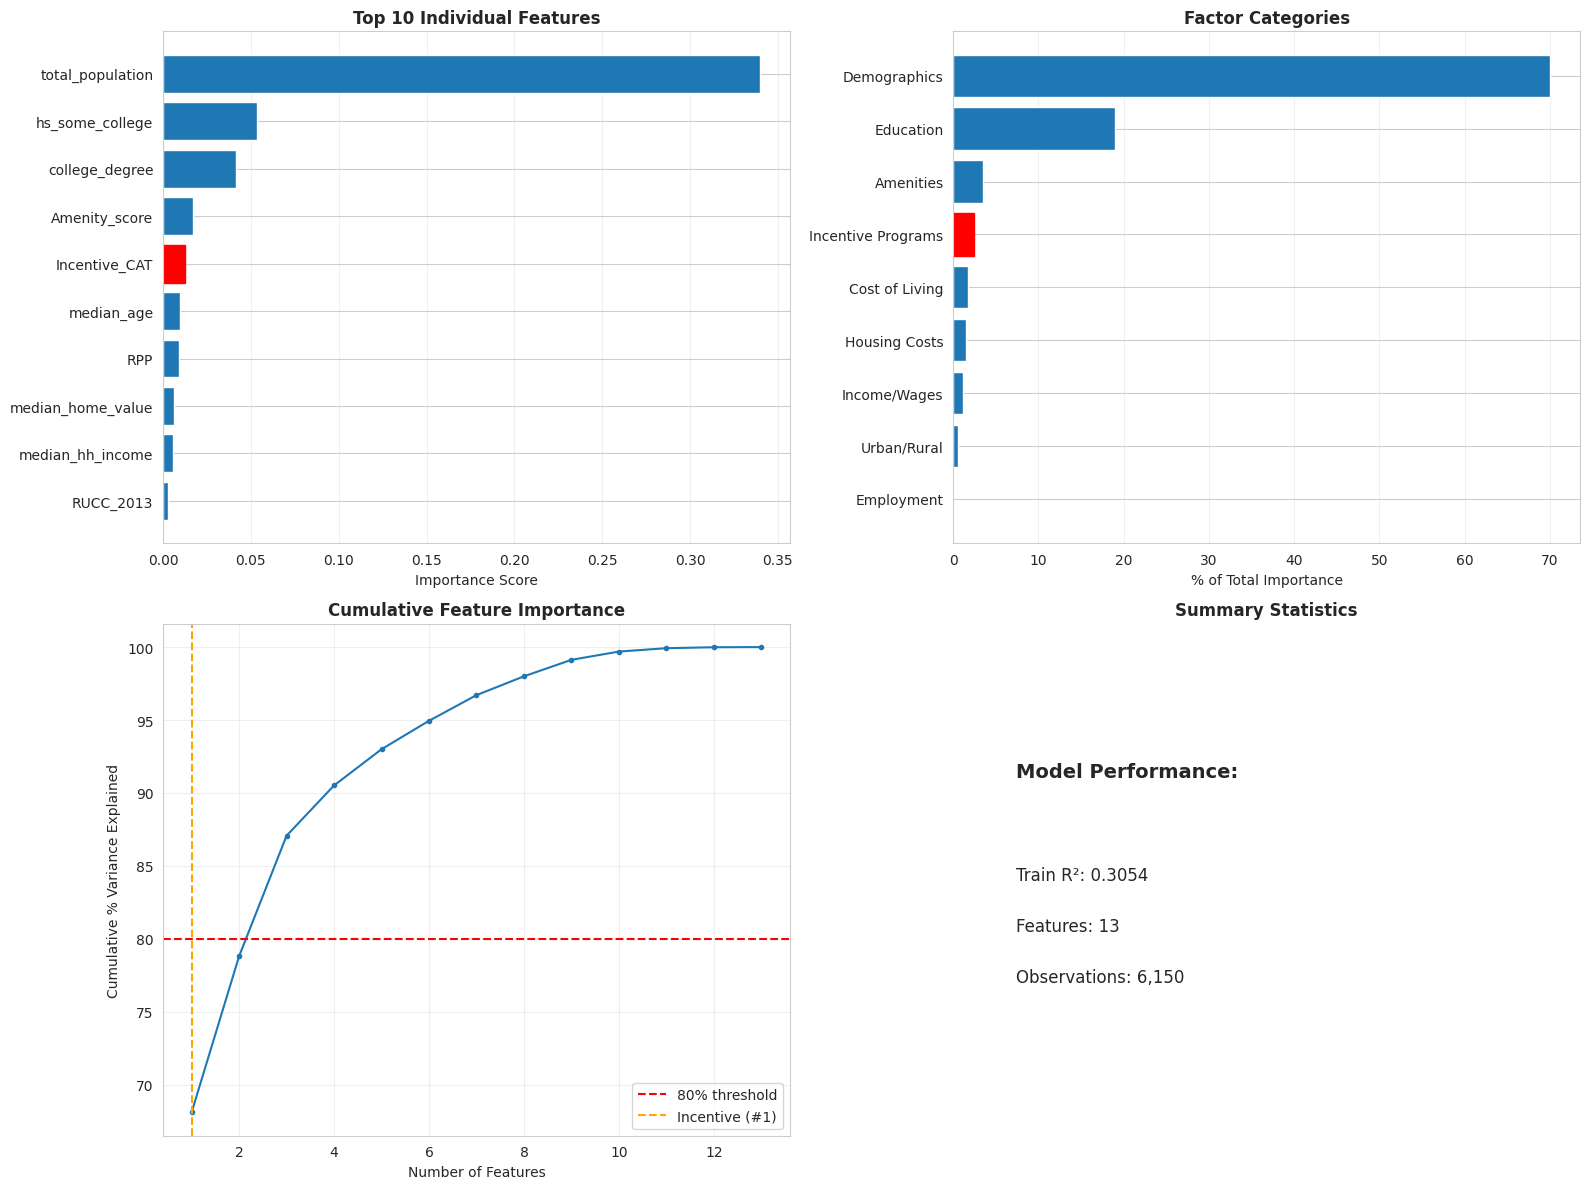


✓ Saved hypothesis3_importance.png
✓ Saved hypothesis3_feature_importance.csv
✓ Saved hypothesis3_category_importance.csv
✓ Saved hypothesis3_results.txt


In [79]:
# =======================================================================
# HYPOTHESIS 3: MULTI-FACTOR RELATIVE IMPORTANCE ANALYSIS
# =======================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

print("="*30)
print("HYPOTHESIS 3: MULTI-FACTOR DECISION ANALYSIS")
print("="*30)
print("Testing: Are incentive programs meaningful among other factors?")

# Load data
comp_df = pd.read_csv('comp_df.csv', dtype={'FIPS': str})

# Focus on COVID period (2020-2021) when programs were most active
h3_data = comp_df[comp_df['YEAR'] >= 2020].copy()

print(f"\nAnalysis period: 2020-2021")
print(f"Sample size: {len(h3_data):,} observations")
print(f"Counties: {h3_data['FIPS'].nunique()}")

# ============================================================================
# DEFINE FACTORS
# ============================================================================

# All factors that could influence migration
factors = {
    'Incentive Programs': ['Incentive_CAT'],
    'Income/Wages': ['BEA_pci', 'median_hh_income'],
    'Employment': ['unemploy_rate'],
    'Housing Costs': ['median_home_value', 'median_property_taxes'],
    'Cost of Living': ['RPP'],
    'Education': ['college_degree', 'hs_some_college'],
    'Amenities': ['Amenity_score'],
    'Urban/Rural': ['RUCC_2013'],
    'Demographics': ['total_population', 'median_age', 'pct_white_collar']
}

# Flatten to single list
all_features = []
for category, features in factors.items():
    all_features.extend(features)

print(f"\nTesting {len(all_features)} features across {len(factors)} categories")

# ============================================================================
# PREPARE DATA
# ============================================================================

# Select features that exist in data
available_features = [f for f in all_features if f in h3_data.columns]
print(f"Available features: {len(available_features)}")

# Create modeling dataset
model_data = h3_data[available_features + ['net_movers']].dropna()

print(f"\nAfter dropping nulls: {len(model_data):,} observations")

X_h3 = model_data[available_features]
y_h3 = model_data['net_movers']

# ============================================================================
# METHOD 1: RANDOM FOREST FEATURE IMPORTANCE
# ============================================================================
print("\n" + "="*30)
print("METHOD 1: RANDOM FOREST IMPORTANCE")
print("="*30)

# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_leaf=50,
    n_jobs=-1)

rf.fit(X_h3, y_h3)

# Get feature importance
rf_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf.feature_importances_})

rf_importance = rf_importance.sort_values('Importance', ascending=False)
rf_importance['Pct_Importance'] = (rf_importance['Importance'] /
                                    rf_importance['Importance'].sum() * 100)
rf_importance['Cumulative_Pct'] = rf_importance['Pct_Importance'].cumsum()

print("\nTop 15 Features (Random Forest):")
print(rf_importance.head(15).to_string(index=False))

# ============================================================================
# METHOD 2: PERMUTATION IMPORTANCE (MORE RELIABLE)
# ============================================================================
print("\n" + "="*30)
print("METHOD 2: PERMUTATION IMPORTANCE")
print("="*30)
print("(More reliable - measures actual prediction degradation)")

perm_importance = permutation_importance(
    rf, X_h3, y_h3,
    n_repeats=10,
    random_state=42,
    n_jobs=-1)

perm_df = pd.DataFrame({
    'Feature': available_features,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std})

perm_df = perm_df.sort_values('Importance', ascending=False)
perm_df['Pct_Importance'] = (perm_df['Importance'] /
                              perm_df['Importance'].sum() * 100)
perm_df['Cumulative_Pct'] = perm_df['Pct_Importance'].cumsum()

print("\nTop 15 Features (Permutation Importance):")
print(perm_df.head(15).to_string(index=False))

# ============================================================================
# METHOD 3: GROUPED IMPORTANCE BY CATEGORY
# ============================================================================
print("\n" + "="*30)
print("METHOD 3: CATEGORY-LEVEL IMPORTANCE")
print("="*30)

category_importance = []

for category, features in factors.items():
    # Sum importance for all features in category
    category_features = [f for f in features if f in available_features]

    if category_features:
        rf_cat_importance = rf_importance[
            rf_importance['Feature'].isin(category_features)]['Importance'].sum()

        perm_cat_importance = perm_df[
            perm_df['Feature'].isin(category_features)]['Importance'].sum()

        category_importance.append({
            'Category': category,
            'N_Features': len(category_features),
            'RF_Importance': rf_cat_importance,
            'Perm_Importance': perm_cat_importance})

category_df = pd.DataFrame(category_importance)
category_df = category_df.sort_values('Perm_Importance', ascending=False)
category_df['Pct_Importance'] = (category_df['Perm_Importance'] /
                                  category_df['Perm_Importance'].sum() * 100)

print("\nCategory Importance (Permutation Method):")
print(category_df.to_string(index=False))

# ============================================================================
# HYPOTHESIS 3 TEST
# ============================================================================
print("\n" + "="*30)
print("HYPOTHESIS 3 TEST")
print("="*30)

# Find incentive program rank
incentive_rank = perm_df[perm_df['Feature'] == 'Incentive_CAT'].index[0] + 1
incentive_pct = perm_df[perm_df['Feature'] == 'Incentive_CAT']['Pct_Importance'].values[0]
incentive_importance = perm_df[perm_df['Feature'] == 'Incentive_CAT']['Importance'].values[0]

print(f"\nIncentive Programs (Incentive_CAT):")
print(f"  Rank: #{incentive_rank} of {len(available_features)} features")
print(f"  Importance Score: {incentive_importance:.4f}")
print(f"  Percentage of Total: {incentive_pct:.2f}%")

# Category rank
incentive_category_rank = category_df[
    category_df['Category'] == 'Incentive Programs'].index[0] + 1
incentive_category_pct = category_df[
    category_df['Category'] == 'Incentive Programs']['Pct_Importance'].values[0]

print(f"\nIncentive Programs (Category Level):")
print(f"  Rank: #{incentive_category_rank} of {len(category_df)} categories")
print(f"  Percentage of Total: {incentive_category_pct:.2f}%")

# Top 3 factors
top_3_categories = category_df.head(3)['Category'].tolist()
print(f"\nTop 3 Factor Categories:")
for i, cat in enumerate(top_3_categories, 1):
    pct = category_df[category_df['Category'] == cat]['Pct_Importance'].values[0]
    print(f"  {i}. {cat}: {pct:.1f}%")

print("\n" + "="*30)
print("HYPOTHESIS 3 CONCLUSION")
print("="*30)

if incentive_rank <= 5:
    print("✓ HYPOTHESIS 3 STRONGLY SUPPORTED")
    print(f"  Incentive programs rank #{incentive_rank} among all factors")
    print("  Programs generate meaningful interest alongside economic factors")
elif incentive_rank <= 10:
    print("✓ HYPOTHESIS 3 SUPPORTED")
    print(f"  Incentive programs rank #{incentive_rank} - in top 10")
    print("  Programs are meaningful but not dominant factor")
elif incentive_category_rank <= 3:
    print("✓ HYPOTHESIS 3 PARTIALLY SUPPORTED")
    print(f"  Category ranks #{incentive_category_rank} overall")
    print("  Programs matter but economic factors dominate")
else:
    print("✗ HYPOTHESIS 3 NOT SUPPORTED")
    print(f"  Incentive programs rank #{incentive_rank}")
    print("  Economic and demographic factors far more important")

print(f"\nInterpretation:")
print(f"  Migration is multi-factor: Top 3 categories explain {category_df.head(3)['Pct_Importance'].sum():.1f}%")
print(f"  Incentive programs explain {incentive_category_pct:.1f}% of variance")
print(f"  Other factors (jobs, housing, etc.) explain {100-incentive_category_pct:.1f}%")

# ============================================================================
# VISUALIZE RESULTS
# ============================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top 10 Features
ax1 = axes[0, 0]
top10 = perm_df.head(10)
ax1.barh(range(len(top10)), top10['Importance'])
ax1.set_yticks(range(len(top10)))
ax1.set_yticklabels(top10['Feature'])
ax1.set_xlabel('Importance Score')
ax1.set_title('Top 10 Individual Features', fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Highlight incentive program
if 'Incentive_CAT' in top10['Feature'].values:
    incentive_idx = top10[top10['Feature'] == 'Incentive_CAT'].index[0]
    pos = list(top10['Feature']).index('Incentive_CAT')
    ax1.get_children()[pos].set_color('red')

# Plot 2: Category Importance
ax2 = axes[0, 1]
ax2.barh(range(len(category_df)), category_df['Pct_Importance'])
ax2.set_yticks(range(len(category_df)))
ax2.set_yticklabels(category_df['Category'])
ax2.set_xlabel('% of Total Importance')
ax2.set_title('Factor Categories', fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Highlight incentive
incentive_cat_pos = list(category_df['Category']).index('Incentive Programs')
ax2.get_children()[incentive_cat_pos].set_color('red')

# Plot 3: Cumulative Importance
ax3 = axes[1, 0]
ax3.plot(range(1, len(perm_df)+1), perm_df['Cumulative_Pct'], marker='o', markersize=3)
ax3.axhline(y=80, color='r', linestyle='--', label='80% threshold')
ax3.set_xlabel('Number of Features')
ax3.set_ylabel('Cumulative % Variance Explained')
ax3.set_title('Cumulative Feature Importance', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Mark incentive program position
ax3.axvline(x=incentive_rank, color='orange', linestyle='--',
            label=f'Incentive (#{incentive_rank})')
ax3.legend()

# Plot 4: Model Performance
ax4 = axes[1, 1]
model_stats = {
    'Train R²': rf.score(X_h3, y_h3),
    'Features': len(available_features),
    'Observations': len(model_data)}

ax4.text(0.1, 0.7, 'Model Performance:', fontsize=14, fontweight='bold')
y_pos = 0.5
for key, value in model_stats.items():
    if isinstance(value, float):
        ax4.text(0.1, y_pos, f'{key}: {value:.4f}', fontsize=12)
    else:
        ax4.text(0.1, y_pos, f'{key}: {value:,}', fontsize=12)
    y_pos -= 0.1

ax4.axis('off')
ax4.set_title('Summary Statistics', fontweight='bold')

plt.tight_layout()
plt.savefig('hypothesis3_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved hypothesis3_importance.png")

# ============================================================================
# SAVE RESULTS
# ============================================================================
perm_df.to_csv('hypothesis3_feature_importance.csv', index=False)
category_df.to_csv('hypothesis3_category_importance.csv', index=False)

with open('hypothesis3_results.txt', 'w') as f:
    f.write("="*30 + "\n")
    f.write("HYPOTHESIS 3: MULTI-FACTOR IMPORTANCE ANALYSIS\n")
    f.write("="*30 + "\n\n")
    f.write(f"Incentive Programs Rank: #{incentive_rank} of {len(available_features)}\n")
    f.write(f"Importance: {incentive_pct:.2f}%\n\n")
    f.write("\nTOP 15 FEATURES:\n")
    f.write(perm_df.head(15).to_string(index=False))
    f.write("\n\nCATEGORY IMPORTANCE:\n")
    f.write(category_df.to_string(index=False))

print("✓ Saved hypothesis3_feature_importance.csv")
print("✓ Saved hypothesis3_category_importance.csv")
print("✓ Saved hypothesis3_results.txt")

In [80]:
# ============================================================================
# OBJECTIVE: TRANSIENT vs PERMANENT MIGRATION
# ============================================================================

# Calculate 2-year persistence rate
comp_df_sorted = comp_df.sort_values(['FIPS', 'YEAR'])
comp_df_sorted['net_movers_2yr_later'] = comp_df_sorted.groupby('FIPS')['net_movers'].shift(-2)

# 2020 inflows, check 2022 retention
covid_cohort = comp_df_sorted[comp_df_sorted['YEAR'] == 2020].copy()
covid_cohort['retained'] = (covid_cohort['net_movers_2yr_later'] > 0).astype(int)

# Compare incentive vs non-incentive counties
retention_summary = covid_cohort.groupby('Incentive_CAT').agg({
    'retained': 'mean',
    'net_movers': 'mean',
    'net_movers_2yr_later': 'mean'}).reset_index()

retention_summary.columns = ['Incentive_CAT', 'Retention_Rate',
                              'Initial_Gain_2020', 'Sustained_2022']

print("="*30)
print("PERSISTENCE: 2020 COVID MIGRANTS")
print("="*30)
print(retention_summary)

print("\nInterpretation:")
print("Retention_Rate: % of counties still gaining migrants 2 years later")
print("Initial_Gain_2020: Average net migration during COVID")
print("Sustained_2022: Average net migration 2 years later")

PERSISTENCE: 2020 COVID MIGRANTS
   Incentive_CAT  Retention_Rate  Initial_Gain_2020  Sustained_2022
0           0.00            0.00             -59.56             NaN
1           1.00            0.00             438.89             NaN
2           2.00            0.00           -2891.17             NaN
3           3.00            0.00            1042.70             NaN

Interpretation:
Retention_Rate: % of counties still gaining migrants 2 years later
Initial_Gain_2020: Average net migration during COVID
Sustained_2022: Average net migration 2 years later


In [85]:
# ============================================================================
# OBJECTIVE: TRANSIENT vs PERMANENT MIGRATION
# ============================================================================
from scipy.stats import mannwhitneyu, chi2_contingency

comp_df = pd.read_csv('comp_df.csv', dtype={'FIPS': str})
comp_df = comp_df.sort_values(['FIPS', 'YEAR'])

# Create forward-looking migration
comp_df['net_movers_2yr_later'] = comp_df.groupby('FIPS')['net_movers'].shift(-2)

# 2020 COVID cohort
covid_cohort = comp_df[comp_df['YEAR'] == 2020].dropna(subset=['net_movers', 'net_movers_2yr_later']).copy()
covid_cohort['has_incentive'] = (covid_cohort['Incentive_CAT'] > 0).astype(int)
covid_cohort['persistent'] = ((covid_cohort['net_movers'] > 0) & (covid_cohort['net_movers_2yr_later'] > 0)).astype(int)

print("="*30)
print("OBJECTIVE: TRANSIENT vs PERMANENT MIGRATION")
print("="*30)
print(f"2020 cohort: {len(covid_cohort):,} counties")
print(f"Gained in 2020: {(covid_cohort['net_movers'] > 0).sum()}")
print(f"Still gaining 2022: {covid_cohort['persistent'].sum()}")

# Compare groups
summary = covid_cohort.groupby('has_incentive').agg({
    'net_movers': ['mean', 'count'],
    'net_movers_2yr_later': 'mean',
    'persistent': 'mean'})
summary.columns = ['Avg_2020', 'N_Counties', 'Avg_2022', 'Persistence_Rate']

print("\nPersistence by Incentive Status:")
print(summary.round(2))

# Statistical tests
incentive_2022 = covid_cohort[covid_cohort['has_incentive'] == 1]['net_movers_2yr_later']
no_incentive_2022 = covid_cohort[covid_cohort['has_incentive'] == 0]['net_movers_2yr_later']

if len(incentive_2022) > 0 and len(no_incentive_2022) > 0:
    stat, p_retention = mannwhitneyu(incentive_2022, no_incentive_2022)
    print(f"\nMann-Whitney U test (2022 levels):")
    print(f"  p-value: {p_retention:.4f}")
    print(f"  Significant: {'Yes' if p_retention < 0.05 else 'No'}")
else:
    print("\nInsufficient data for Mann-Whitney test")
    p_retention = None

# Chi-square test for persistence rate
contingency = pd.crosstab(covid_cohort['has_incentive'], covid_cohort['persistent'])
print(f"\nContingency table:")
print(contingency)

if contingency.size > 0 and (contingency > 0).all().all():
    chi2, p_chi2, _, _ = chi2_contingency(contingency)
    print(f"\nChi-square test (persistence rate):")
    print(f"  Chi-square: {chi2:.2f}")
    print(f"  p-value: {p_chi2:.4f}")
    print(f"  Significant: {'Yes' if p_chi2 < 0.05 else 'No'}")
else:
    print("\nInsufficient variation for Chi-square test")
    p_chi2 = None

# Conclusion
print("\n" + "="*30)
print("CONCLUSION")
print("="*30)

if p_chi2 is not None and p_chi2 < 0.05:
    incentive_persist = summary.loc[1, 'Persistence_Rate'] if 1 in summary.index else 0
    no_incentive_persist = summary.loc[0, 'Persistence_Rate'] if 0 in summary.index else 0

    if incentive_persist > no_incentive_persist:
        print("✓ OBJECTIVE SUPPORTED: Incentive programs create lasting growth")
    else:
        print("✗ OBJECTIVE NOT SUPPORTED: No persistence advantage")
elif p_retention is not None and p_retention < 0.05:
    if incentive_2022.median() > no_incentive_2022.median():
        print("✓ OBJECTIVE PARTIALLY SUPPORTED: Higher 2022 migration")
    else:
        print("✗ OBJECTIVE NOT SUPPORTED: Lower 2022 migration")
else:
    print("? OBJECTIVE INCONCLUSIVE: No significant differences detected")

# Save
summary.to_csv('objective_persistence.csv')
print("\n✓ Saved objective_persistence.csv")

OBJECTIVE: TRANSIENT vs PERMANENT MIGRATION
2020 cohort: 0 counties
Gained in 2020: 0
Still gaining 2022: 0

Persistence by Incentive Status:
Empty DataFrame
Columns: [Avg_2020, N_Counties, Avg_2022, Persistence_Rate]
Index: []

Insufficient data for Mann-Whitney test

Contingency table:
Empty DataFrame
Columns: []
Index: []

Insufficient variation for Chi-square test

CONCLUSION
? OBJECTIVE INCONCLUSIVE: No significant differences detected

✓ Saved objective_persistence.csv


# Data Map Visual

In [64]:
# ========================================================================
# GRAPHVIZ Data Map
# ========================================================================

def create_data_map():
    dot = Digraph(comment='Migration Data Map', format='png')
    dot.attr(rankdir='TB', size='16,20', dpi='300')
    dot.attr('node', shape='box', style='rounded,filled', fontname='Arial')

    # Raw data sources (Blue)
    dot.attr('node', fillcolor='lightblue')
    dot.node('BEA', 'BEA API\nPer Capita Income\nGDP, RPP\n2011-2021')
    dot.node('BLS', 'BLS API\nUnemployment\n2011-2021')
    dot.node('CENSUS', 'Census API\nDemographics\nHousing\n2011-2021')
    dot.node('IRS', 'IRS CSV Files\nCounty Migration\n11 files')
    dot.node('USDA', 'USDA Files\nRUCC, Amenities\nTypology')
    dot.node('INCENTIVE', 'Manual Collection\nIncentive Programs\n2016-2021')

    # Cleaned files (Yellow)
    dot.attr('node', fillcolor='lightyellow')
    dot.node('BEA_CLEAN', 'BEA_clean.csv\n3,118 FIPS × 11 years')
    dot.node('BLS_CLEAN', 'BLS_clean.csv\n3,135 FIPS × 11 years')
    dot.node('CENSUS_CLEAN', 'Census_clean.csv\n3,146 FIPS × 11 years')
    dot.node('IRS_CLEAN', 'IRS_clean.csv\n3,081 FIPS × 11 years')
    dot.node('USDA_CLEAN', 'USDA_clean.csv\n3,142 FIPS × 11 years')
    dot.node('INCENTIVE_CLEAN', 'Incentive_clean.csv\n656 FIPS')

    # IRS outputs
    dot.node('IRS_PANEL', 'IRS_panel.csv\nnet_movers, net_agi')
    dot.node('IRS_DYADIC', 'IRS_dyadic.csv\nDirectional flows')
    dot.node('IRS_RECIPROCAL', 'IRS_dyadic_reciprocal.csv\nBidirectional pairs')

    # Processing steps (Lavender)
    dot.attr('node', fillcolor='lavender')
    dot.node('GEO', 'Geographic\nStandardization')
    dot.node('MERGE', 'Outer Join\nFIPS + YEAR')
    dot.node('POST', 'Post-Merge\nCleaning')
    dot.node('IMPUTE', 'Missing Value\nImputation')
    dot.node('COMPOSITES', 'Create\nComposites')

    # Final outputs (Green)
    dot.attr('node', fillcolor='lightgreen', style='rounded,filled,bold')
    dot.node('PANEL', 'migration_panel.csv\n34,287 rows\n3,117 FIPS × 11 years')
    dot.node('FINAL', 'migration_panel_composites.csv\n84 variables\nREADY FOR MODELING')

    # Models (Salmon)
    dot.attr('node', fillcolor='lightsalmon')
    dot.node('M1', 'Model 1\nPanel FE')
    dot.node('M2', 'Model 2\nDiD')
    dot.node('M3', 'Model 3\nGravity')
    dot.node('M4', 'Model 4\nSpatial')
    dot.node('M5', 'Model 5\nDynamic')

    # Edges
    dot.edges([
        ('BEA', 'BEA_CLEAN'),
        ('BLS', 'BLS_CLEAN'),
        ('CENSUS', 'CENSUS_CLEAN'),
        ('IRS', 'IRS_CLEAN'),
        ('USDA', 'USDA_CLEAN'),
        ('INCENTIVE', 'INCENTIVE_CLEAN'),
        ('IRS', 'IRS_PANEL'),
        ('IRS', 'IRS_DYADIC'),
        ('IRS_DYADIC', 'IRS_RECIPROCAL'),
        ('BEA_CLEAN', 'GEO'),
        ('BLS_CLEAN', 'GEO'),
        ('CENSUS_CLEAN', 'GEO'),
        ('USDA_CLEAN', 'GEO'),
        ('IRS_PANEL', 'GEO'),
        ('GEO', 'MERGE'),
        ('INCENTIVE_CLEAN', 'MERGE'),
        ('MERGE', 'POST'),
        ('POST', 'IMPUTE'),
        ('IMPUTE', 'PANEL'),
        ('PANEL', 'COMPOSITES'),
        ('COMPOSITES', 'FINAL'),
        ('FINAL', 'M1'),
        ('FINAL', 'M2'),
        ('FINAL', 'M4'),
        ('FINAL', 'M5'),
        ('IRS_RECIPROCAL', 'M3'),
        ('PANEL', 'M3')])

    return dot

# Create and save
data_map = create_data_map()
data_map.render('data_map_graphviz', cleanup=True)

print("✓ Saved data_map_graphviz.png")
print("✓ Saved data_map_graphviz.pdf")
print("\nView: Open data_map_graphviz.png in your file browser")

✓ Saved data_map_graphviz.png
✓ Saved data_map_graphviz.pdf

View: Open data_map_graphviz.png in your file browser


In [ ]:
# Display the Graphviz diagram
display(Image('data_map_graphviz.png'))

END

In [ ]:
# =======================================================================
# MODELING BRAINSTORM: Potential Approaches
# =======================================================================

print("="*30)
print("MODELING APPROACHES FOR MIGRATION ANALYSIS")
print("="*30)

print("""
1. PANEL REGRESSION MODELS (Current Dataset - County-Year Panel)

   a) Fixed Effects Model
      - Controls for time-invariant county characteristics
      - Equation: net_movers_it = β*X_it + α_i + γ_t + ε_it
      - Where: α_i = county fixed effects, γ_t = year fixed effects
      - Use for: Understanding how changes within counties affect migration

   b) Random Effects Model
      - Assumes county effects are uncorrelated with predictors
      - More efficient if assumption holds
      - Test with Hausman test

   c) First Differences
      - Δnet_movers_it = β*ΔX_it + Δε_it
      - Removes time-invariant unobservables
      - Use for: Isolating impact of policy changes

   d) Difference-in-Differences (for incentive programs)
      - Treatment: Counties adopting incentive programs
      - Control: Counties without programs
      - Estimate ATT (Average Treatment effect on Treated)

2. GRAVITY MODELS (For Dyadic Flow Analysis)

   a) Traditional Gravity Model
      - Flow_ij = (Pop_i^α * Pop_j^β) / Distance_ij^γ
      - Models bilateral migration flows
      - Include push/pull factors from both origin and destination

   b) Structural Gravity with Fixed Effects
      - Flow_ijt = exp(β*X_ijt + FE_origin + FE_dest + FE_year)
      - Origin FE: Controls for all origin characteristics
      - Dest FE: Controls for all destination characteristics
      - Poisson Pseudo-Maximum Likelihood (PPML) estimation

   c) Network Analysis
      - Identify migration clusters
      - Hub and spoke patterns
      - Community detection algorithms

3. TIME SERIES / DYNAMIC MODELS

   a) Lagged Dependent Variable
      - net_movers_it = ρ*net_movers_i,t-1 + β*X_it + ε_it
      - Captures persistence in migration patterns
      - Use Arellano-Bond estimator for dynamic panels

   b) Vector Autoregression (VAR)
      - Model interdependencies between migration and econ variables
      - Impulse response functions

   c) Event Study
      - Trace out effects before/after incentive adoption
      - Test for pre-trends

4. MACHINE LEARNING APPROACHES

   a) Random Forest / Gradient Boosting
      - Identify important predictors
      - Non-linear relationships
      - Feature importance rankings

   b) LASSO / Ridge Regression
      - Variable selection with many predictors
      - Regularization to prevent overfitting

   c) Spatial ML
      - Account for geographic spillovers
      - Spatial lag/error models

5. SPATIAL ECONOMETRICS

   a) Spatial Lag Model
      - net_movers_i = ρ*W*net_movers + β*X_i + ε
      - W = spatial weights matrix
      - Captures migration spillovers to neighbors

   b) Spatial Error Model
      - Accounts for spatial correlation in errors

   c) Spatial Durbin Model
      - Includes both spatial lag and spatial lag of X

KEY VARIABLES TO INCLUDE:
- Economic: BEA_pci, unemploy_rate, median_hh_income, BEA_gdp
- Housing: median_home_value, median_property_taxes, %owner_occupied
- Demographics: total_population, median_age, %white, %hispanic
- Geography: RUCC_2013, Amenity_score, STATE
- Policy: Incentive_CAT
- Lagged: net_movers_t-1, changes in employment, income growth
""")